# Logrank with Imprint


In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import scipy.stats
import matplotlib.pyplot as plt

from imprint.nb_util import setup_nb
setup_nb()
import imprint as ip

In [2]:
# C++ code:
# https://github.com/Confirm-Solutions/confirmasaurus/blob/ce185970a282ebc981012cbd68bcbffbd3e151b5/imprint/imprint/include/imprint_bits/model/exponential/simple_log_rank.hpp
# https://github.com/Confirm-Solutions/confirmasaurus/blob/ce185970a282ebc981012cbd68bcbffbd3e151b5/imprint/python/example/simple_log_rank.py
# https://github.com/Confirm-Solutions/confirmasaurus/blob/ce185970a282ebc981012cbd68bcbffbd3e151b5/imprint/imprint/include/imprint_bits/model/exponential/common/fixed_n_log_hazard_rate.hpp
# https://github.com/Confirm-Solutions/confirmasaurus/blob/ce185970a282ebc981012cbd68bcbffbd3e151b5/imprint/imprint/include/imprint_bits/stat/log_rank_test.hpp

In [3]:
# https://lifelines.readthedocs.io/en/latest/lifelines.statistics.html#lifelines.statistics.multivariate_logrank_test
# https://en.wikipedia.org/wiki/Logrank_test
# https://web.stanford.edu/~lutian/coursepdf/unitweek3.pdf
@jax.jit
def logrank_test(all_rvs, group, censoring_time):
    n0 = jnp.array([jnp.sum(~group), jnp.sum(group)])
    ordering = jnp.argsort(all_rvs)
    ordered = all_rvs[ordering]
    ordered_group = group[ordering]
    include = ordered <= censoring_time
    event_now = jnp.stack((~ordered_group, ordered_group), axis=0) * include
    events_so_far = jnp.concatenate(
        (jnp.zeros((2, 1)), event_now.cumsum(axis=1)[:, :-1]), axis=1
    )
    Nij = n0[:, None] - events_so_far
    Oij = event_now
    Nj = Nij.sum(axis=0)
    Oj = Oij.sum(axis=0)
    Eij = Nij * (Oj / Nj)
    Vij = Eij * ((Nj - Oj) / Nj) * ((Nj - Nij) / (Nj - 1))
    denom = jnp.sum(jnp.where(~jnp.isnan(Vij[0]), Vij[0], 0), axis=0)
    return jnp.sum(Oij[0] - Eij[0], axis=0) / jnp.sqrt(denom)


In [4]:
import scipy.stats
import lifelines
from lifelines.statistics import multivariate_logrank_test

rvs = scipy.stats.expon.rvs(size=(10, 2))
control_rvs = rvs[:,0] 
hazard_ratio = 0.7
treatment_rvs = rvs[:,1] / hazard_ratio
all_rvs = np.concatenate([control_rvs, treatment_rvs])
group = np.concatenate([np.zeros(control_rvs.shape[0]), np.ones(treatment_rvs.shape[0])]).astype(bool)
ours = logrank_test(all_rvs, group, censoring_time=10000)
theirs = multivariate_logrank_test(all_rvs, group, t0=10000).test_statistic
ours**2, theirs

(DeviceArray(0.33794776, dtype=float32), 0.33794799164055045)

In [5]:
# Survival analysis:
# - recruit n patients at t=0
# - observe them until censoring_time.
class LogRank:
    def __init__(self, seed, max_K, *, n, censoring_time):
        self.max_K = max_K
        self.censoring_time = censoring_time
        self.n = n
        self.family = "exponential"
        self.family_params = {"n": n}

        self.key = jax.random.PRNGKey(seed)
        self.samples = jax.random.exponential(self.key, shape=(max_K, n, 2))
        self.group = jnp.concatenate(
            [jnp.zeros((max_K, n)), jnp.ones((max_K, n))], axis=1
        ).astype(bool)
        self.vmap_logrank_test = jax.vmap(
            jax.vmap(logrank_test, in_axes=(0, 0, None)), in_axes=(0, None, None)
        )

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        control_hazard = -theta[:, 0]
        treatment_hazard = -theta[:, 1]
        hazard_ratio = treatment_hazard / control_hazard
        sample_subset = self.samples[begin_sim:end_sim]
        group_subset = self.group[begin_sim:end_sim]

        control_rvs = jnp.tile(sample_subset[None, :, :, 0], (hazard_ratio.shape[0], 1, 1))
        treatment_rvs = sample_subset[None, :, :, 1] / hazard_ratio[:, None, None]
        all_rvs = jnp.concatenate([control_rvs, treatment_rvs], axis=2)
        test_stat = -self.vmap_logrank_test(
            all_rvs, group_subset, self.censoring_time
        )
        return test_stat

In [6]:
g = ip.cartesian_grid(
    [-2, -2], [-1, -1], n=[1, 1], null_hypos=[ip.hypo("theta0 > theta1")]
)
lr = LogRank(0, 200000, n=100, censoring_time=10000000)
stats = lr.sim_batch(0, lr.max_K, g.get_theta(), g.get_null_truth())

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=1, worker_id=1, t=1675865093, n_bits=18, worker_bits=18) = [4484107828830928896, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=2, worker_id=1, t=1675865094, n_bits=18, worker_bits=18) = [4484107897550405632 4484107897550405633, ...]:


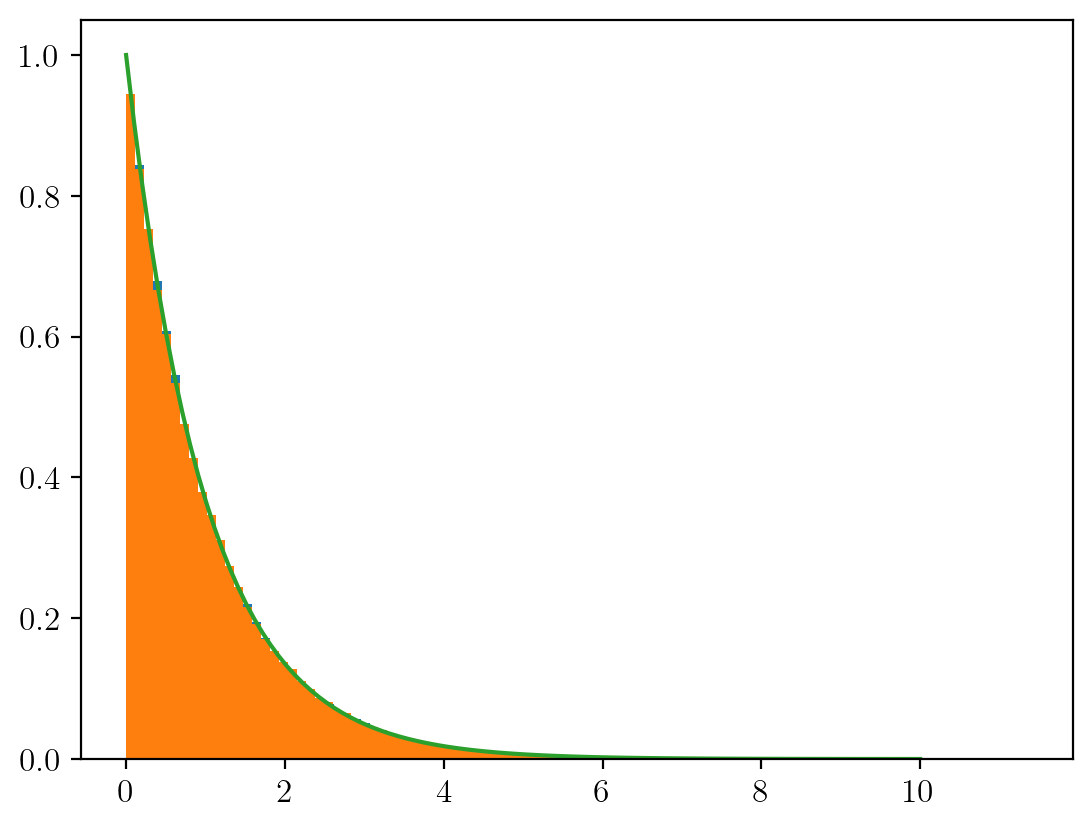

In [7]:
# plot lr.samples[:,0,0] and lr.samples[:,0,1] on the same plot
plt.figure()
plt.hist(lr.samples[:,0,0].ravel(), bins=100, density=True, label='control')
plt.hist(lr.samples[:,0,1].ravel(), bins=100, density=True, label='treatment')
# and compare to an exponential distribution with lambda = 1
x = jnp.linspace(0, 10, 100)
plt.plot(x, scipy.stats.expon.pdf(x), label="exponential")

plt.show()

The log rank test statistic should be asymptotically standard normal when the null hypothesis is true! But it's not...

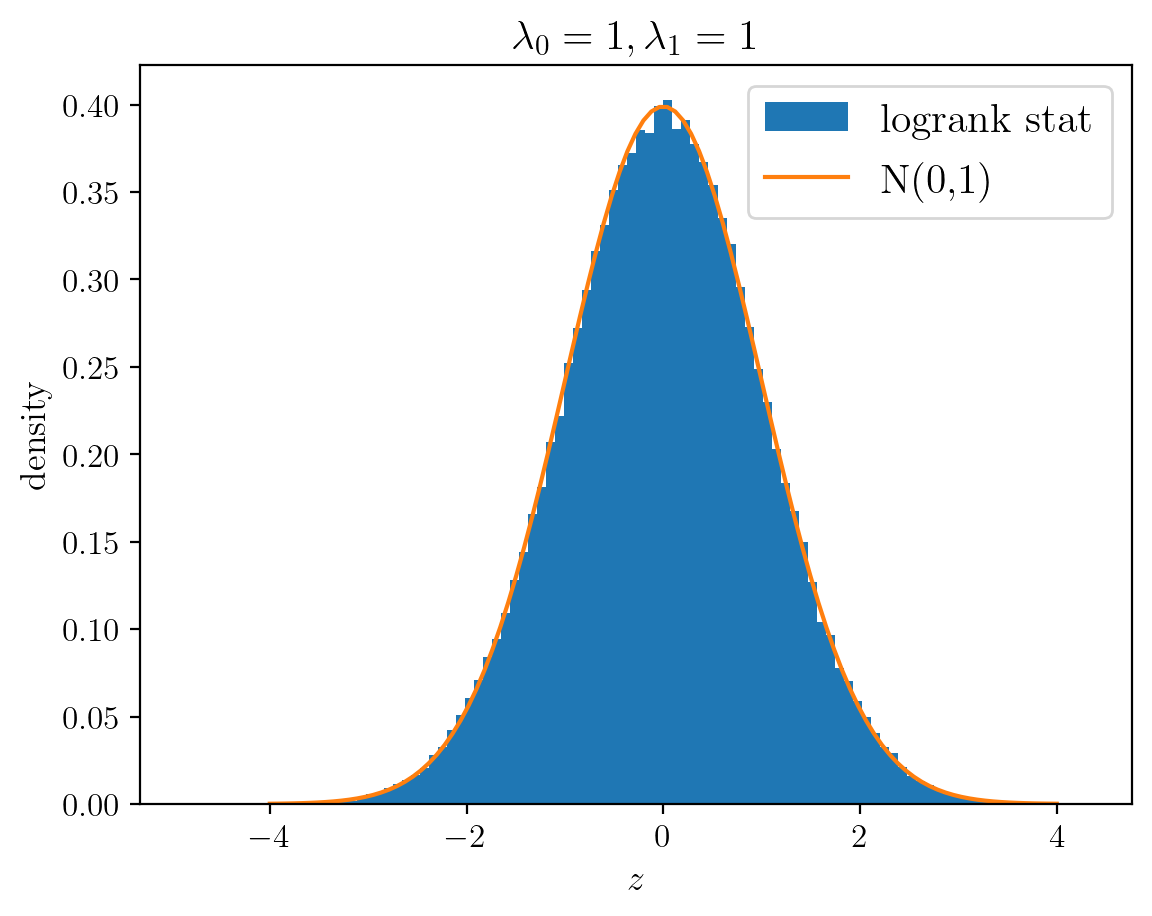

In [8]:
plt.title('$\lambda_0 = 1, \lambda_1 = 1$')
plt.hist(stats.flatten(), bins=100, density=True, label='logrank stat')
xs = np.linspace(-4, 4, 100)
plt.plot(xs, scipy.stats.norm.pdf(xs), label='N(0,1)')
plt.xlabel('$z$')
plt.ylabel('density')
plt.legend()
plt.show()

In [9]:
g = ip.cartesian_grid([-2, -2], [-0.5, -0.5], n=[20, 20], null_hypos=[ip.hypo("theta0 > theta1")])
rej_df = ip.validate(LogRank, g=g, lam=-1.96, model_kwargs=dict(n=10, censoring_time=12))
rej_df

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=400, worker_id=1, t=1675865103, n_bits=18, worker_bits=18) = [4484108516025696256 4484108516025696257 4484108516025696258, ...]:
DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=40, worker_id=1, t=1675865104, n_bits=18, worker_bits=18) = [4484108584745172992 4484108584745172993 4484108584745172994, ...]:


,tie_sum,tie_est,tie_cp_bound,tie_bound,K
0,439,0.026794,0.029876,0.039328,16384
1,368,0.022461,0.025302,0.033773,16384
2,318,0.019409,0.022066,0.029853,16384
3,270,0.016479,0.018944,0.026026,16384
4,231,0.014099,0.016393,0.022894,16384
...,...,...,...,...,...
205,513,0.031311,0.034622,0.063310,16384
206,513,0.031311,0.034622,0.067028,16384
207,513,0.031311,0.034622,0.071811,16384
208,513,0.031311,0.034622,0.078174,16384


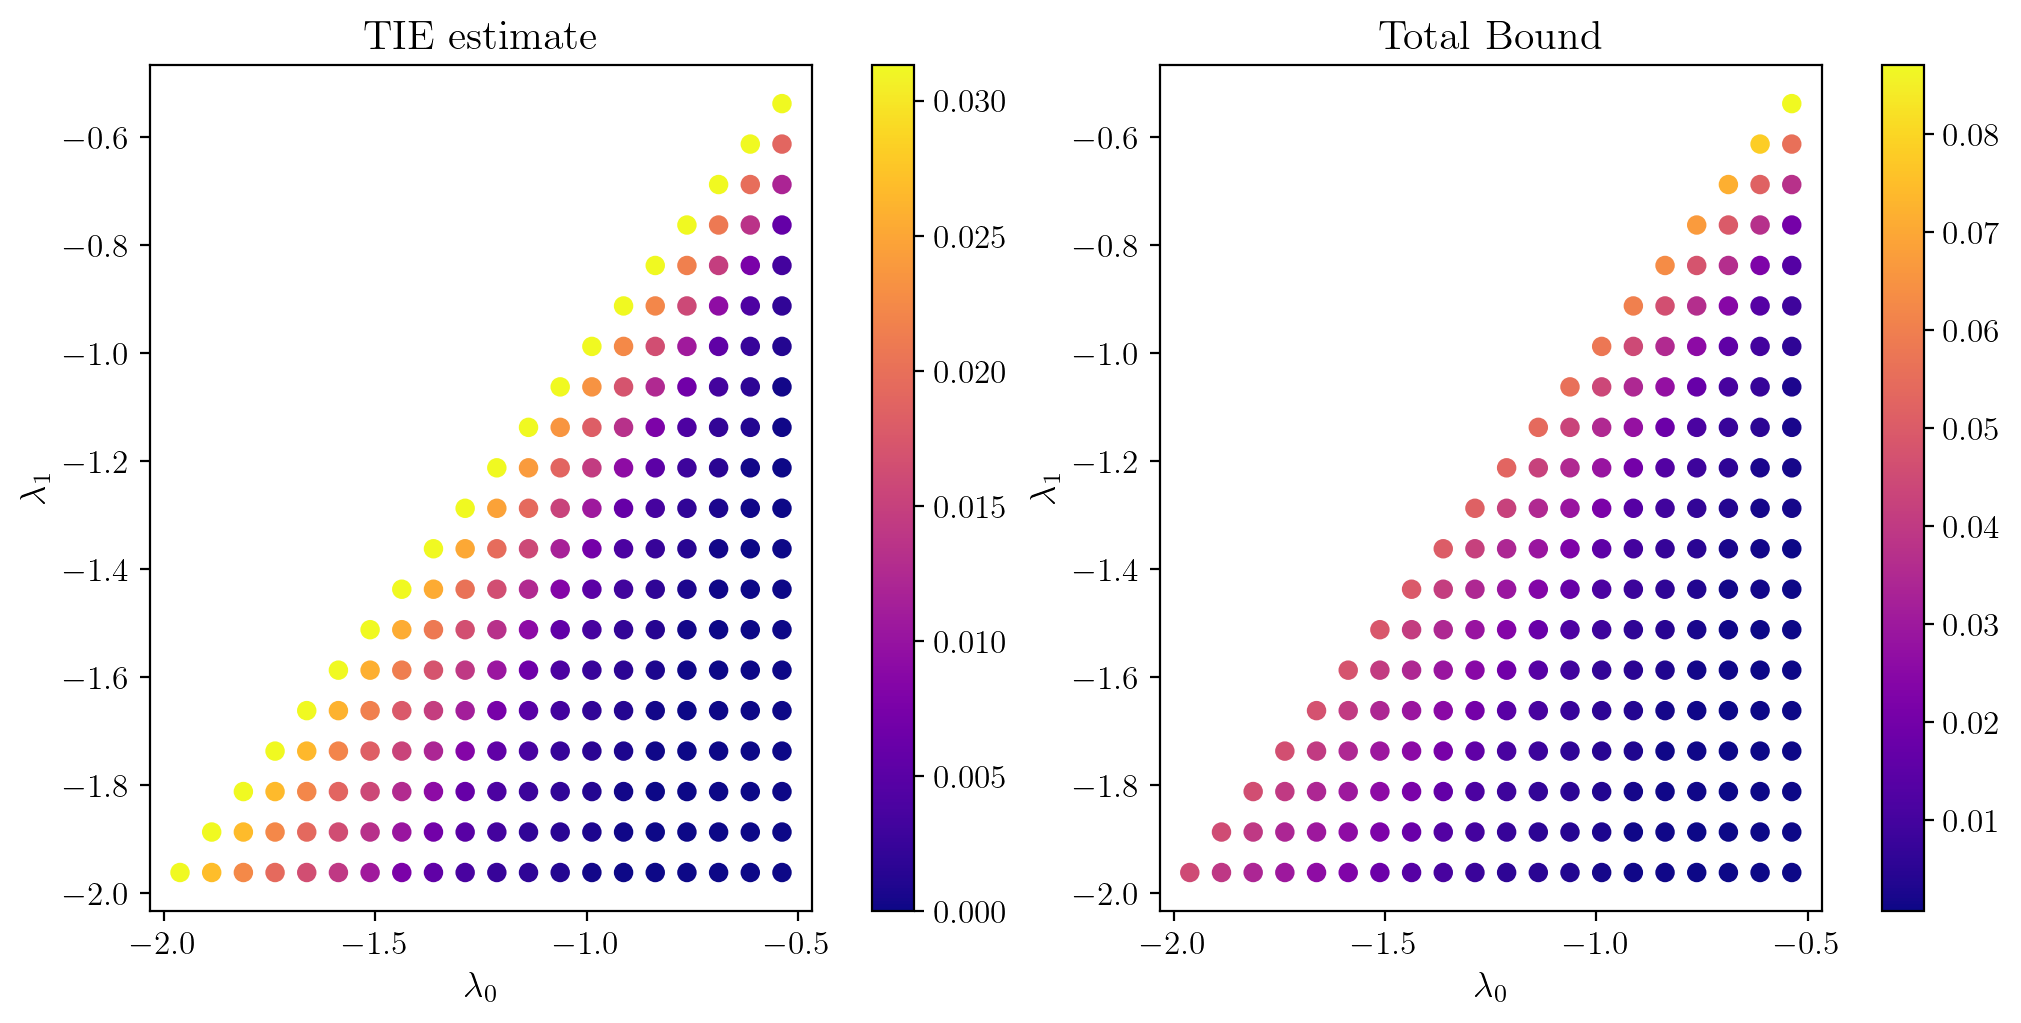

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5), constrained_layout=True)
plt.subplot(1,2,1)
plt.title('TIE estimate')
plt.scatter(g.df['theta0'], g.df['theta1'], c=rej_df['tie_est'])
plt.xlabel('$\lambda_0$')
plt.ylabel('$\lambda_1$')
plt.colorbar()

plt.subplot(1,2,2)
plt.title('Total Bound')
plt.scatter(g.df['theta0'], g.df['theta1'], c=rej_df['tie_bound'])
plt.xlabel('$\lambda_0$')
plt.ylabel('$\lambda_1$')
plt.colorbar()

plt.show()

In [23]:
db = ch.Clickhouse.connect()
reports, db = ada.ada_validate(
    LogRank,
    g=g,
    db=db,
    n_steps=2,
    lam=-1.96,
    model_kwargs=dict(n=10, censoring_time=12)
)

INFO:confirm.cloud.clickhouse:[worker_id=2] 
Clickhouse config: default@t2n4z83v82.us-east-1.aws.clickhouse.cloud:8443/None
INFO:confirm.cloud.clickhouse:[worker_id=2] 
Clickhouse config: default@t2n4z83v82.us-east-1.aws.clickhouse.cloud:8443/03b1220ed9d14eb1b8461f88980f7da7
INFO:confirm.cloud.clickhouse:[worker_id=2] 
Connected to job 03b1220ed9d14eb1b8461f88980f7da7
DEBUG:confirm.cloud.clickhouse:[worker_id=2] 
set_or_append(config) -> False None
DEBUG:confirm.cloud.clickhouse:[worker_id=2] 
set(config) -> False config
DEBUG:confirm.cloud.clickhouse:[worker_id=2] 
writing 210 tiles
DEBUG:confirm.cloud.clickhouse:[worker_id=2] 
set step info: (-1, 0, 0, 0)
DEBUG:confirm.cloud.clickhouse:[worker_id=2] 
set(null_hypos) -> False null_hypos
DEBUG:confirm.adagrid.adagrid:first step (0, 0, 1, 210) n_tiles=210 packet_size=1024
DEBUG:confirm.cloud.clickhouse:[worker_id=2] 
set step info: (0, 0, 1, 210)
DEBUG:confirm.adagrid.adagrid:Starting loop 0.
DEBUG:confirm.adagrid.adagrid:Claimed DB loc

In [24]:
import modal
import confirm.adagrid as ada
import confirm.cloud.clickhouse as ch
import confirm.cloud.modal_util as modal_util


def f():
    modal_util.setup_env()
    db = ch.Clickhouse.connect()
    reports, db = ada.ada_validate(
        LogRank,
        g=g,
        db=db,
        lam=-1.96,
        model_kwargs=dict(n=10, censoring_time=12)
    )
    return reports, db.job_id

reports, job_id = modal_util.run_on_modal(f, gpu=modal.gpu.A100())
db = ch.Clickhouse.connect(job_id=job_id)

Output()

✓ Initialized. View app at https://modal.com/apps/ap-sXN3mz6Bt78HV1Sgv72VaZ

Output()

✓ Created objects.
├── 🔨 Created f.
├── 🔨 Mounted /Users/tbent/confirm/confirmasaurus/confirm at /pkg/confirm
└── 🔨 Mounted /Users/tbent/confirm/confirmasaurus/imprint/imprint at /pkg/imprint

Output()

2023-02-08T14:41:14+0000 stdout from sops:
⠦ Running (1/1 containers active)...

 b''
⠦ Running (1/1 containers active)...

2023-02-08T14:41:14+0000 Environment variables loaded from /root/.env: ['CLICKHOUSE_HOST', 'CLICKHOUSE_TEST_HOST', 'CLICKHOUSE_PASSWORD', 'CLICKHOUSE_2_HOST', 'CLICKHOUSE_2_TEST_HOST', 'CLICKHOUSE_2_PASSWORD', 'REDIS_HOST', 'REDIS_PASSWORD', 'MODAL_TOKEN_ID', 'MODAL_TOKEN_SECRET']
⠦ Running (1/1 containers active)...

2023-02-08T14:41:14+0000 Enabling 64-bit floats in JAX.
⠦ Running (1/1 containers active)...

2023-02-08T14:41:14+0000 [worker_id=None] 
⠦ Running (1/1 containers active)...

Clickhouse config: default@t2n4z83v82.us-east-1.aws.clickhouse.cloud:8443/None
⠦ Running (1/1 containers active)...

2023-02-08T14:41:14+0000 [worker_id=None] 
⠋ Running (1/1 containers active)...

Clickhouse config: default@t2n4z83v82.us-east-1.aws.clickhouse.cloud:8443/2ec9f713e8b74cac8302940c2851fe41
⠋ Running (1/1 containers active)...

2023-02-08T14:41:14+0000 [worker_id=None] 
⠙ Running (1/1 containers active)...

Connected to job 2ec9f713e8b74cac8302940c2851fe41
⠙ Running (1/1 containers active)...

2023-02-08T14:41:17+0000 [worker_id=2] 
⠸ Running (1/1 containers active)...

set_or_append(config) -> False None
⠸ Running (1/1 containers active)...

2023-02-08T14:41:17+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

set(config) -> False config
⠴ Running (1/1 containers active)...

2023-02-08T14:41:21+0000 [worker_id=2] 
⠸ Running (1/1 containers active)...

writing 210 tiles
⠸ Running (1/1 containers active)...

2023-02-08T14:41:21+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

set step info: (-1, 0, 0, 0)
⠴ Running (1/1 containers active)...

2023-02-08T14:41:21+0000 [worker_id=2] 
⠋ Running (1/1 containers active)...

set(null_hypos) -> False null_hypos
⠋ Running (1/1 containers active)...

2023-02-08T14:41:22+0000 first step (0, 0, 1, 210) n_tiles=210 packet_size=1024
⠦ Running (1/1 containers active)...

2023-02-08T14:41:22+0000 [worker_id=2] 
⠦ Running (1/1 containers active)...

set step info: (0, 0, 1, 210)
⠦ Running (1/1 containers active)...

2023-02-08T14:41:22+0000 Starting loop 0.
⠧ Running (1/1 containers active)...

2023-02-08T14:41:22+0000 Claimed DB lock.
⠧ Running (1/1 containers active)...

2023-02-08T14:41:22+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

get step info: (0, 0, 1, 210)
⠧ Running (1/1 containers active)...

2023-02-08T14:41:22+0000 get_work(step_id=0, step_iter=0)
⠧ Running (1/1 containers active)...

2023-02-08T14:41:22+0000 get_work(...) returned 210 tiles.
⠇ Running (1/1 containers active)...

2023-02-08T14:41:22+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

set step info: (0, 1, 1, 210)
⠇ Running (1/1 containers active)...

2023-02-08T14:41:22+0000 Processing 210 tiles.
⠇ Running (1/1 containers active)...

2023-02-08T14:41:25+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

writing 210 results
⠹ Running (1/1 containers active)...

2023-02-08T14:41:25+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

writing 210 results
⠴ Running (1/1 containers active)...

2023-02-08T14:41:25+0000 {'n_processed': 210,
⠦ Running (1/1 containers active)...

 'runtime_full_iter': '3.020064',
⠦ Running (1/1 containers active)...

 'runtime_get_work': '0.067088',
⠦ Running (1/1 containers active)...

 'runtime_processing': '2.401632',
⠦ Running (1/1 containers active)...

 'runtime_update_step_info': '0.019996',
⠦ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.020381',
⠦ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠦ Running (1/1 containers active)...

 'status': 'WORK',
⠦ Running (1/1 containers active)...

 'step_id': 0,
⠦ Running (1/1 containers active)...

 'step_iter': 0,
⠦ Running (1/1 containers active)...

 'step_n_iter': 1,
⠦ Running (1/1 containers active)...

 'step_n_tiles': 210,
⠦ Running (1/1 containers active)...

 'waitings': 0,
⠦ Running (1/1 containers active)...

 'work_extraction_time': '1675867282.524618',
⠦ Running (1/1 containers active)...

 'worker_id': 2,
⠦ Running (1/1 containers active)...

 'worker_iter': 0}
⠦ Running (1/1 containers active)...

2023-02-08T14:41:25+0000 Starting loop 0.
⠦ Running (1/1 containers active)...

2023-02-08T14:41:25+0000 Claimed DB lock.
⠧ Running (1/1 containers active)...

2023-02-08T14:41:25+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

get step info: (0, 1, 1, 210)
⠧ Running (1/1 containers active)...

2023-02-08T14:41:25+0000 Preparing new step with 131 parent tiles.
⠦ Running (1/1 containers active)...

2023-02-08T14:41:25+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠏ Running (1/1 containers active)...

0  4484108584745173030        0          0  ...    True   False  False
⠏ Running (1/1 containers active)...

1  4484108584745173028        0          0  ...    True   False  False
⠏ Running (1/1 containers active)...

2  4484108584745173026        0          0  ...    True   False  False
⠏ Running (1/1 containers active)...

3  4484108584745173024        0          0  ...    True   False  False
⠏ Running (1/1 containers active)...

4  4484108516025696635        0          0  ...    True   False  False
⠏ Running (1/1 containers active)...


⠏ Running (1/1 containers active)...

[5 rows x 8 columns]
⠏ Running (1/1 containers active)...

2023-02-08T14:41:26+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

_gen_short_uuids(n=0, worker_id=2, t=1675867286, n_bits=18, worker_bits=18) = [, ...]:
⠏ Running (1/1 containers active)...

2023-02-08T14:41:26+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

_gen_short_uuids(n=524, worker_id=2, t=1675867287, n_bits=18, worker_bits=18) = [4484258599363149824 4484258599363149825 4484258599363149826, ...]:
⠏ Running (1/1 containers active)...

2023-02-08T14:41:26+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

_gen_short_uuids(n=80, worker_id=2, t=1675867288, n_bits=18, worker_bits=18) = [4484258668082626560 4484258668082626561 4484258668082626562, ...]:
⠏ Running (1/1 containers active)...

2023-02-08T14:41:26+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

writing 100 tiles
⠏ Running (1/1 containers active)...

2023-02-08T14:41:26+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠏ Running (1/1 containers active)...

0  4484258599363149824        1         -1  ...   False   False   True
⠏ Running (1/1 containers active)...

1  4484258599363149825        1         -1  ...   False   False   True
⠏ Running (1/1 containers active)...

3  4484258599363149827        1         -1  ...   False   False   True
⠏ Running (1/1 containers active)...

4  4484258599363149828        1         -1  ...   False   False   True
⠏ Running (1/1 containers active)...

5  4484258599363149829        1         -1  ...   False   False   True
⠏ Running (1/1 containers active)...


⠏ Running (1/1 containers active)...

[5 rows x 8 columns]
⠏ Running (1/1 containers active)...

2023-02-08T14:41:26+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

writing 504 tiles
⠏ Running (1/1 containers active)...

2023-02-08T14:41:26+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

set step info: (1, 0, 1, 504)
⠏ Running (1/1 containers active)...

2023-02-08T14:41:26+0000 new step (1, 0, 1, 604)
⠏ Running (1/1 containers active)...

n_tiles=504 packet_size=1024
⠏ Running (1/1 containers active)...

n_inactive_tiles=100
⠏ Running (1/1 containers active)...

2023-02-08T14:41:26+0000 Successfully created new packet.
⠏ Running (1/1 containers active)...

2023-02-08T14:41:26+0000 Starting loop 1.
⠏ Running (1/1 containers active)...

2023-02-08T14:41:26+0000 Claimed DB lock.
⠏ Running (1/1 containers active)...

2023-02-08T14:41:26+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

get step info: (1, 0, 1, 504)
⠏ Running (1/1 containers active)...

2023-02-08T14:41:26+0000 get_work(step_id=1, step_iter=0)
⠏ Running (1/1 containers active)...

2023-02-08T14:41:26+0000 get_work(...) returned 504 tiles.
⠏ Running (1/1 containers active)...

2023-02-08T14:41:26+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

set step info: (1, 1, 1, 504)
⠏ Running (1/1 containers active)...

2023-02-08T14:41:26+0000 Processing 504 tiles.
⠏ Running (1/1 containers active)...

2023-02-08T14:41:27+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

writing 504 results
⠴ Running (1/1 containers active)...

2023-02-08T14:41:28+0000 {'converged': False,
⠇ Running (1/1 containers active)...

 'max_tie_est': '0.033813',
⠇ Running (1/1 containers active)...

 'n_complete': 0,
⠇ Running (1/1 containers active)...

 'n_deepen': 0,
⠇ Running (1/1 containers active)...

 'n_finished_tiles': 210,
⠇ Running (1/1 containers active)...

 'n_new_tiles': 604,
⠇ Running (1/1 containers active)...

 'n_processed': 504,
⠇ Running (1/1 containers active)...

 'n_refine': 131,
⠇ Running (1/1 containers active)...

 'n_tiles': 131,
⠇ Running (1/1 containers active)...

 'new_K_distribution': {8192: 604},
⠇ Running (1/1 containers active)...

 'next_tile_K': '8192.000000',
⠇ Running (1/1 containers active)...

 'next_tile_at_max_K': False,
⠇ Running (1/1 containers active)...

 'next_tile_grid_cost': '0.056783',
⠇ Running (1/1 containers active)...

 'next_tile_sim_cost': '0.004937',
⠇ Running (1/1 containers active)...

 'next_tile_tie_bound': '0.095534',
⠇ Running (1/1 containers active)...

 'next_tile_tie_est': '0.033813',
⠇ Running (1/1 containers active)...

 'next_tile_total_cost': '0.061720',
⠇ Running (1/1 containers active)...

 'runtime_convergence_criterion': '0.113440',
⠇ Running (1/1 containers active)...

 'runtime_full_iter': '1.326447',
⠇ Running (1/1 containers active)...

 'runtime_get_work': '0.084983',
⠇ Running (1/1 containers active)...

 'runtime_new_step': '0.952247',
⠇ Running (1/1 containers active)...

 'runtime_processing': '1.093903',
⠇ Running (1/1 containers active)...

 'runtime_update_step_info': '0.019999',
⠇ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.059973',
⠇ Running (1/1 containers active)...

 'runtime_wait_for_work': '0.019906',
⠇ Running (1/1 containers active)...

 'status': 'NEW_STEP',
⠇ Running (1/1 containers active)...

 'step_id': 1,
⠇ Running (1/1 containers active)...

 'step_iter': 0,
⠇ Running (1/1 containers active)...

 'step_max_grid_cost': '0.056783',
⠇ Running (1/1 containers active)...

 'step_max_sim_cost': '0.004937',
⠇ Running (1/1 containers active)...

 'step_max_total_cost': '0.061720',
⠇ Running (1/1 containers active)...

 'step_n_iter': 1,
⠇ Running (1/1 containers active)...

 'step_n_tiles': 504,
⠇ Running (1/1 containers active)...

 'waitings': 1,
⠇ Running (1/1 containers active)...

 'work_extraction_time': '1675867286.795514',
⠇ Running (1/1 containers active)...

 'worker_id': 2,
⠇ Running (1/1 containers active)...

 'worker_iter': 1}
⠇ Running (1/1 containers active)...

2023-02-08T14:41:28+0000 Starting loop 0.
⠇ Running (1/1 containers active)...

2023-02-08T14:41:28+0000 Claimed DB lock.
⠇ Running (1/1 containers active)...

2023-02-08T14:41:28+0000 [worker_id=2] 
⠋ Running (1/1 containers active)...

get step info: (1, 1, 1, 504)
⠋ Running (1/1 containers active)...

2023-02-08T14:41:28+0000 Preparing new step with 393 parent tiles.
⠧ Running (1/1 containers active)...

2023-02-08T14:41:28+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠧ Running (1/1 containers active)...

0  4484258668082626562        1          0  ...    True   False  False
⠧ Running (1/1 containers active)...

1  4484258668082626560        1          0  ...    True   False  False
⠧ Running (1/1 containers active)...

2  4484258668082626566        1          0  ...    True   False  False
⠧ Running (1/1 containers active)...

3  4484258668082626564        1          0  ...    True   False  False
⠧ Running (1/1 containers active)...

4  4484258668082626570        1          0  ...    True   False  False
⠧ Running (1/1 containers active)...


⠧ Running (1/1 containers active)...

[5 rows x 8 columns]
⠧ Running (1/1 containers active)...

2023-02-08T14:41:28+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

_gen_short_uuids(n=37, worker_id=2, t=1675867289, n_bits=18, worker_bits=18) = [4484258736802103296 4484258736802103297 4484258736802103298, ...]:
⠧ Running (1/1 containers active)...

2023-02-08T14:41:28+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

_gen_short_uuids(n=1424, worker_id=2, t=1675867290, n_bits=18, worker_bits=18) = [4484258805521580032 4484258805521580033 4484258805521580034, ...]:
⠧ Running (1/1 containers active)...

2023-02-08T14:41:28+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

_gen_short_uuids(n=160, worker_id=2, t=1675867291, n_bits=18, worker_bits=18) = [4484258874241056768 4484258874241056769 4484258874241056770, ...]:
⠧ Running (1/1 containers active)...

2023-02-08T14:41:28+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

writing 200 tiles
⠧ Running (1/1 containers active)...

2023-02-08T14:41:28+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠧ Running (1/1 containers active)...

0  4484258805521580032        2         -1  ...   False   False   True
⠧ Running (1/1 containers active)...

1  4484258805521580033        2         -1  ...   False   False   True
⠧ Running (1/1 containers active)...

3  4484258805521580035        2         -1  ...   False   False   True
⠧ Running (1/1 containers active)...

4  4484258805521580036        2         -1  ...   False   False   True
⠧ Running (1/1 containers active)...

5  4484258805521580037        2         -1  ...   False   False   True
⠧ Running (1/1 containers active)...


⠧ Running (1/1 containers active)...

[5 rows x 8 columns]
⠧ Running (1/1 containers active)...

2023-02-08T14:41:29+0000 [worker_id=2] 
⠙ Running (1/1 containers active)...

writing 1421 tiles
⠙ Running (1/1 containers active)...

2023-02-08T14:41:29+0000 [worker_id=2] 
⠸ Running (1/1 containers active)...

set step info: (2, 0, 2, 1421)
⠸ Running (1/1 containers active)...

2023-02-08T14:41:29+0000 new step (2, 0, 2, 1621)
⠸ Running (1/1 containers active)...

n_tiles=1421 packet_size=1024
⠼ Running (1/1 containers active)...

n_inactive_tiles=200
⠼ Running (1/1 containers active)...

2023-02-08T14:41:29+0000 Successfully created new packet.
⠼ Running (1/1 containers active)...

2023-02-08T14:41:29+0000 Starting loop 1.
⠼ Running (1/1 containers active)...

2023-02-08T14:41:29+0000 Claimed DB lock.
⠼ Running (1/1 containers active)...

2023-02-08T14:41:29+0000 [worker_id=2] 
⠼ Running (1/1 containers active)...

get step info: (2, 0, 2, 1421)
⠼ Running (1/1 containers active)...

2023-02-08T14:41:29+0000 get_work(step_id=2, step_iter=0)
⠼ Running (1/1 containers active)...

2023-02-08T14:41:29+0000 get_work(...) returned 711 tiles.
⠴ Running (1/1 containers active)...

2023-02-08T14:41:29+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

set step info: (2, 1, 2, 1421)
⠴ Running (1/1 containers active)...

2023-02-08T14:41:29+0000 Processing 711 tiles.
⠴ Running (1/1 containers active)...

2023-02-08T14:41:32+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

writing 711 results
⠴ Running (1/1 containers active)...

2023-02-08T14:41:32+0000 {'converged': False,
⠏ Running (1/1 containers active)...

 'max_tie_est': '0.033813',
⠏ Running (1/1 containers active)...

 'n_complete': 0,
⠏ Running (1/1 containers active)...

 'n_deepen': 37,
⠏ Running (1/1 containers active)...

 'n_finished_tiles': 504,
⠏ Running (1/1 containers active)...

 'n_new_tiles': 1621,
⠏ Running (1/1 containers active)...

 'n_processed': 711,
⠏ Running (1/1 containers active)...

 'n_refine': 356,
⠏ Running (1/1 containers active)...

 'n_tiles': 393,
⠏ Running (1/1 containers active)...

 'new_K_distribution': {8192: 1584, 16384: 37},
⠏ Running (1/1 containers active)...

 'next_tile_K': '8192.000000',
⠏ Running (1/1 containers active)...

 'next_tile_at_max_K': False,
⠏ Running (1/1 containers active)...

 'next_tile_grid_cost': '0.023907',
⠏ Running (1/1 containers active)...

 'next_tile_sim_cost': '0.004937',
⠏ Running (1/1 containers active)...

 'next_tile_tie_bound': '0.062658',
⠏ Running (1/1 containers active)...

 'next_tile_tie_est': '0.033813',
⠏ Running (1/1 containers active)...

 'next_tile_total_cost': '0.028844',
⠏ Running (1/1 containers active)...

 'runtime_convergence_criterion': '0.108571',
⠏ Running (1/1 containers active)...

 'runtime_full_iter': '3.494791',
⠏ Running (1/1 containers active)...

 'runtime_get_work': '0.065484',
⠏ Running (1/1 containers active)...

 'runtime_new_step': '1.059572',
⠏ Running (1/1 containers active)...

 'runtime_processing': '3.199449',
⠏ Running (1/1 containers active)...

 'runtime_update_step_info': '0.019959',
⠏ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.060197',
⠏ Running (1/1 containers active)...

 'runtime_wait_for_work': '0.019924',
⠏ Running (1/1 containers active)...

 'status': 'NEW_STEP',
⠏ Running (1/1 containers active)...

 'step_id': 2,
⠏ Running (1/1 containers active)...

 'step_iter': 0,
⠏ Running (1/1 containers active)...

 'step_max_grid_cost': '0.023907',
⠏ Running (1/1 containers active)...

 'step_max_sim_cost': '0.004937',
⠏ Running (1/1 containers active)...

 'step_max_total_cost': '0.028844',
⠏ Running (1/1 containers active)...

 'step_n_iter': 2,
⠏ Running (1/1 containers active)...

 'step_n_tiles': 1421,
⠏ Running (1/1 containers active)...

 'waitings': 1,
⠏ Running (1/1 containers active)...

 'work_extraction_time': '1675867289.456882',
⠏ Running (1/1 containers active)...

 'worker_id': 2,
⠏ Running (1/1 containers active)...

 'worker_iter': 2}
⠏ Running (1/1 containers active)...

2023-02-08T14:41:32+0000 Starting loop 0.
⠏ Running (1/1 containers active)...

2023-02-08T14:41:33+0000 Claimed DB lock.
⠏ Running (1/1 containers active)...

2023-02-08T14:41:33+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

get step info: (2, 1, 2, 1421)
⠏ Running (1/1 containers active)...

2023-02-08T14:41:33+0000 get_work(step_id=2, step_iter=1)
⠏ Running (1/1 containers active)...

2023-02-08T14:41:33+0000 get_work(...) returned 710 tiles.
⠹ Running (1/1 containers active)...

2023-02-08T14:41:33+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

set step info: (2, 2, 2, 1421)
⠹ Running (1/1 containers active)...

2023-02-08T14:41:33+0000 Processing 710 tiles.
⠹ Running (1/1 containers active)...

2023-02-08T14:41:34+0000 [worker_id=2] 
⠦ Running (1/1 containers active)...

writing 710 results
⠦ Running (1/1 containers active)...

2023-02-08T14:41:34+0000 {'n_processed': 710,
⠋ Running (1/1 containers active)...

 'runtime_full_iter': '1.352612',
⠋ Running (1/1 containers active)...

 'runtime_get_work': '0.243265',
⠋ Running (1/1 containers active)...

 'runtime_processing': '1.069092',
⠋ Running (1/1 containers active)...

 'runtime_update_step_info': '0.020048',
⠋ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.020294',
⠋ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠋ Running (1/1 containers active)...

 'status': 'WORK',
⠋ Running (1/1 containers active)...

 'step_id': 2,
⠋ Running (1/1 containers active)...

 'step_iter': 1,
⠋ Running (1/1 containers active)...

 'step_n_iter': 2,
⠋ Running (1/1 containers active)...

 'step_n_tiles': 1421,
⠋ Running (1/1 containers active)...

 'waitings': 0,
⠋ Running (1/1 containers active)...

 'work_extraction_time': '1675867293.255990',
⠋ Running (1/1 containers active)...

 'worker_id': 2,
⠋ Running (1/1 containers active)...

 'worker_iter': 3}
⠋ Running (1/1 containers active)...

2023-02-08T14:41:34+0000 Starting loop 0.
⠋ Running (1/1 containers active)...

2023-02-08T14:41:34+0000 Claimed DB lock.
⠹ Running (1/1 containers active)...

2023-02-08T14:41:34+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

get step info: (2, 2, 2, 1421)
⠹ Running (1/1 containers active)...

2023-02-08T14:41:35+0000 Preparing new step with 1024 parent tiles.
⠹ Running (1/1 containers active)...

2023-02-08T14:41:35+0000 [worker_id=2] 
⠸ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠸ Running (1/1 containers active)...

0  4484258874241056770        2          0  ...    True   False  False
⠸ Running (1/1 containers active)...

1  4484258874241056768        2          0  ...    True   False  False
⠸ Running (1/1 containers active)...

2  4484258874241056774        2          1  ...    True   False  False
⠸ Running (1/1 containers active)...

3  4484258874241056772        2          0  ...    True   False  False
⠸ Running (1/1 containers active)...

4  4484258874241056778        2          1  ...    True   False  False
⠸ Running (1/1 containers active)...


⠸ Running (1/1 containers active)...

[5 rows x 8 columns]
⠸ Running (1/1 containers active)...

2023-02-08T14:41:36+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

_gen_short_uuids(n=785, worker_id=2, t=1675867296, n_bits=18, worker_bits=18) = [4484259217838440448 4484259217838440449 4484259217838440450, ...]:
⠧ Running (1/1 containers active)...

2023-02-08T14:41:36+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

_gen_short_uuids(n=956, worker_id=2, t=1675867297, n_bits=18, worker_bits=18) = [4484259286557917184 4484259286557917185 4484259286557917186, ...]:
⠧ Running (1/1 containers active)...

2023-02-08T14:41:36+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

_gen_short_uuids(n=220, worker_id=2, t=1675867298, n_bits=18, worker_bits=18) = [4484259355277393920 4484259355277393921 4484259355277393922, ...]:
⠇ Running (1/1 containers active)...

2023-02-08T14:41:36+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

writing 250 tiles
⠇ Running (1/1 containers active)...

2023-02-08T14:41:36+0000 [worker_id=2] 
⠙ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠙ Running (1/1 containers active)...

0  4484259286557917184        3         -1  ...   False   False   True
⠙ Running (1/1 containers active)...

1  4484259286557917185        3         -1  ...   False   False   True
⠙ Running (1/1 containers active)...

3  4484259286557917187        3         -1  ...   False   False   True
⠙ Running (1/1 containers active)...

4  4484259286557917188        3         -1  ...   False   False   True
⠙ Running (1/1 containers active)...

5  4484259286557917189        3         -1  ...   False   False   True
⠙ Running (1/1 containers active)...


⠙ Running (1/1 containers active)...

[5 rows x 8 columns]
⠙ Running (1/1 containers active)...

2023-02-08T14:41:36+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

writing 1711 tiles
⠧ Running (1/1 containers active)...

2023-02-08T14:41:37+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

set step info: (3, 0, 2, 1711)
⠹ Running (1/1 containers active)...

2023-02-08T14:41:37+0000 new step (3, 0, 2, 1961)
⠹ Running (1/1 containers active)...

n_tiles=1711 packet_size=1024
⠹ Running (1/1 containers active)...

n_inactive_tiles=250
⠹ Running (1/1 containers active)...

2023-02-08T14:41:37+0000 Successfully created new packet.
⠹ Running (1/1 containers active)...

2023-02-08T14:41:37+0000 Starting loop 1.
⠹ Running (1/1 containers active)...

2023-02-08T14:41:37+0000 Claimed DB lock.
⠹ Running (1/1 containers active)...

2023-02-08T14:41:37+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

get step info: (3, 0, 2, 1711)
⠹ Running (1/1 containers active)...

2023-02-08T14:41:37+0000 get_work(step_id=3, step_iter=0)
⠹ Running (1/1 containers active)...

2023-02-08T14:41:37+0000 get_work(...) returned 856 tiles.
⠹ Running (1/1 containers active)...

2023-02-08T14:41:37+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

set step info: (3, 1, 2, 1711)
⠹ Running (1/1 containers active)...

2023-02-08T14:41:37+0000 Processing 856 tiles.
⠹ Running (1/1 containers active)...

2023-02-08T14:41:39+0000 [worker_id=2] 
⠙ Running (1/1 containers active)...

writing 856 results
⠙ Running (1/1 containers active)...

2023-02-08T14:41:39+0000 {'converged': False,
⠼ Running (1/1 containers active)...

 'max_tie_est': '0.033813',
⠼ Running (1/1 containers active)...

 'n_complete': 0,
⠼ Running (1/1 containers active)...

 'n_deepen': 785,
⠼ Running (1/1 containers active)...

 'n_finished_tiles': 1421,
⠼ Running (1/1 containers active)...

 'n_new_tiles': 1961,
⠼ Running (1/1 containers active)...

 'n_processed': 856,
⠼ Running (1/1 containers active)...

 'n_refine': 239,
⠼ Running (1/1 containers active)...

 'n_tiles': 1024,
⠼ Running (1/1 containers active)...

 'new_K_distribution': {8192: 1032, 16384: 929},
⠼ Running (1/1 containers active)...

 'next_tile_K': '8192.000000',
⠼ Running (1/1 containers active)...

 'next_tile_at_max_K': False,
⠼ Running (1/1 containers active)...

 'next_tile_grid_cost': '0.010911',
⠼ Running (1/1 containers active)...

 'next_tile_sim_cost': '0.004937',
⠼ Running (1/1 containers active)...

 'next_tile_tie_bound': '0.049661',
⠼ Running (1/1 containers active)...

 'next_tile_tie_est': '0.033813',
⠼ Running (1/1 containers active)...

 'next_tile_total_cost': '0.015848',
⠼ Running (1/1 containers active)...

 'runtime_convergence_criterion': '0.824363',
⠼ Running (1/1 containers active)...

 'runtime_full_iter': '2.379817',
⠼ Running (1/1 containers active)...

 'runtime_get_work': '0.111494',
⠼ Running (1/1 containers active)...

 'runtime_new_step': '1.748245',
⠼ Running (1/1 containers active)...

 'runtime_processing': '2.137464',
⠼ Running (1/1 containers active)...

 'runtime_update_step_info': '0.020143',
⠼ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.061409',
⠼ Running (1/1 containers active)...

 'runtime_wait_for_work': '0.020350',
⠼ Running (1/1 containers active)...

 'status': 'NEW_STEP',
⠼ Running (1/1 containers active)...

 'step_id': 3,
⠼ Running (1/1 containers active)...

 'step_iter': 0,
⠼ Running (1/1 containers active)...

 'step_max_grid_cost': '0.010911',
⠼ Running (1/1 containers active)...

 'step_max_sim_cost': '0.004937',
⠼ Running (1/1 containers active)...

 'step_max_total_cost': '0.015848',
⠼ Running (1/1 containers active)...

 'step_n_iter': 2,
⠼ Running (1/1 containers active)...

 'step_n_tiles': 1711,
⠼ Running (1/1 containers active)...

 'waitings': 1,
⠼ Running (1/1 containers active)...

 'work_extraction_time': '1675867297.394484',
⠼ Running (1/1 containers active)...

 'worker_id': 2,
⠼ Running (1/1 containers active)...

 'worker_iter': 4}
⠼ Running (1/1 containers active)...

2023-02-08T14:41:39+0000 Starting loop 0.
⠼ Running (1/1 containers active)...

2023-02-08T14:41:39+0000 Claimed DB lock.
⠼ Running (1/1 containers active)...

2023-02-08T14:41:39+0000 [worker_id=2] 
⠼ Running (1/1 containers active)...

get step info: (3, 1, 2, 1711)
⠼ Running (1/1 containers active)...

2023-02-08T14:41:39+0000 get_work(step_id=3, step_iter=1)
⠼ Running (1/1 containers active)...

2023-02-08T14:41:39+0000 get_work(...) returned 855 tiles.
⠴ Running (1/1 containers active)...

2023-02-08T14:41:39+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

set step info: (3, 2, 2, 1711)
⠴ Running (1/1 containers active)...

2023-02-08T14:41:39+0000 Processing 855 tiles.
⠦ Running (1/1 containers active)...

2023-02-08T14:41:42+0000 [worker_id=2] 
⠸ Running (1/1 containers active)...

writing 855 results
⠸ Running (1/1 containers active)...

2023-02-08T14:41:42+0000 {'n_processed': 855,
⠦ Running (1/1 containers active)...

 'runtime_full_iter': '2.402412',
⠦ Running (1/1 containers active)...

 'runtime_get_work': '0.110283',
⠦ Running (1/1 containers active)...

 'runtime_processing': '2.194456',
⠦ Running (1/1 containers active)...

 'runtime_update_step_info': '0.020262',
⠦ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.020345',
⠦ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠦ Running (1/1 containers active)...

 'status': 'WORK',
⠦ Running (1/1 containers active)...

 'step_id': 3,
⠦ Running (1/1 containers active)...

 'step_iter': 1,
⠦ Running (1/1 containers active)...

 'step_n_iter': 2,
⠦ Running (1/1 containers active)...

 'step_n_tiles': 1711,
⠦ Running (1/1 containers active)...

 'waitings': 0,
⠦ Running (1/1 containers active)...

 'work_extraction_time': '1675867299.945665',
⠦ Running (1/1 containers active)...

 'worker_id': 2,
⠦ Running (1/1 containers active)...

 'worker_iter': 5}
⠦ Running (1/1 containers active)...

2023-02-08T14:41:42+0000 Starting loop 0.
⠦ Running (1/1 containers active)...

2023-02-08T14:41:42+0000 Claimed DB lock.
⠦ Running (1/1 containers active)...

2023-02-08T14:41:42+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

get step info: (3, 2, 2, 1711)
⠧ Running (1/1 containers active)...

2023-02-08T14:41:42+0000 Preparing new step with 1024 parent tiles.
⠹ Running (1/1 containers active)...

2023-02-08T14:41:42+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠹ Running (1/1 containers active)...

0  4484259355277393922        3          0  ...    True   False  False
⠹ Running (1/1 containers active)...

1  4484259355277393920        3          0  ...    True   False  False
⠹ Running (1/1 containers active)...

2  4484259355277393926        3          1  ...    True   False  False
⠹ Running (1/1 containers active)...

3  4484259355277393924        3          1  ...   False    True  False
⠹ Running (1/1 containers active)...

4  4484259355277393930        3          0  ...   False    True  False
⠹ Running (1/1 containers active)...


⠹ Running (1/1 containers active)...

[5 rows x 8 columns]
⠹ Running (1/1 containers active)...

2023-02-08T14:41:43+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

_gen_short_uuids(n=853, worker_id=2, t=1675867303, n_bits=18, worker_bits=18) = [4484259698874777600 4484259698874777601 4484259698874777602, ...]:
⠴ Running (1/1 containers active)...

2023-02-08T14:41:43+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

_gen_short_uuids(n=684, worker_id=2, t=1675867304, n_bits=18, worker_bits=18) = [4484259767594254336 4484259767594254337 4484259767594254338, ...]:
⠴ Running (1/1 containers active)...

2023-02-08T14:41:43+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

_gen_short_uuids(n=266, worker_id=2, t=1675867305, n_bits=18, worker_bits=18) = [4484259836313731072 4484259836313731073 4484259836313731074, ...]:
⠦ Running (1/1 containers active)...

2023-02-08T14:41:43+0000 [worker_id=2] 
⠦ Running (1/1 containers active)...

writing 289 tiles
⠦ Running (1/1 containers active)...

2023-02-08T14:41:43+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠧ Running (1/1 containers active)...

0  4484259767594254336        4         -1  ...   False   False   True
⠧ Running (1/1 containers active)...

1  4484259767594254337        4         -1  ...   False   False   True
⠧ Running (1/1 containers active)...

3  4484259767594254339        4         -1  ...   False   False   True
⠧ Running (1/1 containers active)...

4  4484259767594254340        4         -1  ...   False   False   True
⠧ Running (1/1 containers active)...

5  4484259767594254341        4         -1  ...   False   False   True
⠧ Running (1/1 containers active)...


⠧ Running (1/1 containers active)...

[5 rows x 8 columns]
⠧ Running (1/1 containers active)...

2023-02-08T14:41:43+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

writing 1514 tiles
⠹ Running (1/1 containers active)...

2023-02-08T14:41:43+0000 [worker_id=2] 
⠦ Running (1/1 containers active)...

set step info: (4, 0, 2, 1514)
⠦ Running (1/1 containers active)...

2023-02-08T14:41:43+0000 new step (4, 0, 2, 1803)
⠧ Running (1/1 containers active)...

n_tiles=1514 packet_size=1024
⠧ Running (1/1 containers active)...

n_inactive_tiles=289
⠧ Running (1/1 containers active)...

2023-02-08T14:41:43+0000 Successfully created new packet.
⠧ Running (1/1 containers active)...

2023-02-08T14:41:44+0000 Starting loop 1.
⠧ Running (1/1 containers active)...

2023-02-08T14:41:44+0000 Claimed DB lock.
⠧ Running (1/1 containers active)...

2023-02-08T14:41:44+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

get step info: (4, 0, 2, 1514)
⠧ Running (1/1 containers active)...

2023-02-08T14:41:44+0000 get_work(step_id=4, step_iter=0)
⠧ Running (1/1 containers active)...

2023-02-08T14:41:44+0000 get_work(...) returned 757 tiles.
⠇ Running (1/1 containers active)...

2023-02-08T14:41:44+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

set step info: (4, 1, 2, 1514)
⠇ Running (1/1 containers active)...

2023-02-08T14:41:44+0000 Processing 757 tiles.
⠇ Running (1/1 containers active)...

2023-02-08T14:41:48+0000 [worker_id=2] 
⠸ Running (1/1 containers active)...

writing 757 results
⠸ Running (1/1 containers active)...

2023-02-08T14:41:48+0000 {'converged': False,
⠇ Running (1/1 containers active)...

 'max_tie_est': '0.033813',
⠇ Running (1/1 containers active)...

 'n_complete': 0,
⠇ Running (1/1 containers active)...

 'n_deepen': 853,
⠇ Running (1/1 containers active)...

 'n_finished_tiles': 1711,
⠇ Running (1/1 containers active)...

 'n_new_tiles': 1803,
⠇ Running (1/1 containers active)...

 'n_processed': 757,
⠇ Running (1/1 containers active)...

 'n_refine': 171,
⠇ Running (1/1 containers active)...

 'n_tiles': 1024,
⠇ Running (1/1 containers active)...

 'new_K_distribution': {8192: 28, 16384: 1516, 32768: 259},
⠇ Running (1/1 containers active)...

 'next_tile_K': '8192.000000',
⠇ Running (1/1 containers active)...

 'next_tile_at_max_K': False,
⠇ Running (1/1 containers active)...

 'next_tile_grid_cost': '0.005206',
⠇ Running (1/1 containers active)...

 'next_tile_sim_cost': '0.004937',
⠇ Running (1/1 containers active)...

 'next_tile_tie_bound': '0.043957',
⠇ Running (1/1 containers active)...

 'next_tile_tie_est': '0.033813',
⠇ Running (1/1 containers active)...

 'next_tile_total_cost': '0.010143',
⠇ Running (1/1 containers active)...

 'runtime_convergence_criterion': '0.264379',
⠇ Running (1/1 containers active)...

 'runtime_full_iter': '4.813642',
⠇ Running (1/1 containers active)...

 'runtime_get_work': '0.089730',
⠇ Running (1/1 containers active)...

 'runtime_new_step': '1.314292',
⠇ Running (1/1 containers active)...

 'runtime_processing': '4.430060',
⠇ Running (1/1 containers active)...

 'runtime_update_step_info': '0.020183',
⠇ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.060191',
⠇ Running (1/1 containers active)...

 'runtime_wait_for_work': '0.019871',
⠇ Running (1/1 containers active)...

 'status': 'NEW_STEP',
⠇ Running (1/1 containers active)...

 'step_id': 4,
⠇ Running (1/1 containers active)...

 'step_iter': 0,
⠇ Running (1/1 containers active)...

 'step_max_grid_cost': '0.005206',
⠇ Running (1/1 containers active)...

 'step_max_sim_cost': '0.004937',
⠇ Running (1/1 containers active)...

 'step_max_total_cost': '0.010143',
⠇ Running (1/1 containers active)...

 'step_n_iter': 2,
⠇ Running (1/1 containers active)...

 'step_n_tiles': 1514,
⠇ Running (1/1 containers active)...

 'waitings': 1,
⠇ Running (1/1 containers active)...

 'work_extraction_time': '1675867304.117371',
⠇ Running (1/1 containers active)...

 'worker_id': 2,
⠇ Running (1/1 containers active)...

 'worker_iter': 6}
⠇ Running (1/1 containers active)...

2023-02-08T14:41:48+0000 Starting loop 0.
⠇ Running (1/1 containers active)...

2023-02-08T14:41:48+0000 Claimed DB lock.
⠏ Running (1/1 containers active)...

2023-02-08T14:41:49+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

get step info: (4, 1, 2, 1514)
⠏ Running (1/1 containers active)...

2023-02-08T14:41:49+0000 get_work(step_id=4, step_iter=1)
⠏ Running (1/1 containers active)...

2023-02-08T14:41:49+0000 get_work(...) returned 757 tiles.
⠹ Running (1/1 containers active)...

2023-02-08T14:41:49+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

set step info: (4, 2, 2, 1514)
⠹ Running (1/1 containers active)...

2023-02-08T14:41:49+0000 Processing 757 tiles.
⠹ Running (1/1 containers active)...

2023-02-08T14:41:52+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

writing 757 results
⠹ Running (1/1 containers active)...

2023-02-08T14:41:52+0000 {'n_processed': 757,
⠦ Running (1/1 containers active)...

 'runtime_full_iter': '3.492694',
⠦ Running (1/1 containers active)...

 'runtime_get_work': '0.252203',
⠦ Running (1/1 containers active)...

 'runtime_processing': '3.162416',
⠦ Running (1/1 containers active)...

 'runtime_update_step_info': '0.020087',
⠦ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.020272',
⠦ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠦ Running (1/1 containers active)...

 'status': 'WORK',
⠦ Running (1/1 containers active)...

 'step_id': 4,
⠦ Running (1/1 containers active)...

 'step_iter': 1,
⠦ Running (1/1 containers active)...

 'step_n_iter': 2,
⠦ Running (1/1 containers active)...

 'step_n_tiles': 1514,
⠦ Running (1/1 containers active)...

 'waitings': 0,
⠦ Running (1/1 containers active)...

 'work_extraction_time': '1675867309.244374',
⠦ Running (1/1 containers active)...

 'worker_id': 2,
⠦ Running (1/1 containers active)...

 'worker_iter': 7}
⠦ Running (1/1 containers active)...

2023-02-08T14:41:52+0000 Starting loop 0.
⠦ Running (1/1 containers active)...

2023-02-08T14:41:52+0000 Claimed DB lock.
⠦ Running (1/1 containers active)...

2023-02-08T14:41:52+0000 [worker_id=2] 
⠦ Running (1/1 containers active)...

get step info: (4, 2, 2, 1514)
⠦ Running (1/1 containers active)...

2023-02-08T14:41:53+0000 Preparing new step with 878 parent tiles.
⠧ Running (1/1 containers active)...

2023-02-08T14:41:53+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠇ Running (1/1 containers active)...

0  4484259836313731164        4          0  ...    True   False  False
⠇ Running (1/1 containers active)...

1  4484259836313731166        4          1  ...    True   False  False
⠇ Running (1/1 containers active)...

2  4484259836313731168        4          1  ...    True   False  False
⠇ Running (1/1 containers active)...

3  4484259836313731170        4          1  ...    True   False  False
⠇ Running (1/1 containers active)...

4  4484259836313731172        4          0  ...    True   False  False
⠇ Running (1/1 containers active)...


⠇ Running (1/1 containers active)...

[5 rows x 8 columns]
⠇ Running (1/1 containers active)...

2023-02-08T14:41:53+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

_gen_short_uuids(n=636, worker_id=2, t=1675867313, n_bits=18, worker_bits=18) = [4484260386069544960 4484260386069544961 4484260386069544962, ...]:
⠇ Running (1/1 containers active)...

2023-02-08T14:41:53+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

_gen_short_uuids(n=968, worker_id=2, t=1675867314, n_bits=18, worker_bits=18) = [4484260454789021696 4484260454789021697 4484260454789021698, ...]:
⠇ Running (1/1 containers active)...

2023-02-08T14:41:53+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

_gen_short_uuids(n=366, worker_id=2, t=1675867315, n_bits=18, worker_bits=18) = [4484260523508498432 4484260523508498433 4484260523508498434, ...]:
⠏ Running (1/1 containers active)...

2023-02-08T14:41:53+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

writing 416 tiles
⠏ Running (1/1 containers active)...

2023-02-08T14:41:54+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠹ Running (1/1 containers active)...

0  4484260454789021696        5         -1  ...   False   False   True
⠹ Running (1/1 containers active)...

1  4484260454789021697        5         -1  ...   False   False   True
⠹ Running (1/1 containers active)...

3  4484260454789021699        5         -1  ...   False   False   True
⠹ Running (1/1 containers active)...

4  4484260454789021700        5         -1  ...   False   False   True
⠹ Running (1/1 containers active)...

5  4484260454789021701        5         -1  ...   False   False   True
⠹ Running (1/1 containers active)...


⠹ Running (1/1 containers active)...

[5 rows x 8 columns]
⠹ Running (1/1 containers active)...

2023-02-08T14:41:54+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

writing 1554 tiles
⠴ Running (1/1 containers active)...

2023-02-08T14:41:54+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

set step info: (5, 0, 2, 1554)
⠏ Running (1/1 containers active)...

2023-02-08T14:41:54+0000 new step (5, 0, 2, 1970)
⠋ Running (1/1 containers active)...

n_tiles=1554 packet_size=1024
⠋ Running (1/1 containers active)...

n_inactive_tiles=416
⠋ Running (1/1 containers active)...

2023-02-08T14:41:54+0000 Successfully created new packet.
⠋ Running (1/1 containers active)...

2023-02-08T14:41:54+0000 Starting loop 1.
⠋ Running (1/1 containers active)...

2023-02-08T14:41:54+0000 Claimed DB lock.
⠋ Running (1/1 containers active)...

2023-02-08T14:41:54+0000 [worker_id=2] 
⠋ Running (1/1 containers active)...

get step info: (5, 0, 2, 1554)
⠋ Running (1/1 containers active)...

2023-02-08T14:41:54+0000 get_work(step_id=5, step_iter=0)
⠋ Running (1/1 containers active)...

2023-02-08T14:41:54+0000 get_work(...) returned 777 tiles.
⠙ Running (1/1 containers active)...

2023-02-08T14:41:54+0000 [worker_id=2] 
⠙ Running (1/1 containers active)...

set step info: (5, 1, 2, 1554)
⠙ Running (1/1 containers active)...

2023-02-08T14:41:54+0000 Processing 777 tiles.
⠙ Running (1/1 containers active)...

2023-02-08T14:41:59+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

writing 777 results
⠏ Running (1/1 containers active)...

2023-02-08T14:41:59+0000 {'converged': False,
⠸ Running (1/1 containers active)...

 'max_tie_est': '0.033813',
⠸ Running (1/1 containers active)...

 'n_complete': 0,
⠸ Running (1/1 containers active)...

 'n_deepen': 636,
⠸ Running (1/1 containers active)...

 'n_finished_tiles': 1514,
⠸ Running (1/1 containers active)...

 'n_new_tiles': 1970,
⠸ Running (1/1 containers active)...

 'n_processed': 777,
⠸ Running (1/1 containers active)...

 'n_refine': 242,
⠸ Running (1/1 containers active)...

 'n_tiles': 878,
⠸ Running (1/1 containers active)...

 'new_K_distribution': {16384: 814, 32768: 1150, 65536: 6},
⠸ Running (1/1 containers active)...

 'next_tile_K': '16384.000000',
⠸ Running (1/1 containers active)...

 'next_tile_at_max_K': False,
⠸ Running (1/1 containers active)...

 'next_tile_grid_cost': '0.004628',
⠸ Running (1/1 containers active)...

 'next_tile_sim_cost': '0.003372',
⠸ Running (1/1 containers active)...

 'next_tile_tie_bound': '0.040593',
⠸ Running (1/1 containers active)...

 'next_tile_tie_est': '0.032593',
⠸ Running (1/1 containers active)...

 'next_tile_total_cost': '0.008001',
⠸ Running (1/1 containers active)...

 'runtime_convergence_criterion': '0.547330',
⠸ Running (1/1 containers active)...

 'runtime_full_iter': '4.925487',
⠸ Running (1/1 containers active)...

 'runtime_get_work': '0.090261',
⠸ Running (1/1 containers active)...

 'runtime_new_step': '1.316181',
⠸ Running (1/1 containers active)...

 'runtime_processing': '4.595487',
⠸ Running (1/1 containers active)...

 'runtime_update_step_info': '0.020167',
⠸ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.060287',
⠸ Running (1/1 containers active)...

 'runtime_wait_for_work': '0.019963',
⠸ Running (1/1 containers active)...

 'status': 'NEW_STEP',
⠸ Running (1/1 containers active)...

 'step_id': 5,
⠸ Running (1/1 containers active)...

 'step_iter': 0,
⠸ Running (1/1 containers active)...

 'step_max_grid_cost': '0.004628',
⠸ Running (1/1 containers active)...

 'step_max_sim_cost': '0.004937',
⠸ Running (1/1 containers active)...

 'step_max_total_cost': '0.008001',
⠸ Running (1/1 containers active)...

 'step_n_iter': 2,
⠸ Running (1/1 containers active)...

 'step_n_tiles': 1554,
⠸ Running (1/1 containers active)...

 'waitings': 1,
⠸ Running (1/1 containers active)...

 'work_extraction_time': '1675867314.791581',
⠸ Running (1/1 containers active)...

 'worker_id': 2,
⠸ Running (1/1 containers active)...

 'worker_iter': 8}
⠸ Running (1/1 containers active)...

2023-02-08T14:41:59+0000 Starting loop 0.
⠸ Running (1/1 containers active)...

2023-02-08T14:41:59+0000 Claimed DB lock.
⠼ Running (1/1 containers active)...

2023-02-08T14:41:59+0000 [worker_id=2] 
⠼ Running (1/1 containers active)...

get step info: (5, 1, 2, 1554)
⠼ Running (1/1 containers active)...

2023-02-08T14:41:59+0000 get_work(step_id=5, step_iter=1)
⠼ Running (1/1 containers active)...

2023-02-08T14:41:59+0000 get_work(...) returned 777 tiles.
⠼ Running (1/1 containers active)...

2023-02-08T14:41:59+0000 [worker_id=2] 
⠼ Running (1/1 containers active)...

set step info: (5, 2, 2, 1554)
⠼ Running (1/1 containers active)...

2023-02-08T14:41:59+0000 Processing 777 tiles.
⠴ Running (1/1 containers active)...

2023-02-08T14:42:02+0000 [worker_id=2] 
⠸ Running (1/1 containers active)...

writing 777 results
⠸ Running (1/1 containers active)...

2023-02-08T14:42:02+0000 {'n_processed': 777,
⠧ Running (1/1 containers active)...

 'runtime_full_iter': '2.564646',
⠧ Running (1/1 containers active)...

 'runtime_get_work': '0.089908',
⠧ Running (1/1 containers active)...

 'runtime_processing': '2.277660',
⠧ Running (1/1 containers active)...

 'runtime_update_step_info': '0.020301',
⠧ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.020158',
⠧ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠧ Running (1/1 containers active)...

 'status': 'WORK',
⠧ Running (1/1 containers active)...

 'step_id': 5,
⠧ Running (1/1 containers active)...

 'step_iter': 1,
⠧ Running (1/1 containers active)...

 'step_n_iter': 2,
⠧ Running (1/1 containers active)...

 'step_n_tiles': 1554,
⠧ Running (1/1 containers active)...

 'waitings': 0,
⠧ Running (1/1 containers active)...

 'work_extraction_time': '1675867319.867976',
⠧ Running (1/1 containers active)...

 'worker_id': 2,
⠧ Running (1/1 containers active)...

 'worker_iter': 9}
⠧ Running (1/1 containers active)...

2023-02-08T14:42:02+0000 Starting loop 0.
⠧ Running (1/1 containers active)...

2023-02-08T14:42:02+0000 Claimed DB lock.
⠧ Running (1/1 containers active)...

2023-02-08T14:42:02+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

get step info: (5, 2, 2, 1554)
⠇ Running (1/1 containers active)...

2023-02-08T14:42:02+0000 Preparing new step with 849 parent tiles.
⠋ Running (1/1 containers active)...

2023-02-08T14:42:02+0000 [worker_id=2] 
⠙ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠙ Running (1/1 containers active)...

0  4484260523508498632        5          0  ...   False    True  False
⠙ Running (1/1 containers active)...

1  4484260523508498634        5          0  ...   False    True  False
⠙ Running (1/1 containers active)...

2  4484260523508498636        5          0  ...   False    True  False
⠙ Running (1/1 containers active)...

3  4484260523508498638        5          0  ...   False    True  False
⠙ Running (1/1 containers active)...

4  4484260523508498640        5          1  ...   False    True  False
⠙ Running (1/1 containers active)...


⠙ Running (1/1 containers active)...

[5 rows x 8 columns]
⠙ Running (1/1 containers active)...

2023-02-08T14:42:03+0000 [worker_id=2] 
⠼ Running (1/1 containers active)...

_gen_short_uuids(n=731, worker_id=2, t=1675867323, n_bits=18, worker_bits=18) = [4484261073264312320 4484261073264312321 4484261073264312322, ...]:
⠼ Running (1/1 containers active)...

2023-02-08T14:42:03+0000 [worker_id=2] 
⠼ Running (1/1 containers active)...

_gen_short_uuids(n=472, worker_id=2, t=1675867324, n_bits=18, worker_bits=18) = [4484261141983789056 4484261141983789057 4484261141983789058, ...]:
⠼ Running (1/1 containers active)...

2023-02-08T14:42:03+0000 [worker_id=2] 
⠼ Running (1/1 containers active)...

_gen_short_uuids(n=426, worker_id=2, t=1675867325, n_bits=18, worker_bits=18) = [4484261210703265792 4484261210703265793 4484261210703265794, ...]:
⠼ Running (1/1 containers active)...

2023-02-08T14:42:03+0000 [worker_id=2] 
⠼ Running (1/1 containers active)...

writing 456 tiles
⠼ Running (1/1 containers active)...

2023-02-08T14:42:03+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠧ Running (1/1 containers active)...

0  4484261141983789056        6         -1  ...   False   False   True
⠧ Running (1/1 containers active)...

1  4484261141983789057        6         -1  ...   False   False   True
⠧ Running (1/1 containers active)...

3  4484261141983789059        6         -1  ...   False   False   True
⠧ Running (1/1 containers active)...

4  4484261141983789060        6         -1  ...   False   False   True
⠧ Running (1/1 containers active)...

5  4484261141983789061        6         -1  ...   False   False   True
⠧ Running (1/1 containers active)...


⠧ Running (1/1 containers active)...

[5 rows x 8 columns]
⠧ Running (1/1 containers active)...

2023-02-08T14:42:03+0000 [worker_id=2] 
⠙ Running (1/1 containers active)...

writing 1173 tiles
⠙ Running (1/1 containers active)...

2023-02-08T14:42:03+0000 [worker_id=2] 
⠼ Running (1/1 containers active)...

set step info: (6, 0, 2, 1173)
⠼ Running (1/1 containers active)...

2023-02-08T14:42:03+0000 new step (6, 0, 2, 1629)
⠴ Running (1/1 containers active)...

n_tiles=1173 packet_size=1024
⠴ Running (1/1 containers active)...

n_inactive_tiles=456
⠴ Running (1/1 containers active)...

2023-02-08T14:42:03+0000 Successfully created new packet.
⠴ Running (1/1 containers active)...

2023-02-08T14:42:03+0000 Starting loop 1.
⠴ Running (1/1 containers active)...

2023-02-08T14:42:03+0000 Claimed DB lock.
⠴ Running (1/1 containers active)...

2023-02-08T14:42:03+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

get step info: (6, 0, 2, 1173)
⠴ Running (1/1 containers active)...

2023-02-08T14:42:03+0000 get_work(step_id=6, step_iter=0)
⠴ Running (1/1 containers active)...

2023-02-08T14:42:04+0000 get_work(...) returned 587 tiles.
⠦ Running (1/1 containers active)...

2023-02-08T14:42:04+0000 [worker_id=2] 
⠦ Running (1/1 containers active)...

set step info: (6, 1, 2, 1173)
⠦ Running (1/1 containers active)...

2023-02-08T14:42:04+0000 Processing 587 tiles.
⠧ Running (1/1 containers active)...

2023-02-08T14:42:06+0000 [worker_id=2] 
⠼ Running (1/1 containers active)...

writing 587 results
⠼ Running (1/1 containers active)...

2023-02-08T14:42:06+0000 {'converged': False,
⠇ Running (1/1 containers active)...

 'max_tie_est': '0.032593',
⠇ Running (1/1 containers active)...

 'n_complete': 0,
⠇ Running (1/1 containers active)...

 'n_deepen': 731,
⠇ Running (1/1 containers active)...

 'n_finished_tiles': 1554,
⠇ Running (1/1 containers active)...

 'n_new_tiles': 1629,
⠇ Running (1/1 containers active)...

 'n_processed': 587,
⠇ Running (1/1 containers active)...

 'n_refine': 118,
⠇ Running (1/1 containers active)...

 'n_tiles': 849,
⠇ Running (1/1 containers active)...

 'new_K_distribution': {32768: 965, 65536: 664},
⠇ Running (1/1 containers active)...

 'next_tile_K': '16384.000000',
⠇ Running (1/1 containers active)...

 'next_tile_at_max_K': False,
⠇ Running (1/1 containers active)...

 'next_tile_grid_cost': '0.002392',
⠇ Running (1/1 containers active)...

 'next_tile_sim_cost': '0.003372',
⠇ Running (1/1 containers active)...

 'next_tile_tie_bound': '0.038357',
⠇ Running (1/1 containers active)...

 'next_tile_tie_est': '0.032593',
⠇ Running (1/1 containers active)...

 'next_tile_total_cost': '0.005765',
⠇ Running (1/1 containers active)...

 'runtime_convergence_criterion': '0.129291',
⠇ Running (1/1 containers active)...

 'runtime_full_iter': '2.495019',
⠇ Running (1/1 containers active)...

 'runtime_get_work': '0.086576',
⠇ Running (1/1 containers active)...

 'runtime_new_step': '1.251452',
⠇ Running (1/1 containers active)...

 'runtime_processing': '2.214265',
⠇ Running (1/1 containers active)...

 'runtime_update_step_info': '0.019991',
⠇ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.060494',
⠇ Running (1/1 containers active)...

 'runtime_wait_for_work': '0.020017',
⠇ Running (1/1 containers active)...

 'status': 'NEW_STEP',
⠇ Running (1/1 containers active)...

 'step_id': 6,
⠇ Running (1/1 containers active)...

 'step_iter': 0,
⠇ Running (1/1 containers active)...

 'step_max_grid_cost': '0.003224',
⠇ Running (1/1 containers active)...

 'step_max_sim_cost': '0.003372',
⠇ Running (1/1 containers active)...

 'step_max_total_cost': '0.005765',
⠇ Running (1/1 containers active)...

 'step_n_iter': 2,
⠇ Running (1/1 containers active)...

 'step_n_tiles': 1173,
⠇ Running (1/1 containers active)...

 'waitings': 1,
⠇ Running (1/1 containers active)...

 'work_extraction_time': '1675867324.001366',
⠇ Running (1/1 containers active)...

 'worker_id': 2,
⠇ Running (1/1 containers active)...

 'worker_iter': 10}
⠇ Running (1/1 containers active)...

2023-02-08T14:42:06+0000 Starting loop 0.
⠇ Running (1/1 containers active)...

2023-02-08T14:42:06+0000 Claimed DB lock.
⠇ Running (1/1 containers active)...

2023-02-08T14:42:06+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

get step info: (6, 1, 2, 1173)
⠇ Running (1/1 containers active)...

2023-02-08T14:42:06+0000 get_work(step_id=6, step_iter=1)
⠇ Running (1/1 containers active)...

2023-02-08T14:42:06+0000 get_work(...) returned 586 tiles.
⠏ Running (1/1 containers active)...

2023-02-08T14:42:06+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

set step info: (6, 2, 2, 1173)
⠏ Running (1/1 containers active)...

2023-02-08T14:42:06+0000 Processing 586 tiles.
⠋ Running (1/1 containers active)...

2023-02-08T14:42:08+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

writing 586 results
⠧ Running (1/1 containers active)...

2023-02-08T14:42:09+0000 {'n_processed': 586,
⠙ Running (1/1 containers active)...

 'runtime_full_iter': '2.485635',
⠙ Running (1/1 containers active)...

 'runtime_get_work': '0.086550',
⠙ Running (1/1 containers active)...

 'runtime_processing': '2.222166',
⠙ Running (1/1 containers active)...

 'runtime_update_step_info': '0.020017',
⠙ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.020226',
⠙ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠙ Running (1/1 containers active)...

 'status': 'WORK',
⠙ Running (1/1 containers active)...

 'step_id': 6,
⠙ Running (1/1 containers active)...

 'step_iter': 1,
⠙ Running (1/1 containers active)...

 'step_n_iter': 2,
⠙ Running (1/1 containers active)...

 'step_n_tiles': 1173,
⠙ Running (1/1 containers active)...

 'waitings': 0,
⠙ Running (1/1 containers active)...

 'work_extraction_time': '1675867326.643828',
⠙ Running (1/1 containers active)...

 'worker_id': 2,
⠙ Running (1/1 containers active)...

 'worker_iter': 11}
⠙ Running (1/1 containers active)...

2023-02-08T14:42:09+0000 Starting loop 0.
⠙ Running (1/1 containers active)...

2023-02-08T14:42:09+0000 Claimed DB lock.
⠙ Running (1/1 containers active)...

2023-02-08T14:42:09+0000 [worker_id=2] 
⠙ Running (1/1 containers active)...

get step info: (6, 2, 2, 1173)
⠙ Running (1/1 containers active)...

2023-02-08T14:42:09+0000 Preparing new step with 980 parent tiles.
⠼ Running (1/1 containers active)...

2023-02-08T14:42:09+0000 [worker_id=2] 
⠼ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠼ Running (1/1 containers active)...

0  4484261210703265912        6          1  ...   False    True  False
⠼ Running (1/1 containers active)...

1  4484261210703265914        6          1  ...   False    True  False
⠼ Running (1/1 containers active)...

2  4484261210703265916        6          0  ...   False    True  False
⠼ Running (1/1 containers active)...

3  4484261210703265918        6          0  ...   False    True  False
⠼ Running (1/1 containers active)...

4  4484261210703265920        6          0  ...   False    True  False
⠼ Running (1/1 containers active)...


⠼ Running (1/1 containers active)...

[5 rows x 8 columns]
⠼ Running (1/1 containers active)...

2023-02-08T14:42:09+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

_gen_short_uuids(n=806, worker_id=2, t=1675867329, n_bits=18, worker_bits=18) = [4484261485581172736 4484261485581172737 4484261485581172738, ...]:
⠧ Running (1/1 containers active)...

2023-02-08T14:42:09+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

_gen_short_uuids(n=696, worker_id=2, t=1675867330, n_bits=18, worker_bits=18) = [4484261554300649472 4484261554300649473 4484261554300649474, ...]:
⠧ Running (1/1 containers active)...

2023-02-08T14:42:09+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

_gen_short_uuids(n=508, worker_id=2, t=1675867331, n_bits=18, worker_bits=18) = [4484261623020126208 4484261623020126209 4484261623020126210, ...]:
⠇ Running (1/1 containers active)...

2023-02-08T14:42:09+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

writing 549 tiles
⠇ Running (1/1 containers active)...

2023-02-08T14:42:09+0000 [worker_id=2] 
⠋ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠋ Running (1/1 containers active)...

0  4484261554300649472        7         -1  ...   False   False   True
⠋ Running (1/1 containers active)...

1  4484261554300649473        7         -1  ...   False   False   True
⠋ Running (1/1 containers active)...

3  4484261554300649475        7         -1  ...   False   False   True
⠋ Running (1/1 containers active)...

4  4484261554300649476        7         -1  ...   False   False   True
⠋ Running (1/1 containers active)...

5  4484261554300649477        7         -1  ...   False   False   True
⠋ Running (1/1 containers active)...


⠋ Running (1/1 containers active)...

[5 rows x 8 columns]
⠋ Running (1/1 containers active)...

2023-02-08T14:42:10+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

writing 1461 tiles
⠴ Running (1/1 containers active)...

2023-02-08T14:42:10+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

set step info: (7, 0, 2, 1461)
⠇ Running (1/1 containers active)...

2023-02-08T14:42:10+0000 new step (7, 0, 2, 2010)
⠇ Running (1/1 containers active)...

n_tiles=1461 packet_size=1024
⠇ Running (1/1 containers active)...

n_inactive_tiles=549
⠇ Running (1/1 containers active)...

2023-02-08T14:42:10+0000 Successfully created new packet.
⠇ Running (1/1 containers active)...

2023-02-08T14:42:10+0000 Starting loop 1.
⠇ Running (1/1 containers active)...

2023-02-08T14:42:10+0000 Claimed DB lock.
⠏ Running (1/1 containers active)...

2023-02-08T14:42:10+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

get step info: (7, 0, 2, 1461)
⠏ Running (1/1 containers active)...

2023-02-08T14:42:10+0000 get_work(step_id=7, step_iter=0)
⠏ Running (1/1 containers active)...

2023-02-08T14:42:10+0000 get_work(...) returned 731 tiles.
⠋ Running (1/1 containers active)...

2023-02-08T14:42:10+0000 [worker_id=2] 
⠋ Running (1/1 containers active)...

set step info: (7, 1, 2, 1461)
⠋ Running (1/1 containers active)...

2023-02-08T14:42:10+0000 Processing 731 tiles.
⠋ Running (1/1 containers active)...

2023-02-08T14:42:15+0000 [worker_id=2] 
⠦ Running (1/1 containers active)...

writing 731 results
⠦ Running (1/1 containers active)...

2023-02-08T14:42:15+0000 {'converged': False,
⠹ Running (1/1 containers active)...

 'max_tie_est': '0.032227',
⠹ Running (1/1 containers active)...

 'n_complete': 0,
⠹ Running (1/1 containers active)...

 'n_deepen': 806,
⠹ Running (1/1 containers active)...

 'n_finished_tiles': 1173,
⠹ Running (1/1 containers active)...

 'n_new_tiles': 2010,
⠹ Running (1/1 containers active)...

 'n_processed': 731,
⠹ Running (1/1 containers active)...

 'n_refine': 174,
⠹ Running (1/1 containers active)...

 'n_tiles': 980,
⠹ Running (1/1 containers active)...

 'new_K_distribution': {32768: 142, 65536: 1475, 131072: 393},
⠹ Running (1/1 containers active)...

 'next_tile_K': '32768.000000',
⠹ Running (1/1 containers active)...

 'next_tile_at_max_K': False,
⠹ Running (1/1 containers active)...

 'next_tile_grid_cost': '0.002316',
⠹ Running (1/1 containers active)...

 'next_tile_sim_cost': '0.002342',
⠹ Running (1/1 containers active)...

 'next_tile_tie_bound': '0.036884',
⠹ Running (1/1 containers active)...

 'next_tile_tie_est': '0.032227',
⠹ Running (1/1 containers active)...

 'next_tile_total_cost': '0.004658',
⠹ Running (1/1 containers active)...

 'runtime_convergence_criterion': '0.124365',
⠹ Running (1/1 containers active)...

 'runtime_full_iter': '4.900939',
⠹ Running (1/1 containers active)...

 'runtime_get_work': '0.067647',
⠹ Running (1/1 containers active)...

 'runtime_new_step': '1.250149',
⠹ Running (1/1 containers active)...

 'runtime_processing': '4.473802',
⠹ Running (1/1 containers active)...

 'runtime_update_step_info': '0.019986',
⠹ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.060162',
⠹ Running (1/1 containers active)...

 'runtime_wait_for_work': '0.019930',
⠹ Running (1/1 containers active)...

 'status': 'NEW_STEP',
⠹ Running (1/1 containers active)...

 'step_id': 7,
⠹ Running (1/1 containers active)...

 'step_iter': 0,
⠹ Running (1/1 containers active)...

 'step_max_grid_cost': '0.002810',
⠹ Running (1/1 containers active)...

 'step_max_sim_cost': '0.003127',
⠹ Running (1/1 containers active)...

 'step_max_total_cost': '0.004990',
⠹ Running (1/1 containers active)...

 'step_n_iter': 2,
⠹ Running (1/1 containers active)...

 'step_n_tiles': 1461,
⠹ Running (1/1 containers active)...

 'waitings': 1,
⠹ Running (1/1 containers active)...

 'work_extraction_time': '1675867330.672168',
⠹ Running (1/1 containers active)...

 'worker_id': 2,
⠹ Running (1/1 containers active)...

 'worker_iter': 12}
⠹ Running (1/1 containers active)...

2023-02-08T14:42:15+0000 Starting loop 0.
⠹ Running (1/1 containers active)...

2023-02-08T14:42:15+0000 Claimed DB lock.
⠹ Running (1/1 containers active)...

2023-02-08T14:42:15+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

get step info: (7, 1, 2, 1461)
⠹ Running (1/1 containers active)...

2023-02-08T14:42:15+0000 get_work(step_id=7, step_iter=1)
⠹ Running (1/1 containers active)...

2023-02-08T14:42:15+0000 get_work(...) returned 730 tiles.
⠸ Running (1/1 containers active)...

2023-02-08T14:42:15+0000 [worker_id=2] 
⠸ Running (1/1 containers active)...

set step info: (7, 2, 2, 1461)
⠸ Running (1/1 containers active)...

2023-02-08T14:42:15+0000 Processing 730 tiles.
⠼ Running (1/1 containers active)...

2023-02-08T14:42:19+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

writing 730 results
⠏ Running (1/1 containers active)...

2023-02-08T14:42:19+0000 {'n_processed': 730,
⠼ Running (1/1 containers active)...

 'runtime_full_iter': '3.987406',
⠼ Running (1/1 containers active)...

 'runtime_get_work': '0.156157',
⠼ Running (1/1 containers active)...

 'runtime_processing': '3.633976',
⠼ Running (1/1 containers active)...

 'runtime_update_step_info': '0.020713',
⠼ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.020202',
⠼ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠼ Running (1/1 containers active)...

 'status': 'WORK',
⠼ Running (1/1 containers active)...

 'step_id': 7,
⠼ Running (1/1 containers active)...

 'step_iter': 1,
⠼ Running (1/1 containers active)...

 'step_n_iter': 2,
⠼ Running (1/1 containers active)...

 'step_n_tiles': 1461,
⠼ Running (1/1 containers active)...

 'waitings': 0,
⠼ Running (1/1 containers active)...

 'work_extraction_time': '1675867335.790083',
⠼ Running (1/1 containers active)...

 'worker_id': 2,
⠼ Running (1/1 containers active)...

 'worker_iter': 13}
⠼ Running (1/1 containers active)...

2023-02-08T14:42:19+0000 Starting loop 0.
⠼ Running (1/1 containers active)...

2023-02-08T14:42:19+0000 Claimed DB lock.
⠼ Running (1/1 containers active)...

2023-02-08T14:42:19+0000 [worker_id=2] 
⠼ Running (1/1 containers active)...

get step info: (7, 2, 2, 1461)
⠼ Running (1/1 containers active)...

2023-02-08T14:42:21+0000 Preparing new step with 929 parent tiles.
⠏ Running (1/1 containers active)...

2023-02-08T14:42:21+0000 [worker_id=2] 
⠋ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠋ Running (1/1 containers active)...

0  4484261623020126372        7          1  ...    True   False  False
⠋ Running (1/1 containers active)...

1  4484261623020126374        7          0  ...    True   False  False
⠋ Running (1/1 containers active)...

2  4484261623020126376        7          1  ...    True   False  False
⠋ Running (1/1 containers active)...

3  4484261623020126378        7          1  ...    True   False  False
⠋ Running (1/1 containers active)...

4  4484261623020126380        7          0  ...    True   False  False
⠋ Running (1/1 containers active)...


⠋ Running (1/1 containers active)...

[5 rows x 8 columns]
⠋ Running (1/1 containers active)...

2023-02-08T14:42:21+0000 [worker_id=2] 
⠼ Running (1/1 containers active)...

_gen_short_uuids(n=569, worker_id=2, t=1675867341, n_bits=18, worker_bits=18) = [4484262310214893568 4484262310214893569 4484262310214893570, ...]:
⠼ Running (1/1 containers active)...

2023-02-08T14:42:21+0000 [worker_id=2] 
⠼ Running (1/1 containers active)...

_gen_short_uuids(n=1440, worker_id=2, t=1675867342, n_bits=18, worker_bits=18) = [4484262378934370304 4484262378934370305 4484262378934370306, ...]:
⠼ Running (1/1 containers active)...

2023-02-08T14:42:21+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

_gen_short_uuids(n=722, worker_id=2, t=1675867343, n_bits=18, worker_bits=18) = [4484262447653847040 4484262447653847041 4484262447653847042, ...]:
⠇ Running (1/1 containers active)...

2023-02-08T14:42:21+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

writing 829 tiles
⠇ Running (1/1 containers active)...

2023-02-08T14:42:21+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠇ Running (1/1 containers active)...

0  4484262378934370304        8         -1  ...   False   False   True
⠇ Running (1/1 containers active)...

1  4484262378934370305        8         -1  ...   False   False   True
⠇ Running (1/1 containers active)...

3  4484262378934370307        8         -1  ...   False   False   True
⠇ Running (1/1 containers active)...

4  4484262378934370308        8         -1  ...   False   False   True
⠇ Running (1/1 containers active)...

5  4484262378934370309        8         -1  ...   False   False   True
⠇ Running (1/1 containers active)...


⠇ Running (1/1 containers active)...

[5 rows x 8 columns]
⠇ Running (1/1 containers active)...

2023-02-08T14:42:22+0000 [worker_id=2] 
⠸ Running (1/1 containers active)...

writing 1902 tiles
⠸ Running (1/1 containers active)...

2023-02-08T14:42:22+0000 [worker_id=2] 
⠦ Running (1/1 containers active)...

set step info: (8, 0, 2, 1902)
⠦ Running (1/1 containers active)...

2023-02-08T14:42:22+0000 new step (8, 0, 2, 2731)
⠦ Running (1/1 containers active)...

n_tiles=1902 packet_size=1024
⠦ Running (1/1 containers active)...

n_inactive_tiles=829
⠦ Running (1/1 containers active)...

2023-02-08T14:42:22+0000 Successfully created new packet.
⠦ Running (1/1 containers active)...

2023-02-08T14:42:22+0000 Starting loop 1.
⠦ Running (1/1 containers active)...

2023-02-08T14:42:22+0000 Claimed DB lock.
⠧ Running (1/1 containers active)...

2023-02-08T14:42:22+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

get step info: (8, 0, 2, 1902)
⠧ Running (1/1 containers active)...

2023-02-08T14:42:22+0000 get_work(step_id=8, step_iter=0)
⠧ Running (1/1 containers active)...

2023-02-08T14:42:22+0000 get_work(...) returned 951 tiles.
⠇ Running (1/1 containers active)...

2023-02-08T14:42:22+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

set step info: (8, 1, 2, 1902)
⠇ Running (1/1 containers active)...

2023-02-08T14:42:22+0000 Processing 951 tiles.
⠏ Running (1/1 containers active)...

2023-02-08T14:42:25+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

writing 951 results
⠧ Running (1/1 containers active)...

2023-02-08T14:42:26+0000 {'converged': False,
⠦ Running (1/1 containers active)...

 'max_tie_est': '0.032639',
⠦ Running (1/1 containers active)...

 'n_complete': 0,
⠦ Running (1/1 containers active)...

 'n_deepen': 569,
⠦ Running (1/1 containers active)...

 'n_finished_tiles': 1461,
⠦ Running (1/1 containers active)...

 'n_new_tiles': 2731,
⠦ Running (1/1 containers active)...

 'n_processed': 951,
⠦ Running (1/1 containers active)...

 'n_refine': 360,
⠦ Running (1/1 containers active)...

 'n_tiles': 929,
⠦ Running (1/1 containers active)...

 'new_K_distribution': {65536: 632, 131072: 2099},
⠦ Running (1/1 containers active)...

 'next_tile_K': '65536.000000',
⠦ Running (1/1 containers active)...

 'next_tile_at_max_K': False,
⠦ Running (1/1 containers active)...

 'next_tile_grid_cost': '0.002268',
⠦ Running (1/1 containers active)...

 'next_tile_sim_cost': '0.001637',
⠦ Running (1/1 containers active)...

 'next_tile_tie_bound': '0.035963',
⠦ Running (1/1 containers active)...

 'next_tile_tie_est': '0.032059',
⠧ Running (1/1 containers active)...

 'next_tile_total_cost': '0.003905',
⠧ Running (1/1 containers active)...

 'runtime_convergence_criterion': '0.952141',
⠧ Running (1/1 containers active)...

 'runtime_full_iter': '3.804689',
⠧ Running (1/1 containers active)...

 'runtime_get_work': '0.133293',
⠧ Running (1/1 containers active)...

 'runtime_new_step': '1.615123',
⠧ Running (1/1 containers active)...

 'runtime_processing': '3.080530',
⠧ Running (1/1 containers active)...

 'runtime_update_step_info': '0.020187',
⠧ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.061557',
⠧ Running (1/1 containers active)...

 'runtime_wait_for_work': '0.020228',
⠧ Running (1/1 containers active)...

 'status': 'NEW_STEP',
⠧ Running (1/1 containers active)...

 'step_id': 8,
⠧ Running (1/1 containers active)...

 'step_iter': 0,
⠧ Running (1/1 containers active)...

 'step_max_grid_cost': '0.002268',
⠧ Running (1/1 containers active)...

 'step_max_sim_cost': '0.001637',
⠧ Running (1/1 containers active)...

 'step_max_total_cost': '0.003905',
⠧ Running (1/1 containers active)...

 'step_n_iter': 2,
⠧ Running (1/1 containers active)...

 'step_n_tiles': 1902,
⠧ Running (1/1 containers active)...

 'waitings': 1,
⠧ Running (1/1 containers active)...

 'work_extraction_time': '1675867342.580724',
⠧ Running (1/1 containers active)...

 'worker_id': 2,
⠧ Running (1/1 containers active)...

 'worker_iter': 14}
⠧ Running (1/1 containers active)...

2023-02-08T14:42:26+0000 Starting loop 0.
⠧ Running (1/1 containers active)...

2023-02-08T14:42:26+0000 Claimed DB lock.
⠧ Running (1/1 containers active)...

2023-02-08T14:42:26+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

get step info: (8, 1, 2, 1902)
⠧ Running (1/1 containers active)...

2023-02-08T14:42:26+0000 get_work(step_id=8, step_iter=1)
⠧ Running (1/1 containers active)...

2023-02-08T14:42:26+0000 get_work(...) returned 951 tiles.
⠏ Running (1/1 containers active)...

2023-02-08T14:42:26+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

set step info: (8, 2, 2, 1902)
⠏ Running (1/1 containers active)...

2023-02-08T14:42:26+0000 Processing 951 tiles.
⠏ Running (1/1 containers active)...

2023-02-08T14:42:29+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

writing 951 results
⠹ Running (1/1 containers active)...

2023-02-08T14:42:29+0000 {'n_processed': 951,
⠴ Running (1/1 containers active)...

 'runtime_full_iter': '2.875873',
⠴ Running (1/1 containers active)...

 'runtime_get_work': '0.172909',
⠴ Running (1/1 containers active)...

 'runtime_processing': '2.639292',
⠴ Running (1/1 containers active)...

 'runtime_update_step_info': '0.020711',
⠴ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.020876',
⠴ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠴ Running (1/1 containers active)...

 'status': 'WORK',
⠴ Running (1/1 containers active)...

 'step_id': 8,
⠴ Running (1/1 containers active)...

 'step_iter': 1,
⠴ Running (1/1 containers active)...

 'step_n_iter': 2,
⠴ Running (1/1 containers active)...

 'step_n_tiles': 1902,
⠴ Running (1/1 containers active)...

 'waitings': 0,
⠴ Running (1/1 containers active)...

 'work_extraction_time': '1675867346.620201',
⠴ Running (1/1 containers active)...

 'worker_id': 2,
⠴ Running (1/1 containers active)...

 'worker_iter': 15}
⠴ Running (1/1 containers active)...

2023-02-08T14:42:29+0000 Starting loop 0.
⠴ Running (1/1 containers active)...

2023-02-08T14:42:29+0000 Claimed DB lock.
⠋ Running (1/1 containers active)...

2023-02-08T14:42:29+0000 [worker_id=2] 
⠋ Running (1/1 containers active)...

get step info: (8, 2, 2, 1902)
⠋ Running (1/1 containers active)...

2023-02-08T14:42:30+0000 Preparing new step with 816 parent tiles.
⠼ Running (1/1 containers active)...

2023-02-08T14:42:30+0000 [worker_id=2] 
⠼ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠴ Running (1/1 containers active)...

0  4484262447653847468        8          1  ...    True   False  False
⠴ Running (1/1 containers active)...

1  4484262447653847470        8          1  ...    True   False  False
⠴ Running (1/1 containers active)...

2  4484262447653847472        8          0  ...    True   False  False
⠴ Running (1/1 containers active)...

3  4484262447653847474        8          0  ...    True   False  False
⠴ Running (1/1 containers active)...

4  4484262447653847476        8          0  ...    True   False  False
⠴ Running (1/1 containers active)...


⠴ Running (1/1 containers active)...

[5 rows x 8 columns]
⠴ Running (1/1 containers active)...

2023-02-08T14:42:30+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

_gen_short_uuids(n=316, worker_id=2, t=1675867350, n_bits=18, worker_bits=18) = [4484262928690184192 4484262928690184193 4484262928690184194, ...]:
⠧ Running (1/1 containers active)...

2023-02-08T14:42:30+0000 [worker_id=2] 
⠧ Running (1/1 containers active)...

_gen_short_uuids(n=2000, worker_id=2, t=1675867351, n_bits=18, worker_bits=18) = [4484262997409660928 4484262997409660929 4484262997409660930, ...]:
⠧ Running (1/1 containers active)...

2023-02-08T14:42:30+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

_gen_short_uuids(n=712, worker_id=2, t=1675867352, n_bits=18, worker_bits=18) = [4484263066129137664 4484263066129137665 4484263066129137666, ...]:
⠇ Running (1/1 containers active)...

2023-02-08T14:42:30+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

writing 849 tiles
⠇ Running (1/1 containers active)...

2023-02-08T14:42:30+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠹ Running (1/1 containers active)...

0  4484262997409660928        9         -1  ...   False   False   True
⠹ Running (1/1 containers active)...

1  4484262997409660929        9         -1  ...   False   False   True
⠹ Running (1/1 containers active)...

3  4484262997409660931        9         -1  ...   False   False   True
⠹ Running (1/1 containers active)...

4  4484262997409660932        9         -1  ...   False   False   True
⠹ Running (1/1 containers active)...

5  4484262997409660933        9         -1  ...   False   False   True
⠹ Running (1/1 containers active)...


⠹ Running (1/1 containers active)...

[5 rows x 8 columns]
⠹ Running (1/1 containers active)...

2023-02-08T14:42:31+0000 [worker_id=2] 
⠦ Running (1/1 containers active)...

writing 2179 tiles
⠦ Running (1/1 containers active)...

2023-02-08T14:42:31+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

set step info: (9, 0, 3, 2179)
⠏ Running (1/1 containers active)...

2023-02-08T14:42:31+0000 new step (9, 0, 3, 3028)
⠏ Running (1/1 containers active)...

n_tiles=2179 packet_size=1024
⠏ Running (1/1 containers active)...

n_inactive_tiles=849
⠏ Running (1/1 containers active)...

2023-02-08T14:42:31+0000 Successfully created new packet.
⠏ Running (1/1 containers active)...

2023-02-08T14:42:31+0000 Starting loop 1.
⠏ Running (1/1 containers active)...

2023-02-08T14:42:31+0000 Claimed DB lock.
⠋ Running (1/1 containers active)...

2023-02-08T14:42:31+0000 [worker_id=2] 
⠋ Running (1/1 containers active)...

get step info: (9, 0, 3, 2179)
⠋ Running (1/1 containers active)...

2023-02-08T14:42:31+0000 get_work(step_id=9, step_iter=0)
⠋ Running (1/1 containers active)...

2023-02-08T14:42:31+0000 get_work(...) returned 727 tiles.
⠙ Running (1/1 containers active)...

2023-02-08T14:42:31+0000 [worker_id=2] 
⠙ Running (1/1 containers active)...

set step info: (9, 1, 3, 2179)
⠙ Running (1/1 containers active)...

2023-02-08T14:42:31+0000 Processing 727 tiles.
⠙ Running (1/1 containers active)...

2023-02-08T14:42:33+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

writing 727 results
⠹ Running (1/1 containers active)...

2023-02-08T14:42:33+0000 {'converged': False,
⠼ Running (1/1 containers active)...

 'max_tie_est': '0.032639',
⠼ Running (1/1 containers active)...

 'n_complete': 0,
⠼ Running (1/1 containers active)...

 'n_deepen': 316,
⠼ Running (1/1 containers active)...

 'n_finished_tiles': 1902,
⠼ Running (1/1 containers active)...

 'n_new_tiles': 3028,
⠼ Running (1/1 containers active)...

 'n_processed': 727,
⠼ Running (1/1 containers active)...

 'n_refine': 500,
⠼ Running (1/1 containers active)...

 'n_tiles': 816,
⠼ Running (1/1 containers active)...

 'new_K_distribution': {131072: 3028},
⠼ Running (1/1 containers active)...

 'next_tile_K': '131072.000000',
⠼ Running (1/1 containers active)...

 'next_tile_at_max_K': True,
⠼ Running (1/1 containers active)...

 'next_tile_grid_cost': '0.001631',
⠼ Running (1/1 containers active)...

 'next_tile_sim_cost': '0.001160',
⠼ Running (1/1 containers active)...

 'next_tile_tie_bound': '0.035429',
⠼ Running (1/1 containers active)...

 'next_tile_tie_est': '0.032639',
⠼ Running (1/1 containers active)...

 'next_tile_total_cost': '0.002791',
⠼ Running (1/1 containers active)...

 'runtime_convergence_criterion': '0.519345',
⠼ Running (1/1 containers active)...

 'runtime_full_iter': '1.849630',
⠼ Running (1/1 containers active)...

 'runtime_get_work': '0.067456',
⠼ Running (1/1 containers active)...

 'runtime_new_step': '1.353597',
⠼ Running (1/1 containers active)...

 'runtime_processing': '1.616854',
⠼ Running (1/1 containers active)...

 'runtime_update_step_info': '0.020361',
⠼ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.060835',
⠼ Running (1/1 containers active)...

 'runtime_wait_for_work': '0.020117',
⠼ Running (1/1 containers active)...

 'status': 'NEW_STEP',
⠼ Running (1/1 containers active)...

 'step_id': 9,
⠼ Running (1/1 containers active)...

 'step_iter': 0,
⠼ Running (1/1 containers active)...

 'step_max_grid_cost': '0.001631',
⠼ Running (1/1 containers active)...

 'step_max_sim_cost': '0.001637',
⠼ Running (1/1 containers active)...

 'step_max_total_cost': '0.002791',
⠼ Running (1/1 containers active)...

 'step_n_iter': 3,
⠼ Running (1/1 containers active)...

 'step_n_tiles': 2179,
⠼ Running (1/1 containers active)...

 'waitings': 1,
⠼ Running (1/1 containers active)...

 'work_extraction_time': '1675867351.538502',
⠼ Running (1/1 containers active)...

 'worker_id': 2,
⠼ Running (1/1 containers active)...

 'worker_iter': 16}
⠼ Running (1/1 containers active)...

2023-02-08T14:42:33+0000 Starting loop 0.
⠼ Running (1/1 containers active)...

2023-02-08T14:42:33+0000 Claimed DB lock.
⠼ Running (1/1 containers active)...

2023-02-08T14:42:33+0000 [worker_id=2] 
⠼ Running (1/1 containers active)...

get step info: (9, 1, 3, 2179)
⠼ Running (1/1 containers active)...

2023-02-08T14:42:33+0000 get_work(step_id=9, step_iter=1)
⠼ Running (1/1 containers active)...

2023-02-08T14:42:33+0000 get_work(...) returned 726 tiles.
⠴ Running (1/1 containers active)...

2023-02-08T14:42:33+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

set step info: (9, 2, 3, 2179)
⠴ Running (1/1 containers active)...

2023-02-08T14:42:33+0000 Processing 726 tiles.
⠦ Running (1/1 containers active)...

2023-02-08T14:42:35+0000 [worker_id=2] 
⠦ Running (1/1 containers active)...

writing 726 results
⠦ Running (1/1 containers active)...

2023-02-08T14:42:35+0000 {'n_processed': 726,
⠏ Running (1/1 containers active)...

 'runtime_full_iter': '1.882486',
⠏ Running (1/1 containers active)...

 'runtime_get_work': '0.086148',
⠏ Running (1/1 containers active)...

 'runtime_processing': '1.647086',
⠏ Running (1/1 containers active)...

 'runtime_update_step_info': '0.020087',
⠏ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.020236',
⠏ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠏ Running (1/1 containers active)...

 'status': 'WORK',
⠏ Running (1/1 containers active)...

 'step_id': 9,
⠏ Running (1/1 containers active)...

 'step_iter': 1,
⠏ Running (1/1 containers active)...

 'step_n_iter': 3,
⠏ Running (1/1 containers active)...

 'step_n_tiles': 2179,
⠏ Running (1/1 containers active)...

 'waitings': 0,
⠏ Running (1/1 containers active)...

 'work_extraction_time': '1675867353.535608',
⠏ Running (1/1 containers active)...

 'worker_id': 2,
⠏ Running (1/1 containers active)...

 'worker_iter': 17}
⠏ Running (1/1 containers active)...

2023-02-08T14:42:35+0000 Starting loop 0.
⠏ Running (1/1 containers active)...

2023-02-08T14:42:35+0000 Claimed DB lock.
⠋ Running (1/1 containers active)...

2023-02-08T14:42:35+0000 [worker_id=2] 
⠋ Running (1/1 containers active)...

get step info: (9, 2, 3, 2179)
⠋ Running (1/1 containers active)...

2023-02-08T14:42:35+0000 get_work(step_id=9, step_iter=2)
⠋ Running (1/1 containers active)...

2023-02-08T14:42:35+0000 get_work(...) returned 726 tiles.
⠙ Running (1/1 containers active)...

2023-02-08T14:42:35+0000 [worker_id=2] 
⠙ Running (1/1 containers active)...

set step info: (9, 3, 3, 2179)
⠙ Running (1/1 containers active)...

2023-02-08T14:42:35+0000 Processing 726 tiles.
⠙ Running (1/1 containers active)...

2023-02-08T14:42:36+0000 [worker_id=2] 
⠋ Running (1/1 containers active)...

writing 726 results
⠋ Running (1/1 containers active)...

2023-02-08T14:42:36+0000 {'n_processed': 726,
⠸ Running (1/1 containers active)...

 'runtime_full_iter': '0.914118',
⠸ Running (1/1 containers active)...

 'runtime_get_work': '0.087441',
⠸ Running (1/1 containers active)...

 'runtime_processing': '0.686948',
⠸ Running (1/1 containers active)...

 'runtime_update_step_info': '0.020009',
⠸ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.020262',
⠸ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠸ Running (1/1 containers active)...

 'status': 'WORK',
⠸ Running (1/1 containers active)...

 'step_id': 9,
⠸ Running (1/1 containers active)...

 'step_iter': 2,
⠸ Running (1/1 containers active)...

 'step_n_iter': 3,
⠸ Running (1/1 containers active)...

 'step_n_tiles': 2179,
⠸ Running (1/1 containers active)...

 'waitings': 0,
⠸ Running (1/1 containers active)...

 'work_extraction_time': '1675867355.566608',
⠸ Running (1/1 containers active)...

 'worker_id': 2,
⠸ Running (1/1 containers active)...

 'worker_iter': 18}
⠸ Running (1/1 containers active)...

2023-02-08T14:42:36+0000 Starting loop 0.
⠸ Running (1/1 containers active)...

2023-02-08T14:42:36+0000 Claimed DB lock.
⠸ Running (1/1 containers active)...

2023-02-08T14:42:36+0000 [worker_id=2] 
⠸ Running (1/1 containers active)...

get step info: (9, 3, 3, 2179)
⠸ Running (1/1 containers active)...

2023-02-08T14:42:36+0000 Preparing new step with 245 parent tiles.
⠇ Running (1/1 containers active)...

2023-02-08T14:42:36+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠇ Running (1/1 containers active)...

0  4484263066129138212        9          1  ...    True   False  False
⠇ Running (1/1 containers active)...

1  4484263066129138214        9          1  ...    True   False  False
⠇ Running (1/1 containers active)...

2  4484263066129138216        9          1  ...    True   False  False
⠏ Running (1/1 containers active)...

3  4484263066129138218        9          1  ...    True   False  False
⠏ Running (1/1 containers active)...

4  4484263066129138220        9          0  ...    True   False  False
⠏ Running (1/1 containers active)...


⠏ Running (1/1 containers active)...

[5 rows x 8 columns]
⠏ Running (1/1 containers active)...

2023-02-08T14:42:37+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

_gen_short_uuids(n=0, worker_id=2, t=1675867357, n_bits=18, worker_bits=18) = [, ...]:
⠇ Running (1/1 containers active)...

2023-02-08T14:42:37+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

_gen_short_uuids(n=980, worker_id=2, t=1675867358, n_bits=18, worker_bits=18) = [4484263478445998080 4484263478445998081 4484263478445998082, ...]:
⠇ Running (1/1 containers active)...

2023-02-08T14:42:37+0000 [worker_id=2] 


_gen_short_uuids(n=284, worker_id=2, t=1675867359, n_bits=18, worker_bits=18) = [4484263547165474816 4484263547165474817 4484263547165474818, ...]:


2023-02-08T14:42:37+0000 [worker_id=2] 


writing 355 tiles


2023-02-08T14:42:37+0000 [worker_id=2] 


finish:                     id  step_id  step_iter  ...  refine  deepen  split


0  4484263478445998080       10         -1  ...   False   False   True


1  4484263478445998081       10         -1  ...   False   False   True


3  4484263478445998083       10         -1  ...   False   False   True


4  4484263478445998084       10         -1  ...   False   False   True


5  4484263478445998085       10         -1  ...   False   False   True


[5 rows x 8 columns]


2023-02-08T14:42:37+0000 [worker_id=2] 


writing 909 tiles


2023-02-08T14:42:37+0000 [worker_id=2] 


set step info: (10, 0, 1, 909)


2023-02-08T14:42:37+0000 new step (10, 0, 1, 1264)


n_tiles=909 packet_size=1024


n_inactive_tiles=355


2023-02-08T14:42:37+0000 Successfully created new packet.


2023-02-08T14:42:37+0000 Starting loop 1.


2023-02-08T14:42:37+0000 Claimed DB lock.


2023-02-08T14:42:37+0000 [worker_id=2] 


get step info: (10, 0, 1, 909)


2023-02-08T14:42:37+0000 get_work(step_id=10, step_iter=0)


2023-02-08T14:42:38+0000 get_work(...) returned 909 tiles.


2023-02-08T14:42:38+0000 [worker_id=2] 


set step info: (10, 1, 1, 909)


2023-02-08T14:42:38+0000 Processing 909 tiles.


2023-02-08T14:42:39+0000 [worker_id=2] 


writing 909 results


2023-02-08T14:42:40+0000 {'converged': False,


 'max_tie_est': '0.032639',


 'n_complete': 0,


 'n_deepen': 0,


 'n_finished_tiles': 2179,


 'n_new_tiles': 1264,


 'n_processed': 909,


 'n_refine': 245,


 'n_tiles': 245,


 'new_K_distribution': {131072: 1264},


 'next_tile_K': '131072.000000',


 'next_tile_at_max_K': True,


 'next_tile_grid_cost': '0.001123',


 'next_tile_sim_cost': '0.001160',


 'next_tile_tie_bound': '0.034921',


 'next_tile_tie_est': '0.032639',


 'next_tile_total_cost': '0.002283',


 'runtime_convergence_criterion': '0.134607',


 'runtime_full_iter': '1.980752',


 'runtime_get_work': '0.086594',


 'runtime_new_step': '1.222543',


 'runtime_processing': '1.790436',


 'runtime_update_step_info': '0.019995',


 'runtime_wait_for_lock': '0.060329',


 'runtime_wait_for_work': '0.019971',


 'status': 'NEW_STEP',


 'step_id': 10,


 'step_iter': 0,


 'step_max_grid_cost': '0.001123',


 'step_max_sim_cost': '0.001160',


 'step_max_total_cost': '0.002283',


 'step_n_iter': 1,


 'step_n_tiles': 909,


 'waitings': 1,


 'work_extraction_time': '1675867358.025198',


 'worker_id': 2,


 'worker_iter': 19}


2023-02-08T14:42:40+0000 Starting loop 0.


2023-02-08T14:42:40+0000 Claimed DB lock.


2023-02-08T14:42:40+0000 [worker_id=2] 


get step info: (10, 1, 1, 909)


2023-02-08T14:42:40+0000 Convergence!!


2023-02-08T14:42:40+0000 {'converged': True,


 'max_tie_est': '0.032639',


 'n_finished_tiles': 909,


 'next_tile_K': '65536.000000',


 'next_tile_at_max_K': False,


 'next_tile_grid_cost': '0.001334',


 'next_tile_sim_cost': '0.001579',


 'next_tile_tie_bound': '0.032637',


 'next_tile_tie_est': '0.029724',


 'next_tile_total_cost': '0.002913',


 'runtime_convergence_criterion': '0.139336',


 'runtime_full_iter': '0.180161',


 'runtime_wait_for_lock': '0.020613',


 'runtime_wait_for_work': 0,


 'status': 'CONVERGED',


 'step_id': 10,


 'step_iter': 1,


 'step_n_iter': 1,


 'step_n_tiles': 909,


 'waitings': 0,


 'worker_id': 2,


 'worker_iter': 20}


✓ App completed.

INFO:confirm.cloud.clickhouse:[worker_id=2] 
Clickhouse config: default@t2n4z83v82.us-east-1.aws.clickhouse.cloud:8443/None
INFO:confirm.cloud.clickhouse:[worker_id=2] 
Clickhouse config: default@t2n4z83v82.us-east-1.aws.clickhouse.cloud:8443/2ec9f713e8b74cac8302940c2851fe41
INFO:confirm.cloud.clickhouse:[worker_id=2] 
Connected to job 2ec9f713e8b74cac8302940c2851fe41


In [33]:
import modal
import confirm.adagrid as ada
import confirm.cloud.clickhouse as ch
import confirm.cloud.modal_util as modal_util


def f():
    modal_util.setup_env()
    reports, db = ada.ada_validate(
        LogRank,
        g=g,
        lam=-1.96,
        model_kwargs=dict(n=10, censoring_time=12)
    )
    return db.get_results()

results_df = modal_util.run_on_modal(f, gpu=modal.gpu.A100())
results_df.shape

Output()

✓ Initialized. View app at https://modal.com/apps/ap-5xmCbuYHBuR49nFrEli5ep

Output()

✓ Created objects.
├── 🔨 Created f.
├── 🔨 Mounted /Users/tbent/confirm/confirmasaurus/confirm at /pkg/confirm
└── 🔨 Mounted /Users/tbent/confirm/confirmasaurus/imprint/imprint at /pkg/imprint

Output()

2023-02-08T14:48:24+0000 stdout from sops:
⠧ Running (1/1 containers active)...

 b''
⠧ Running (1/1 containers active)...

2023-02-08T14:48:24+0000 Environment variables loaded from /root/.env: ['CLICKHOUSE_HOST', 'CLICKHOUSE_TEST_HOST', 'CLICKHOUSE_PASSWORD', 'CLICKHOUSE_2_HOST', 'CLICKHOUSE_2_TEST_HOST', 'CLICKHOUSE_2_PASSWORD', 'REDIS_HOST', 'REDIS_PASSWORD', 'MODAL_TOKEN_ID', 'MODAL_TOKEN_SECRET']
⠇ Running (1/1 containers active)...

2023-02-08T14:48:24+0000 Enabling 64-bit floats in JAX.
⠇ Running (1/1 containers active)...

2023-02-08T14:48:28+0000 first step (0, 0, 1, 210) n_tiles=210 packet_size=1024
⠇ Running (1/1 containers active)...

2023-02-08T14:48:28+0000 Starting loop 0.
⠏ Running (1/1 containers active)...

2023-02-08T14:48:28+0000 Claimed DB lock.
⠏ Running (1/1 containers active)...

2023-02-08T14:48:28+0000 get_work(step_id=0, step_iter=0)
⠏ Running (1/1 containers active)...

2023-02-08T14:48:28+0000 get_work(...) returned 210 tiles.
⠏ Running (1/1 containers active)...

2023-02-08T14:48:28+0000 Processing 210 tiles.
⠏ Running (1/1 containers active)...

2023-02-08T14:48:30+0000 {'n_processed': 210,
⠏ Running (1/1 containers active)...

 'runtime_full_iter': '2.469785',
⠏ Running (1/1 containers active)...

 'runtime_get_work': '0.002107',
⠏ Running (1/1 containers active)...

 'runtime_processing': '2.464918',
⠏ Running (1/1 containers active)...

 'runtime_update_step_info': '0.002423',
⠏ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000676',
⠏ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠏ Running (1/1 containers active)...

 'status': 'WORK',
⠏ Running (1/1 containers active)...

 'step_id': 0,
⠏ Running (1/1 containers active)...

 'step_iter': 0,
⠏ Running (1/1 containers active)...

 'step_n_iter': 1,
⠏ Running (1/1 containers active)...

 'step_n_tiles': 210,
⠏ Running (1/1 containers active)...

 'waitings': 0,
⠏ Running (1/1 containers active)...

 'work_extraction_time': '1675867708.226827',
⠏ Running (1/1 containers active)...

 'worker_id': 2,
⠏ Running (1/1 containers active)...

 'worker_iter': 0}
⠏ Running (1/1 containers active)...

2023-02-08T14:48:30+0000 Starting loop 0.
⠏ Running (1/1 containers active)...

2023-02-08T14:48:30+0000 Claimed DB lock.
⠏ Running (1/1 containers active)...

2023-02-08T14:48:30+0000 Preparing new step with 131 parent tiles.
⠏ Running (1/1 containers active)...

2023-02-08T14:48:30+0000 [worker_id=2] 
⠋ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠋ Running (1/1 containers active)...

0  4484108584745173030        0          0  ...    True   False  False
⠋ Running (1/1 containers active)...

1  4484108584745173028        0          0  ...    True   False  False
⠋ Running (1/1 containers active)...

2  4484108584745173026        0          0  ...    True   False  False
⠋ Running (1/1 containers active)...

3  4484108584745173024        0          0  ...    True   False  False
⠋ Running (1/1 containers active)...

4  4484108516025696635        0          0  ...    True   False  False
⠋ Running (1/1 containers active)...


⠋ Running (1/1 containers active)...

[5 rows x 8 columns]
⠋ Running (1/1 containers active)...

2023-02-08T14:48:30+0000 [worker_id=2] 
⠋ Running (1/1 containers active)...

_gen_short_uuids(n=0, worker_id=2, t=1675867710, n_bits=18, worker_bits=18) = [, ...]:
⠋ Running (1/1 containers active)...

2023-02-08T14:48:30+0000 [worker_id=2] 
⠋ Running (1/1 containers active)...

_gen_short_uuids(n=524, worker_id=2, t=1675867711, n_bits=18, worker_bits=18) = [4484287736421285888 4484287736421285889 4484287736421285890, ...]:
⠋ Running (1/1 containers active)...

2023-02-08T14:48:30+0000 [worker_id=2] 
⠋ Running (1/1 containers active)...

_gen_short_uuids(n=80, worker_id=2, t=1675867712, n_bits=18, worker_bits=18) = [4484287805140762624 4484287805140762625 4484287805140762626, ...]:
⠋ Running (1/1 containers active)...

2023-02-08T14:48:30+0000 [worker_id=2] 
⠋ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠋ Running (1/1 containers active)...

0  4484287736421285888      1.0         -1  ...   False   False   True
⠋ Running (1/1 containers active)...

1  4484287736421285889      1.0         -1  ...   False   False   True
⠋ Running (1/1 containers active)...

3  4484287736421285891      1.0         -1  ...   False   False   True
⠋ Running (1/1 containers active)...

4  4484287736421285892      1.0         -1  ...   False   False   True
⠋ Running (1/1 containers active)...

5  4484287736421285893      1.0         -1  ...   False   False   True
⠋ Running (1/1 containers active)...


⠋ Running (1/1 containers active)...

[5 rows x 8 columns]
⠋ Running (1/1 containers active)...

2023-02-08T14:48:30+0000 new step (1.0, 0, 1, 604)
⠋ Running (1/1 containers active)...

n_tiles=504 packet_size=1024
⠋ Running (1/1 containers active)...

n_inactive_tiles=100
⠋ Running (1/1 containers active)...

2023-02-08T14:48:30+0000 Successfully created new packet.
⠋ Running (1/1 containers active)...

2023-02-08T14:48:30+0000 Starting loop 1.
⠋ Running (1/1 containers active)...

2023-02-08T14:48:30+0000 Claimed DB lock.
⠋ Running (1/1 containers active)...

2023-02-08T14:48:30+0000 get_work(step_id=1, step_iter=0)
⠋ Running (1/1 containers active)...

2023-02-08T14:48:30+0000 get_work(...) returned 504 tiles.
⠋ Running (1/1 containers active)...

2023-02-08T14:48:30+0000 Processing 504 tiles.
⠋ Running (1/1 containers active)...

2023-02-08T14:48:31+0000 {'converged': False,
⠼ Running (1/1 containers active)...

 'max_tie_est': '0.033813',
⠼ Running (1/1 containers active)...

 'n_complete': 0,
⠼ Running (1/1 containers active)...

 'n_deepen': 0,
⠼ Running (1/1 containers active)...

 'n_finished_tiles': 210,
⠼ Running (1/1 containers active)...

 'n_new_tiles': 604,
⠼ Running (1/1 containers active)...

 'n_processed': 504,
⠼ Running (1/1 containers active)...

 'n_refine': 131,
⠼ Running (1/1 containers active)...

 'n_tiles': 131,
⠼ Running (1/1 containers active)...

 'new_K_distribution': {8192: 604},
⠼ Running (1/1 containers active)...

 'next_tile_K': 8192,
⠼ Running (1/1 containers active)...

 'next_tile_at_max_K': False,
⠼ Running (1/1 containers active)...

 'next_tile_grid_cost': '0.056783',
⠼ Running (1/1 containers active)...

 'next_tile_sim_cost': '0.004937',
⠼ Running (1/1 containers active)...

 'next_tile_tie_bound': '0.095534',
⠼ Running (1/1 containers active)...

 'next_tile_tie_est': '0.033813',
⠼ Running (1/1 containers active)...

 'next_tile_total_cost': '0.061720',
⠼ Running (1/1 containers active)...

 'runtime_convergence_criterion': '0.008292',
⠼ Running (1/1 containers active)...

 'runtime_full_iter': '1.097463',
⠼ Running (1/1 containers active)...

 'runtime_get_work': '0.002183',
⠼ Running (1/1 containers active)...

 'runtime_new_step': '0.072026',
⠼ Running (1/1 containers active)...

 'runtime_processing': '1.091523',
⠼ Running (1/1 containers active)...

 'runtime_update_step_info': '0.000811',
⠼ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000494',
⠼ Running (1/1 containers active)...

 'runtime_wait_for_work': '0.000127',
⠼ Running (1/1 containers active)...

 'status': 'NEW_STEP',
⠼ Running (1/1 containers active)...

 'step_id': 1,
⠼ Running (1/1 containers active)...

 'step_iter': 0,
⠼ Running (1/1 containers active)...

 'step_max_grid_cost': '0.056783',
⠼ Running (1/1 containers active)...

 'step_max_sim_cost': '0.004937',
⠼ Running (1/1 containers active)...

 'step_max_total_cost': '0.061720',
⠼ Running (1/1 containers active)...

 'step_n_iter': 1,
⠼ Running (1/1 containers active)...

 'step_n_tiles': 504,
⠼ Running (1/1 containers active)...

 'waitings': 1,
⠼ Running (1/1 containers active)...

 'work_extraction_time': '1675867710.782855',
⠼ Running (1/1 containers active)...

 'worker_id': 2,
⠼ Running (1/1 containers active)...

 'worker_iter': 1}
⠼ Running (1/1 containers active)...

2023-02-08T14:48:31+0000 Starting loop 0.
⠼ Running (1/1 containers active)...

2023-02-08T14:48:31+0000 Claimed DB lock.
⠼ Running (1/1 containers active)...

2023-02-08T14:48:31+0000 Preparing new step with 393 parent tiles.
⠼ Running (1/1 containers active)...

2023-02-08T14:48:31+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠴ Running (1/1 containers active)...

0  4484287805140762626        1          0  ...    True   False  False
⠴ Running (1/1 containers active)...

1  4484287805140762624        1          0  ...    True   False  False
⠴ Running (1/1 containers active)...

2  4484287805140762630        1          0  ...    True   False  False
⠴ Running (1/1 containers active)...

3  4484287805140762628        1          0  ...    True   False  False
⠴ Running (1/1 containers active)...

4  4484287805140762634        1          0  ...    True   False  False
⠴ Running (1/1 containers active)...


⠴ Running (1/1 containers active)...

[5 rows x 8 columns]
⠴ Running (1/1 containers active)...

2023-02-08T14:48:31+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

_gen_short_uuids(n=37, worker_id=2, t=1675867713, n_bits=18, worker_bits=18) = [4484287873860239360 4484287873860239361 4484287873860239362, ...]:
⠴ Running (1/1 containers active)...

2023-02-08T14:48:31+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

_gen_short_uuids(n=1424, worker_id=2, t=1675867714, n_bits=18, worker_bits=18) = [4484287942579716096 4484287942579716097 4484287942579716098, ...]:
⠴ Running (1/1 containers active)...

2023-02-08T14:48:31+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

_gen_short_uuids(n=160, worker_id=2, t=1675867715, n_bits=18, worker_bits=18) = [4484288011299192832 4484288011299192833 4484288011299192834, ...]:
⠴ Running (1/1 containers active)...

2023-02-08T14:48:31+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠴ Running (1/1 containers active)...

0  4484287942579716096      2.0         -1  ...   False   False   True
⠴ Running (1/1 containers active)...

1  4484287942579716097      2.0         -1  ...   False   False   True
⠴ Running (1/1 containers active)...

3  4484287942579716099      2.0         -1  ...   False   False   True
⠴ Running (1/1 containers active)...

4  4484287942579716100      2.0         -1  ...   False   False   True
⠴ Running (1/1 containers active)...

5  4484287942579716101      2.0         -1  ...   False   False   True
⠴ Running (1/1 containers active)...


⠴ Running (1/1 containers active)...

[5 rows x 8 columns]
⠴ Running (1/1 containers active)...

2023-02-08T14:48:31+0000 new step (2.0, 0, 2, 1621)
⠴ Running (1/1 containers active)...

n_tiles=1421 packet_size=1024
⠴ Running (1/1 containers active)...

n_inactive_tiles=200
⠴ Running (1/1 containers active)...

2023-02-08T14:48:31+0000 Successfully created new packet.
⠴ Running (1/1 containers active)...

2023-02-08T14:48:31+0000 Starting loop 1.
⠴ Running (1/1 containers active)...

2023-02-08T14:48:31+0000 Claimed DB lock.
⠴ Running (1/1 containers active)...

2023-02-08T14:48:31+0000 get_work(step_id=2, step_iter=0)
⠴ Running (1/1 containers active)...

2023-02-08T14:48:31+0000 get_work(...) returned 711 tiles.
⠴ Running (1/1 containers active)...

2023-02-08T14:48:31+0000 Processing 711 tiles.
⠴ Running (1/1 containers active)...

2023-02-08T14:48:35+0000 {'converged': False,
⠦ Running (1/1 containers active)...

 'max_tie_est': '0.033813',
⠦ Running (1/1 containers active)...

 'n_complete': 0,
⠦ Running (1/1 containers active)...

 'n_deepen': 37,
⠦ Running (1/1 containers active)...

 'n_finished_tiles': 504,
⠦ Running (1/1 containers active)...

 'n_new_tiles': 1621,
⠦ Running (1/1 containers active)...

 'n_processed': 711,
⠦ Running (1/1 containers active)...

 'n_refine': 356,
⠦ Running (1/1 containers active)...

 'n_tiles': 393,
⠦ Running (1/1 containers active)...

 'new_K_distribution': {8192: 1584, 16384: 37},
⠦ Running (1/1 containers active)...

 'next_tile_K': 8192,
⠦ Running (1/1 containers active)...

 'next_tile_at_max_K': False,
⠦ Running (1/1 containers active)...

 'next_tile_grid_cost': '0.023907',
⠦ Running (1/1 containers active)...

 'next_tile_sim_cost': '0.004937',
⠦ Running (1/1 containers active)...

 'next_tile_tie_bound': '0.062658',
⠦ Running (1/1 containers active)...

 'next_tile_tie_est': '0.033813',
⠦ Running (1/1 containers active)...

 'next_tile_total_cost': '0.028844',
⠦ Running (1/1 containers active)...

 'runtime_convergence_criterion': '0.006149',
⠦ Running (1/1 containers active)...

 'runtime_full_iter': '3.291009',
⠦ Running (1/1 containers active)...

 'runtime_get_work': '0.002088',
⠦ Running (1/1 containers active)...

 'runtime_new_step': '0.068438',
⠦ Running (1/1 containers active)...

 'runtime_processing': '3.285253',
⠦ Running (1/1 containers active)...

 'runtime_update_step_info': '0.000846',
⠦ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000447',
⠦ Running (1/1 containers active)...

 'runtime_wait_for_work': '0.000117',
⠦ Running (1/1 containers active)...

 'status': 'NEW_STEP',
⠦ Running (1/1 containers active)...

 'step_id': 2,
⠦ Running (1/1 containers active)...

 'step_iter': 0,
⠦ Running (1/1 containers active)...

 'step_max_grid_cost': '0.023907',
⠦ Running (1/1 containers active)...

 'step_max_sim_cost': '0.004937',
⠦ Running (1/1 containers active)...

 'step_max_total_cost': '0.028844',
⠦ Running (1/1 containers active)...

 'step_n_iter': 2,
⠦ Running (1/1 containers active)...

 'step_n_tiles': 1421,
⠦ Running (1/1 containers active)...

 'waitings': 1,
⠦ Running (1/1 containers active)...

 'work_extraction_time': '1675867711.959274',
⠦ Running (1/1 containers active)...

 'worker_id': 2,
⠦ Running (1/1 containers active)...

 'worker_iter': 2}
⠦ Running (1/1 containers active)...

2023-02-08T14:48:35+0000 Starting loop 0.
⠦ Running (1/1 containers active)...

2023-02-08T14:48:35+0000 Claimed DB lock.
⠦ Running (1/1 containers active)...

2023-02-08T14:48:35+0000 get_work(step_id=2, step_iter=1)
⠦ Running (1/1 containers active)...

2023-02-08T14:48:35+0000 get_work(...) returned 710 tiles.
⠧ Running (1/1 containers active)...

2023-02-08T14:48:35+0000 Processing 710 tiles.
⠧ Running (1/1 containers active)...

2023-02-08T14:48:37+0000 {'n_processed': 710,
⠼ Running (1/1 containers active)...

 'runtime_full_iter': '2.246085',
⠼ Running (1/1 containers active)...

 'runtime_get_work': '0.002497',
⠼ Running (1/1 containers active)...

 'runtime_processing': '2.240106',
⠼ Running (1/1 containers active)...

 'runtime_update_step_info': '0.000937',
⠼ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000202',
⠼ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠼ Running (1/1 containers active)...

 'status': 'WORK',
⠼ Running (1/1 containers active)...

 'step_id': 2,
⠼ Running (1/1 containers active)...

 'step_iter': 1,
⠼ Running (1/1 containers active)...

 'step_n_iter': 2,
⠼ Running (1/1 containers active)...

 'step_n_tiles': 1421,
⠼ Running (1/1 containers active)...

 'waitings': 0,
⠼ Running (1/1 containers active)...

 'work_extraction_time': '1675867715.255082',
⠼ Running (1/1 containers active)...

 'worker_id': 2,
⠼ Running (1/1 containers active)...

 'worker_iter': 3}
⠼ Running (1/1 containers active)...

2023-02-08T14:48:37+0000 Starting loop 0.
⠼ Running (1/1 containers active)...

2023-02-08T14:48:37+0000 Claimed DB lock.
⠼ Running (1/1 containers active)...

2023-02-08T14:48:37+0000 Preparing new step with 1024 parent tiles.
⠴ Running (1/1 containers active)...

2023-02-08T14:48:37+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠴ Running (1/1 containers active)...

0  4484288011299192834        2          0  ...    True   False  False
⠴ Running (1/1 containers active)...

1  4484288011299192832        2          1  ...    True   False  False
⠴ Running (1/1 containers active)...

2  4484288011299192838        2          1  ...    True   False  False
⠴ Running (1/1 containers active)...

3  4484288011299192836        2          0  ...    True   False  False
⠴ Running (1/1 containers active)...

4  4484288011299192842        2          0  ...    True   False  False
⠴ Running (1/1 containers active)...


⠴ Running (1/1 containers active)...

[5 rows x 8 columns]
⠴ Running (1/1 containers active)...

2023-02-08T14:48:37+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

_gen_short_uuids(n=785, worker_id=2, t=1675867717, n_bits=18, worker_bits=18) = [4484288148738146304 4484288148738146305 4484288148738146306, ...]:
⠴ Running (1/1 containers active)...

2023-02-08T14:48:37+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

_gen_short_uuids(n=956, worker_id=2, t=1675867718, n_bits=18, worker_bits=18) = [4484288217457623040 4484288217457623041 4484288217457623042, ...]:
⠴ Running (1/1 containers active)...

2023-02-08T14:48:37+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

_gen_short_uuids(n=220, worker_id=2, t=1675867719, n_bits=18, worker_bits=18) = [4484288286177099776 4484288286177099777 4484288286177099778, ...]:
⠴ Running (1/1 containers active)...

2023-02-08T14:48:37+0000 [worker_id=2] 
⠴ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠴ Running (1/1 containers active)...

0  4484288217457623040      3.0         -1  ...   False   False   True
⠴ Running (1/1 containers active)...

1  4484288217457623041      3.0         -1  ...   False   False   True
⠴ Running (1/1 containers active)...

3  4484288217457623043      3.0         -1  ...   False   False   True
⠴ Running (1/1 containers active)...

4  4484288217457623044      3.0         -1  ...   False   False   True
⠴ Running (1/1 containers active)...

5  4484288217457623045      3.0         -1  ...   False   False   True
⠴ Running (1/1 containers active)...


⠴ Running (1/1 containers active)...

[5 rows x 8 columns]
⠴ Running (1/1 containers active)...

2023-02-08T14:48:37+0000 new step (3.0, 0, 2, 1961)
⠴ Running (1/1 containers active)...

n_tiles=1711 packet_size=1024
⠴ Running (1/1 containers active)...

n_inactive_tiles=250
⠴ Running (1/1 containers active)...

2023-02-08T14:48:37+0000 Successfully created new packet.
⠴ Running (1/1 containers active)...

2023-02-08T14:48:37+0000 Starting loop 1.
⠴ Running (1/1 containers active)...

2023-02-08T14:48:37+0000 Claimed DB lock.
⠴ Running (1/1 containers active)...

2023-02-08T14:48:37+0000 get_work(step_id=3, step_iter=0)
⠧ Running (1/1 containers active)...

2023-02-08T14:48:37+0000 get_work(...) returned 856 tiles.
⠧ Running (1/1 containers active)...

2023-02-08T14:48:37+0000 Processing 856 tiles.
⠧ Running (1/1 containers active)...

2023-02-08T14:48:39+0000 {'converged': False,
⠸ Running (1/1 containers active)...

 'max_tie_est': '0.033813',
⠸ Running (1/1 containers active)...

 'n_complete': 0,
⠸ Running (1/1 containers active)...

 'n_deepen': 785,
⠸ Running (1/1 containers active)...

 'n_finished_tiles': 1421,
⠸ Running (1/1 containers active)...

 'n_new_tiles': 1961,
⠸ Running (1/1 containers active)...

 'n_processed': 856,
⠸ Running (1/1 containers active)...

 'n_refine': 239,
⠸ Running (1/1 containers active)...

 'n_tiles': 1024,
⠸ Running (1/1 containers active)...

 'new_K_distribution': {8192: 1032, 16384: 929},
⠸ Running (1/1 containers active)...

 'next_tile_K': 8192,
⠸ Running (1/1 containers active)...

 'next_tile_at_max_K': False,
⠸ Running (1/1 containers active)...

 'next_tile_grid_cost': '0.010911',
⠸ Running (1/1 containers active)...

 'next_tile_sim_cost': '0.004937',
⠸ Running (1/1 containers active)...

 'next_tile_tie_bound': '0.049661',
⠸ Running (1/1 containers active)...

 'next_tile_tie_est': '0.033813',
⠸ Running (1/1 containers active)...

 'next_tile_total_cost': '0.015848',
⠸ Running (1/1 containers active)...

 'runtime_convergence_criterion': '0.008190',
⠸ Running (1/1 containers active)...

 'runtime_full_iter': '2.199792',
⠸ Running (1/1 containers active)...

 'runtime_get_work': '0.002794',
⠸ Running (1/1 containers active)...

 'runtime_new_step': '0.077883',
⠸ Running (1/1 containers active)...

 'runtime_processing': '2.194528',
⠸ Running (1/1 containers active)...

 'runtime_update_step_info': '0.000958',
⠸ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000551',
⠸ Running (1/1 containers active)...

 'runtime_wait_for_work': '0.000179',
⠸ Running (1/1 containers active)...

 'status': 'NEW_STEP',
⠸ Running (1/1 containers active)...

 'step_id': 3,
⠸ Running (1/1 containers active)...

 'step_iter': 0,
⠸ Running (1/1 containers active)...

 'step_max_grid_cost': '0.010911',
⠸ Running (1/1 containers active)...

 'step_max_sim_cost': '0.004937',
⠸ Running (1/1 containers active)...

 'step_max_total_cost': '0.015848',
⠸ Running (1/1 containers active)...

 'step_n_iter': 2,
⠸ Running (1/1 containers active)...

 'step_n_tiles': 1711,
⠸ Running (1/1 containers active)...

 'waitings': 1,
⠸ Running (1/1 containers active)...

 'work_extraction_time': '1675867717.592525',
⠸ Running (1/1 containers active)...

 'worker_id': 2,
⠸ Running (1/1 containers active)...

 'worker_iter': 4}
⠸ Running (1/1 containers active)...

2023-02-08T14:48:39+0000 Starting loop 0.
⠸ Running (1/1 containers active)...

2023-02-08T14:48:39+0000 Claimed DB lock.
⠸ Running (1/1 containers active)...

2023-02-08T14:48:39+0000 get_work(step_id=3, step_iter=1)
⠸ Running (1/1 containers active)...

2023-02-08T14:48:39+0000 get_work(...) returned 855 tiles.
⠸ Running (1/1 containers active)...

2023-02-08T14:48:39+0000 Processing 855 tiles.
⠸ Running (1/1 containers active)...

2023-02-08T14:48:42+0000 {'n_processed': 855,
⠙ Running (1/1 containers active)...

 'runtime_full_iter': '2.253444',
⠙ Running (1/1 containers active)...

 'runtime_get_work': '0.002556',
⠙ Running (1/1 containers active)...

 'runtime_processing': '2.247648',
⠙ Running (1/1 containers active)...

 'runtime_update_step_info': '0.000850',
⠙ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000216',
⠙ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠙ Running (1/1 containers active)...

 'status': 'WORK',
⠙ Running (1/1 containers active)...

 'step_id': 3,
⠙ Running (1/1 containers active)...

 'step_iter': 1,
⠙ Running (1/1 containers active)...

 'step_n_iter': 2,
⠙ Running (1/1 containers active)...

 'step_n_tiles': 1711,
⠙ Running (1/1 containers active)...

 'waitings': 0,
⠙ Running (1/1 containers active)...

 'work_extraction_time': '1675867719.797336',
⠙ Running (1/1 containers active)...

 'worker_id': 2,
⠙ Running (1/1 containers active)...

 'worker_iter': 5}
⠙ Running (1/1 containers active)...

2023-02-08T14:48:42+0000 Starting loop 0.
⠙ Running (1/1 containers active)...

2023-02-08T14:48:42+0000 Claimed DB lock.
⠙ Running (1/1 containers active)...

2023-02-08T14:48:42+0000 Preparing new step with 1024 parent tiles.
⠹ Running (1/1 containers active)...

2023-02-08T14:48:42+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠹ Running (1/1 containers active)...

0  4484288286177099778        3          0  ...    True   False  False
⠹ Running (1/1 containers active)...

1  4484288286177099776        3          0  ...    True   False  False
⠹ Running (1/1 containers active)...

2  4484288286177099782        3          0  ...    True   False  False
⠹ Running (1/1 containers active)...

3  4484288286177099780        3          0  ...   False    True  False
⠹ Running (1/1 containers active)...

4  4484288286177099786        3          1  ...   False    True  False
⠹ Running (1/1 containers active)...


⠹ Running (1/1 containers active)...

[5 rows x 8 columns]
⠹ Running (1/1 containers active)...

2023-02-08T14:48:42+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

_gen_short_uuids(n=853, worker_id=2, t=1675867722, n_bits=18, worker_bits=18) = [4484288492335529984 4484288492335529985 4484288492335529986, ...]:
⠹ Running (1/1 containers active)...

2023-02-08T14:48:42+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

_gen_short_uuids(n=684, worker_id=2, t=1675867723, n_bits=18, worker_bits=18) = [4484288561055006720 4484288561055006721 4484288561055006722, ...]:
⠹ Running (1/1 containers active)...

2023-02-08T14:48:42+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

_gen_short_uuids(n=266, worker_id=2, t=1675867724, n_bits=18, worker_bits=18) = [4484288629774483456 4484288629774483457 4484288629774483458, ...]:
⠹ Running (1/1 containers active)...

2023-02-08T14:48:42+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠸ Running (1/1 containers active)...

0  4484288561055006720      4.0         -1  ...   False   False   True
⠸ Running (1/1 containers active)...

1  4484288561055006721      4.0         -1  ...   False   False   True
⠸ Running (1/1 containers active)...

3  4484288561055006723      4.0         -1  ...   False   False   True
⠸ Running (1/1 containers active)...

4  4484288561055006724      4.0         -1  ...   False   False   True
⠸ Running (1/1 containers active)...

5  4484288561055006725      4.0         -1  ...   False   False   True
⠸ Running (1/1 containers active)...


⠸ Running (1/1 containers active)...

[5 rows x 8 columns]
⠸ Running (1/1 containers active)...

2023-02-08T14:48:42+0000 new step (4.0, 0, 2, 1803)
⠸ Running (1/1 containers active)...

n_tiles=1514 packet_size=1024
⠸ Running (1/1 containers active)...

n_inactive_tiles=289
⠸ Running (1/1 containers active)...

2023-02-08T14:48:42+0000 Successfully created new packet.
⠸ Running (1/1 containers active)...

2023-02-08T14:48:42+0000 Starting loop 1.
⠸ Running (1/1 containers active)...

2023-02-08T14:48:42+0000 Claimed DB lock.
⠸ Running (1/1 containers active)...

2023-02-08T14:48:42+0000 get_work(step_id=4, step_iter=0)
⠸ Running (1/1 containers active)...

2023-02-08T14:48:42+0000 get_work(...) returned 757 tiles.
⠸ Running (1/1 containers active)...

2023-02-08T14:48:42+0000 Processing 757 tiles.
⠸ Running (1/1 containers active)...

2023-02-08T14:48:46+0000 {'converged': False,
⠋ Running (1/1 containers active)...

 'max_tie_est': '0.033813',
⠋ Running (1/1 containers active)...

 'n_complete': 0,
⠋ Running (1/1 containers active)...

 'n_deepen': 853,
⠋ Running (1/1 containers active)...

 'n_finished_tiles': 1711,
⠋ Running (1/1 containers active)...

 'n_new_tiles': 1803,
⠋ Running (1/1 containers active)...

 'n_processed': 757,
⠋ Running (1/1 containers active)...

 'n_refine': 171,
⠋ Running (1/1 containers active)...

 'n_tiles': 1024,
⠋ Running (1/1 containers active)...

 'new_K_distribution': {8192: 28, 16384: 1516, 32768: 259},
⠋ Running (1/1 containers active)...

 'next_tile_K': 8192,
⠋ Running (1/1 containers active)...

 'next_tile_at_max_K': False,
⠋ Running (1/1 containers active)...

 'next_tile_grid_cost': '0.005206',
⠋ Running (1/1 containers active)...

 'next_tile_sim_cost': '0.004937',
⠋ Running (1/1 containers active)...

 'next_tile_tie_bound': '0.043957',
⠋ Running (1/1 containers active)...

 'next_tile_tie_est': '0.033813',
⠋ Running (1/1 containers active)...

 'next_tile_total_cost': '0.010143',
⠋ Running (1/1 containers active)...

 'runtime_convergence_criterion': '0.009725',
⠋ Running (1/1 containers active)...

 'runtime_full_iter': '4.603481',
⠋ Running (1/1 containers active)...

 'runtime_get_work': '0.002481',
⠋ Running (1/1 containers active)...

 'runtime_new_step': '0.080081',
⠋ Running (1/1 containers active)...

 'runtime_processing': '4.598285',
⠋ Running (1/1 containers active)...

 'runtime_update_step_info': '0.000938',
⠋ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000636',
⠋ Running (1/1 containers active)...

 'runtime_wait_for_work': '0.000196',
⠋ Running (1/1 containers active)...

 'status': 'NEW_STEP',
⠋ Running (1/1 containers active)...

 'step_id': 4,
⠋ Running (1/1 containers active)...

 'step_iter': 0,
⠋ Running (1/1 containers active)...

 'step_max_grid_cost': '0.005206',
⠋ Running (1/1 containers active)...

 'step_max_sim_cost': '0.004937',
⠋ Running (1/1 containers active)...

 'step_max_total_cost': '0.010143',
⠋ Running (1/1 containers active)...

 'step_n_iter': 2,
⠋ Running (1/1 containers active)...

 'step_n_tiles': 1514,
⠋ Running (1/1 containers active)...

 'waitings': 1,
⠋ Running (1/1 containers active)...

 'work_extraction_time': '1675867722.145900',
⠋ Running (1/1 containers active)...

 'worker_id': 2,
⠋ Running (1/1 containers active)...

 'worker_iter': 6}
⠋ Running (1/1 containers active)...

2023-02-08T14:48:46+0000 Starting loop 0.
⠋ Running (1/1 containers active)...

2023-02-08T14:48:46+0000 Claimed DB lock.
⠋ Running (1/1 containers active)...

2023-02-08T14:48:46+0000 get_work(step_id=4, step_iter=1)
⠋ Running (1/1 containers active)...

2023-02-08T14:48:46+0000 get_work(...) returned 757 tiles.
⠋ Running (1/1 containers active)...

2023-02-08T14:48:46+0000 Processing 757 tiles.
⠋ Running (1/1 containers active)...

2023-02-08T14:48:50+0000 {'n_processed': 757,
⠙ Running (1/1 containers active)...

 'runtime_full_iter': '3.310266',
⠙ Running (1/1 containers active)...

 'runtime_get_work': '0.002452',
⠙ Running (1/1 containers active)...

 'runtime_processing': '3.304618',
⠙ Running (1/1 containers active)...

 'runtime_update_step_info': '0.000957',
⠙ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000206',
⠙ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠙ Running (1/1 containers active)...

 'status': 'WORK',
⠙ Running (1/1 containers active)...

 'step_id': 4,
⠙ Running (1/1 containers active)...

 'step_iter': 1,
⠙ Running (1/1 containers active)...

 'step_n_iter': 2,
⠙ Running (1/1 containers active)...

 'step_n_tiles': 1514,
⠙ Running (1/1 containers active)...

 'waitings': 0,
⠙ Running (1/1 containers active)...

 'work_extraction_time': '1675867726.754172',
⠙ Running (1/1 containers active)...

 'worker_id': 2,
⠙ Running (1/1 containers active)...

 'worker_iter': 7}
⠹ Running (1/1 containers active)...

2023-02-08T14:48:50+0000 Starting loop 0.
⠹ Running (1/1 containers active)...

2023-02-08T14:48:50+0000 Claimed DB lock.
⠹ Running (1/1 containers active)...

2023-02-08T14:48:50+0000 Preparing new step with 878 parent tiles.
⠹ Running (1/1 containers active)...

2023-02-08T14:48:50+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠹ Running (1/1 containers active)...

0  4484288629774483548        4          0  ...    True   False  False
⠹ Running (1/1 containers active)...

1  4484288629774483550        4          1  ...    True   False  False
⠹ Running (1/1 containers active)...

2  4484288629774483552        4          1  ...    True   False  False
⠹ Running (1/1 containers active)...

3  4484288629774483554        4          1  ...    True   False  False
⠹ Running (1/1 containers active)...

4  4484288629774483556        4          0  ...    True   False  False
⠹ Running (1/1 containers active)...


⠹ Running (1/1 containers active)...

[5 rows x 8 columns]
⠹ Running (1/1 containers active)...

2023-02-08T14:48:50+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

_gen_short_uuids(n=636, worker_id=2, t=1675867730, n_bits=18, worker_bits=18) = [4484289042091343872 4484289042091343873 4484289042091343874, ...]:
⠹ Running (1/1 containers active)...

2023-02-08T14:48:50+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

_gen_short_uuids(n=968, worker_id=2, t=1675867731, n_bits=18, worker_bits=18) = [4484289110810820608 4484289110810820609 4484289110810820610, ...]:
⠹ Running (1/1 containers active)...

2023-02-08T14:48:50+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

_gen_short_uuids(n=366, worker_id=2, t=1675867732, n_bits=18, worker_bits=18) = [4484289179530297344 4484289179530297345 4484289179530297346, ...]:
⠹ Running (1/1 containers active)...

2023-02-08T14:48:50+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠹ Running (1/1 containers active)...

0  4484289110810820608      5.0         -1  ...   False   False   True
⠹ Running (1/1 containers active)...

1  4484289110810820609      5.0         -1  ...   False   False   True
⠹ Running (1/1 containers active)...

3  4484289110810820611      5.0         -1  ...   False   False   True
⠹ Running (1/1 containers active)...

4  4484289110810820612      5.0         -1  ...   False   False   True
⠹ Running (1/1 containers active)...

5  4484289110810820613      5.0         -1  ...   False   False   True
⠹ Running (1/1 containers active)...


⠹ Running (1/1 containers active)...

[5 rows x 8 columns]
⠹ Running (1/1 containers active)...

2023-02-08T14:48:50+0000 new step (5.0, 0, 2, 1970)
⠹ Running (1/1 containers active)...

n_tiles=1554 packet_size=1024
⠹ Running (1/1 containers active)...

n_inactive_tiles=416
⠹ Running (1/1 containers active)...

2023-02-08T14:48:50+0000 Successfully created new packet.
⠹ Running (1/1 containers active)...

2023-02-08T14:48:50+0000 Starting loop 1.
⠹ Running (1/1 containers active)...

2023-02-08T14:48:50+0000 Claimed DB lock.
⠹ Running (1/1 containers active)...

2023-02-08T14:48:50+0000 get_work(step_id=5, step_iter=0)
⠹ Running (1/1 containers active)...

2023-02-08T14:48:50+0000 get_work(...) returned 777 tiles.
⠹ Running (1/1 containers active)...

2023-02-08T14:48:50+0000 Processing 777 tiles.
⠹ Running (1/1 containers active)...

2023-02-08T14:48:54+0000 {'converged': False,
⠏ Running (1/1 containers active)...

 'max_tie_est': '0.033813',
⠏ Running (1/1 containers active)...

 'n_complete': 0,
⠏ Running (1/1 containers active)...

 'n_deepen': 636,
⠏ Running (1/1 containers active)...

 'n_finished_tiles': 1514,
⠏ Running (1/1 containers active)...

 'n_new_tiles': 1970,
⠏ Running (1/1 containers active)...

 'n_processed': 777,
⠏ Running (1/1 containers active)...

 'n_refine': 242,
⠏ Running (1/1 containers active)...

 'n_tiles': 878,
⠏ Running (1/1 containers active)...

 'new_K_distribution': {16384: 814, 32768: 1150, 65536: 6},
⠏ Running (1/1 containers active)...

 'next_tile_K': 16384,
⠏ Running (1/1 containers active)...

 'next_tile_at_max_K': False,
⠏ Running (1/1 containers active)...

 'next_tile_grid_cost': '0.004628',
⠏ Running (1/1 containers active)...

 'next_tile_sim_cost': '0.003372',
⠋ Running (1/1 containers active)...

 'next_tile_tie_bound': '0.040593',
⠋ Running (1/1 containers active)...

 'next_tile_tie_est': '0.032593',
⠋ Running (1/1 containers active)...

 'next_tile_total_cost': '0.008001',
⠋ Running (1/1 containers active)...

 'runtime_convergence_criterion': '0.009054',
⠋ Running (1/1 containers active)...

 'runtime_full_iter': '4.551002',
⠋ Running (1/1 containers active)...

 'runtime_get_work': '0.002425',
⠋ Running (1/1 containers active)...

 'runtime_new_step': '0.076973',
⠋ Running (1/1 containers active)...

 'runtime_processing': '4.545731',
⠋ Running (1/1 containers active)...

 'runtime_update_step_info': '0.000916',
⠋ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000587',
⠋ Running (1/1 containers active)...

 'runtime_wait_for_work': '0.000186',
⠋ Running (1/1 containers active)...

 'status': 'NEW_STEP',
⠋ Running (1/1 containers active)...

 'step_id': 5,
⠋ Running (1/1 containers active)...

 'step_iter': 0,
⠋ Running (1/1 containers active)...

 'step_max_grid_cost': '0.004628',
⠋ Running (1/1 containers active)...

 'step_max_sim_cost': '0.004937',
⠋ Running (1/1 containers active)...

 'step_max_total_cost': '0.008001',
⠋ Running (1/1 containers active)...

 'step_n_iter': 2,
⠋ Running (1/1 containers active)...

 'step_n_tiles': 1554,
⠋ Running (1/1 containers active)...

 'waitings': 1,
⠋ Running (1/1 containers active)...

 'work_extraction_time': '1675867730.155347',
⠋ Running (1/1 containers active)...

 'worker_id': 2,
⠋ Running (1/1 containers active)...

 'worker_iter': 8}
⠋ Running (1/1 containers active)...

2023-02-08T14:48:54+0000 Starting loop 0.
⠋ Running (1/1 containers active)...

2023-02-08T14:48:54+0000 Claimed DB lock.
⠋ Running (1/1 containers active)...

2023-02-08T14:48:54+0000 get_work(step_id=5, step_iter=1)
⠋ Running (1/1 containers active)...

2023-02-08T14:48:54+0000 get_work(...) returned 777 tiles.
⠋ Running (1/1 containers active)...

2023-02-08T14:48:54+0000 Processing 777 tiles.
⠋ Running (1/1 containers active)...

2023-02-08T14:48:57+0000 {'n_processed': 777,
⠏ Running (1/1 containers active)...

 'runtime_full_iter': '3.158988',
⠏ Running (1/1 containers active)...

 'runtime_get_work': '0.002763',
⠏ Running (1/1 containers active)...

 'runtime_processing': '3.153574',
⠏ Running (1/1 containers active)...

 'runtime_update_step_info': '0.001112',
⠏ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000311',
⠏ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠏ Running (1/1 containers active)...

 'status': 'WORK',
⠏ Running (1/1 containers active)...

 'step_id': 5,
⠏ Running (1/1 containers active)...

 'step_iter': 1,
⠏ Running (1/1 containers active)...

 'step_n_iter': 2,
⠏ Running (1/1 containers active)...

 'step_n_tiles': 1554,
⠏ Running (1/1 containers active)...

 'waitings': 0,
⠏ Running (1/1 containers active)...

 'work_extraction_time': '1675867734.711648',
⠏ Running (1/1 containers active)...

 'worker_id': 2,
⠏ Running (1/1 containers active)...

 'worker_iter': 9}
⠏ Running (1/1 containers active)...

2023-02-08T14:48:57+0000 Starting loop 0.
⠏ Running (1/1 containers active)...

2023-02-08T14:48:57+0000 Claimed DB lock.
⠏ Running (1/1 containers active)...

2023-02-08T14:48:57+0000 Preparing new step with 849 parent tiles.
⠏ Running (1/1 containers active)...

2023-02-08T14:48:57+0000 [worker_id=2] 
⠏ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠏ Running (1/1 containers active)...

0  4484289179530297544        5          0  ...   False    True  False
⠏ Running (1/1 containers active)...

1  4484289179530297546        5          0  ...   False    True  False
⠏ Running (1/1 containers active)...

2  4484289179530297548        5          1  ...   False    True  False
⠏ Running (1/1 containers active)...

3  4484289179530297550        5          0  ...   False    True  False
⠏ Running (1/1 containers active)...

4  4484289179530297552        5          0  ...   False    True  False
⠏ Running (1/1 containers active)...


⠏ Running (1/1 containers active)...

[5 rows x 8 columns]
⠋ Running (1/1 containers active)...

2023-02-08T14:48:57+0000 [worker_id=2] 
⠋ Running (1/1 containers active)...

_gen_short_uuids(n=731, worker_id=2, t=1675867737, n_bits=18, worker_bits=18) = [4484289523127681024 4484289523127681025 4484289523127681026, ...]:
⠋ Running (1/1 containers active)...

2023-02-08T14:48:57+0000 [worker_id=2] 
⠋ Running (1/1 containers active)...

_gen_short_uuids(n=472, worker_id=2, t=1675867738, n_bits=18, worker_bits=18) = [4484289591847157760 4484289591847157761 4484289591847157762, ...]:
⠋ Running (1/1 containers active)...

2023-02-08T14:48:57+0000 [worker_id=2] 
⠋ Running (1/1 containers active)...

_gen_short_uuids(n=426, worker_id=2, t=1675867739, n_bits=18, worker_bits=18) = [4484289660566634496 4484289660566634497 4484289660566634498, ...]:
⠋ Running (1/1 containers active)...

2023-02-08T14:48:57+0000 [worker_id=2] 
⠋ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠋ Running (1/1 containers active)...

0  4484289591847157760      6.0         -1  ...   False   False   True
⠋ Running (1/1 containers active)...

1  4484289591847157761      6.0         -1  ...   False   False   True
⠋ Running (1/1 containers active)...

3  4484289591847157763      6.0         -1  ...   False   False   True
⠋ Running (1/1 containers active)...

4  4484289591847157764      6.0         -1  ...   False   False   True
⠋ Running (1/1 containers active)...

5  4484289591847157765      6.0         -1  ...   False   False   True
⠋ Running (1/1 containers active)...


⠋ Running (1/1 containers active)...

[5 rows x 8 columns]
⠋ Running (1/1 containers active)...

2023-02-08T14:48:57+0000 new step (6.0, 0, 2, 1629)
⠋ Running (1/1 containers active)...

n_tiles=1173 packet_size=1024
⠋ Running (1/1 containers active)...

n_inactive_tiles=456
⠋ Running (1/1 containers active)...

2023-02-08T14:48:57+0000 Successfully created new packet.
⠋ Running (1/1 containers active)...

2023-02-08T14:48:57+0000 Starting loop 1.
⠋ Running (1/1 containers active)...

2023-02-08T14:48:57+0000 Claimed DB lock.
⠋ Running (1/1 containers active)...

2023-02-08T14:48:57+0000 get_work(step_id=6, step_iter=0)
⠋ Running (1/1 containers active)...

2023-02-08T14:48:57+0000 get_work(...) returned 587 tiles.
⠋ Running (1/1 containers active)...

2023-02-08T14:48:57+0000 Processing 587 tiles.
⠋ Running (1/1 containers active)...

2023-02-08T14:49:00+0000 {'converged': False,
⠏ Running (1/1 containers active)...

 'max_tie_est': '0.032593',
⠏ Running (1/1 containers active)...

 'n_complete': 0,
⠏ Running (1/1 containers active)...

 'n_deepen': 731,
⠏ Running (1/1 containers active)...

 'n_finished_tiles': 1554,
⠏ Running (1/1 containers active)...

 'n_new_tiles': 1629,
⠏ Running (1/1 containers active)...

 'n_processed': 587,
⠏ Running (1/1 containers active)...

 'n_refine': 118,
⠋ Running (1/1 containers active)...

 'n_tiles': 849,
⠋ Running (1/1 containers active)...

 'new_K_distribution': {32768: 965, 65536: 664},
⠋ Running (1/1 containers active)...

 'next_tile_K': 16384,
⠋ Running (1/1 containers active)...

 'next_tile_at_max_K': False,
⠋ Running (1/1 containers active)...

 'next_tile_grid_cost': '0.002392',
⠋ Running (1/1 containers active)...

 'next_tile_sim_cost': '0.003372',
⠋ Running (1/1 containers active)...

 'next_tile_tie_bound': '0.038357',
⠋ Running (1/1 containers active)...

 'next_tile_tie_est': '0.032593',
⠋ Running (1/1 containers active)...

 'next_tile_total_cost': '0.005765',
⠋ Running (1/1 containers active)...

 'runtime_convergence_criterion': '0.009459',
⠋ Running (1/1 containers active)...

 'runtime_full_iter': '2.293694',
⠋ Running (1/1 containers active)...

 'runtime_get_work': '0.002744',
⠋ Running (1/1 containers active)...

 'runtime_new_step': '0.074849',
⠋ Running (1/1 containers active)...

 'runtime_processing': '2.288429',
⠋ Running (1/1 containers active)...

 'runtime_update_step_info': '0.001152',
⠋ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000518',
⠋ Running (1/1 containers active)...

 'runtime_wait_for_work': '0.000166',
⠋ Running (1/1 containers active)...

 'status': 'NEW_STEP',
⠋ Running (1/1 containers active)...

 'step_id': 6,
⠋ Running (1/1 containers active)...

 'step_iter': 0,
⠋ Running (1/1 containers active)...

 'step_max_grid_cost': '0.003224',
⠋ Running (1/1 containers active)...

 'step_max_sim_cost': '0.003372',
⠋ Running (1/1 containers active)...

 'step_max_total_cost': '0.005765',
⠋ Running (1/1 containers active)...

 'step_n_iter': 2,
⠋ Running (1/1 containers active)...

 'step_n_tiles': 1173,
⠋ Running (1/1 containers active)...

 'waitings': 1,
⠋ Running (1/1 containers active)...

 'work_extraction_time': '1675867737.960310',
⠋ Running (1/1 containers active)...

 'worker_id': 2,
⠋ Running (1/1 containers active)...

 'worker_iter': 10}
⠋ Running (1/1 containers active)...

2023-02-08T14:49:00+0000 Starting loop 0.
⠋ Running (1/1 containers active)...

2023-02-08T14:49:00+0000 Claimed DB lock.
⠋ Running (1/1 containers active)...

2023-02-08T14:49:00+0000 get_work(step_id=6, step_iter=1)
⠋ Running (1/1 containers active)...

2023-02-08T14:49:00+0000 get_work(...) returned 586 tiles.
⠋ Running (1/1 containers active)...

2023-02-08T14:49:00+0000 Processing 586 tiles.
⠋ Running (1/1 containers active)...

2023-02-08T14:49:02+0000 {'n_processed': 586,
⠧ Running (1/1 containers active)...

 'runtime_full_iter': '2.282476',
⠧ Running (1/1 containers active)...

 'runtime_get_work': '0.002396',
⠧ Running (1/1 containers active)...

 'runtime_processing': '2.277319',
⠧ Running (1/1 containers active)...

 'runtime_update_step_info': '0.000840',
⠧ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000264',
⠧ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠧ Running (1/1 containers active)...

 'status': 'WORK',
⠧ Running (1/1 containers active)...

 'step_id': 6,
⠧ Running (1/1 containers active)...

 'step_iter': 1,
⠧ Running (1/1 containers active)...

 'step_n_iter': 2,
⠧ Running (1/1 containers active)...

 'step_n_tiles': 1173,
⠧ Running (1/1 containers active)...

 'waitings': 0,
⠧ Running (1/1 containers active)...

 'work_extraction_time': '1675867740.259105',
⠧ Running (1/1 containers active)...

 'worker_id': 2,
⠧ Running (1/1 containers active)...

 'worker_iter': 11}
⠧ Running (1/1 containers active)...

2023-02-08T14:49:02+0000 Starting loop 0.
⠧ Running (1/1 containers active)...

2023-02-08T14:49:02+0000 Claimed DB lock.
⠧ Running (1/1 containers active)...

2023-02-08T14:49:02+0000 Preparing new step with 980 parent tiles.
⠇ Running (1/1 containers active)...

2023-02-08T14:49:02+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠇ Running (1/1 containers active)...

0  4484289660566634616        6          1  ...   False    True  False
⠇ Running (1/1 containers active)...

1  4484289660566634618        6          1  ...   False    True  False
⠇ Running (1/1 containers active)...

2  4484289660566634620        6          0  ...   False    True  False
⠇ Running (1/1 containers active)...

3  4484289660566634622        6          0  ...   False    True  False
⠇ Running (1/1 containers active)...

4  4484289660566634624        6          1  ...   False    True  False
⠇ Running (1/1 containers active)...


⠇ Running (1/1 containers active)...

[5 rows x 8 columns]
⠇ Running (1/1 containers active)...

2023-02-08T14:49:02+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

_gen_short_uuids(n=806, worker_id=2, t=1675867742, n_bits=18, worker_bits=18) = [4484289866725064704 4484289866725064705 4484289866725064706, ...]:
⠇ Running (1/1 containers active)...

2023-02-08T14:49:02+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

_gen_short_uuids(n=696, worker_id=2, t=1675867743, n_bits=18, worker_bits=18) = [4484289935444541440 4484289935444541441 4484289935444541442, ...]:
⠇ Running (1/1 containers active)...

2023-02-08T14:49:02+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

_gen_short_uuids(n=508, worker_id=2, t=1675867744, n_bits=18, worker_bits=18) = [4484290004164018176 4484290004164018177 4484290004164018178, ...]:
⠇ Running (1/1 containers active)...

2023-02-08T14:49:02+0000 [worker_id=2] 
⠇ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠇ Running (1/1 containers active)...

0  4484289935444541440      7.0         -1  ...   False   False   True
⠇ Running (1/1 containers active)...

1  4484289935444541441      7.0         -1  ...   False   False   True
⠇ Running (1/1 containers active)...

3  4484289935444541443      7.0         -1  ...   False   False   True
⠇ Running (1/1 containers active)...

4  4484289935444541444      7.0         -1  ...   False   False   True
⠇ Running (1/1 containers active)...

5  4484289935444541445      7.0         -1  ...   False   False   True
⠇ Running (1/1 containers active)...


⠇ Running (1/1 containers active)...

[5 rows x 8 columns]
⠇ Running (1/1 containers active)...

2023-02-08T14:49:02+0000 new step (7.0, 0, 2, 2010)
⠏ Running (1/1 containers active)...

n_tiles=1461 packet_size=1024
⠏ Running (1/1 containers active)...

n_inactive_tiles=549
⠏ Running (1/1 containers active)...

2023-02-08T14:49:02+0000 Successfully created new packet.
⠏ Running (1/1 containers active)...

2023-02-08T14:49:02+0000 Starting loop 1.
⠏ Running (1/1 containers active)...

2023-02-08T14:49:02+0000 Claimed DB lock.
⠏ Running (1/1 containers active)...

2023-02-08T14:49:02+0000 get_work(step_id=7, step_iter=0)
⠏ Running (1/1 containers active)...

2023-02-08T14:49:02+0000 get_work(...) returned 731 tiles.
⠏ Running (1/1 containers active)...

2023-02-08T14:49:02+0000 Processing 731 tiles.
⠏ Running (1/1 containers active)...

2023-02-08T14:49:07+0000 {'converged': False,
⠦ Running (1/1 containers active)...

 'max_tie_est': '0.032227',
⠦ Running (1/1 containers active)...

 'n_complete': 0,
⠦ Running (1/1 containers active)...

 'n_deepen': 806,
⠦ Running (1/1 containers active)...

 'n_finished_tiles': 1173,
⠦ Running (1/1 containers active)...

 'n_new_tiles': 2010,
⠦ Running (1/1 containers active)...

 'n_processed': 731,
⠦ Running (1/1 containers active)...

 'n_refine': 174,
⠦ Running (1/1 containers active)...

 'n_tiles': 980,
⠦ Running (1/1 containers active)...

 'new_K_distribution': {32768: 142, 65536: 1475, 131072: 393},
⠦ Running (1/1 containers active)...

 'next_tile_K': 32768,
⠦ Running (1/1 containers active)...

 'next_tile_at_max_K': False,
⠦ Running (1/1 containers active)...

 'next_tile_grid_cost': '0.002316',
⠦ Running (1/1 containers active)...

 'next_tile_sim_cost': '0.002342',
⠦ Running (1/1 containers active)...

 'next_tile_tie_bound': '0.036884',
⠦ Running (1/1 containers active)...

 'next_tile_tie_est': '0.032227',
⠦ Running (1/1 containers active)...

 'next_tile_total_cost': '0.004658',
⠦ Running (1/1 containers active)...

 'runtime_convergence_criterion': '0.010604',
⠦ Running (1/1 containers active)...

 'runtime_full_iter': '4.625133',
⠦ Running (1/1 containers active)...

 'runtime_get_work': '0.002269',
⠦ Running (1/1 containers active)...

 'runtime_new_step': '0.073392',
⠦ Running (1/1 containers active)...

 'runtime_processing': '4.619949',
⠦ Running (1/1 containers active)...

 'runtime_update_step_info': '0.000906',
⠦ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000434',
⠦ Running (1/1 containers active)...

 'runtime_wait_for_work': '0.000136',
⠦ Running (1/1 containers active)...

 'status': 'NEW_STEP',
⠦ Running (1/1 containers active)...

 'step_id': 7,
⠦ Running (1/1 containers active)...

 'step_iter': 0,
⠦ Running (1/1 containers active)...

 'step_max_grid_cost': '0.002810',
⠦ Running (1/1 containers active)...

 'step_max_sim_cost': '0.003127',
⠦ Running (1/1 containers active)...

 'step_max_total_cost': '0.004990',
⠦ Running (1/1 containers active)...

 'step_n_iter': 2,
⠦ Running (1/1 containers active)...

 'step_n_tiles': 1461,
⠦ Running (1/1 containers active)...

 'waitings': 1,
⠦ Running (1/1 containers active)...

 'work_extraction_time': '1675867742.630017',
⠦ Running (1/1 containers active)...

 'worker_id': 2,
⠦ Running (1/1 containers active)...

 'worker_iter': 12}
⠦ Running (1/1 containers active)...

2023-02-08T14:49:07+0000 Starting loop 0.
⠦ Running (1/1 containers active)...

2023-02-08T14:49:07+0000 Claimed DB lock.
⠦ Running (1/1 containers active)...

2023-02-08T14:49:07+0000 get_work(step_id=7, step_iter=1)
⠦ Running (1/1 containers active)...

2023-02-08T14:49:07+0000 get_work(...) returned 730 tiles.
⠦ Running (1/1 containers active)...

2023-02-08T14:49:07+0000 Processing 730 tiles.
⠦ Running (1/1 containers active)...

2023-02-08T14:49:10+0000 {'n_processed': 730,
⠙ Running (1/1 containers active)...

 'runtime_full_iter': '3.550333',
⠙ Running (1/1 containers active)...

 'runtime_get_work': '0.002897',
⠙ Running (1/1 containers active)...

 'runtime_processing': '3.544933',
⠙ Running (1/1 containers active)...

 'runtime_update_step_info': '0.001043',
⠙ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000210',
⠙ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠙ Running (1/1 containers active)...

 'status': 'WORK',
⠙ Running (1/1 containers active)...

 'step_id': 7,
⠙ Running (1/1 containers active)...

 'step_iter': 1,
⠙ Running (1/1 containers active)...

 'step_n_iter': 2,
⠙ Running (1/1 containers active)...

 'step_n_tiles': 1461,
⠙ Running (1/1 containers active)...

 'waitings': 0,
⠙ Running (1/1 containers active)...

 'work_extraction_time': '1675867747.260386',
⠙ Running (1/1 containers active)...

 'worker_id': 2,
⠙ Running (1/1 containers active)...

 'worker_iter': 13}
⠙ Running (1/1 containers active)...

2023-02-08T14:49:10+0000 Starting loop 0.
⠙ Running (1/1 containers active)...

2023-02-08T14:49:10+0000 Claimed DB lock.
⠙ Running (1/1 containers active)...

2023-02-08T14:49:10+0000 Preparing new step with 929 parent tiles.
⠙ Running (1/1 containers active)...

2023-02-08T14:49:10+0000 [worker_id=2] 
⠙ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠙ Running (1/1 containers active)...

0  4484290004164018340        7          1  ...    True   False  False
⠙ Running (1/1 containers active)...

1  4484290004164018342        7          0  ...    True   False  False
⠙ Running (1/1 containers active)...

2  4484290004164018344        7          1  ...    True   False  False
⠙ Running (1/1 containers active)...

3  4484290004164018346        7          0  ...    True   False  False
⠙ Running (1/1 containers active)...

4  4484290004164018348        7          1  ...    True   False  False
⠙ Running (1/1 containers active)...


⠙ Running (1/1 containers active)...

[5 rows x 8 columns]
⠙ Running (1/1 containers active)...

2023-02-08T14:49:10+0000 [worker_id=2] 
⠙ Running (1/1 containers active)...

_gen_short_uuids(n=569, worker_id=2, t=1675867750, n_bits=18, worker_bits=18) = [4484290416480878592 4484290416480878593 4484290416480878594, ...]:
⠙ Running (1/1 containers active)...

2023-02-08T14:49:10+0000 [worker_id=2] 
⠙ Running (1/1 containers active)...

_gen_short_uuids(n=1440, worker_id=2, t=1675867751, n_bits=18, worker_bits=18) = [4484290485200355328 4484290485200355329 4484290485200355330, ...]:
⠙ Running (1/1 containers active)...

2023-02-08T14:49:10+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

_gen_short_uuids(n=722, worker_id=2, t=1675867752, n_bits=18, worker_bits=18) = [4484290553919832064 4484290553919832065 4484290553919832066, ...]:
⠹ Running (1/1 containers active)...

2023-02-08T14:49:10+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠹ Running (1/1 containers active)...

0  4484290485200355328      8.0         -1  ...   False   False   True
⠹ Running (1/1 containers active)...

1  4484290485200355329      8.0         -1  ...   False   False   True
⠹ Running (1/1 containers active)...

3  4484290485200355331      8.0         -1  ...   False   False   True
⠹ Running (1/1 containers active)...

4  4484290485200355332      8.0         -1  ...   False   False   True
⠹ Running (1/1 containers active)...

5  4484290485200355333      8.0         -1  ...   False   False   True
⠹ Running (1/1 containers active)...


⠹ Running (1/1 containers active)...

[5 rows x 8 columns]
⠹ Running (1/1 containers active)...

2023-02-08T14:49:10+0000 new step (8.0, 0, 2, 2731)
⠹ Running (1/1 containers active)...

n_tiles=1902 packet_size=1024
⠹ Running (1/1 containers active)...

n_inactive_tiles=829
⠹ Running (1/1 containers active)...

2023-02-08T14:49:10+0000 Successfully created new packet.
⠹ Running (1/1 containers active)...

2023-02-08T14:49:10+0000 Starting loop 1.
⠹ Running (1/1 containers active)...

2023-02-08T14:49:10+0000 Claimed DB lock.
⠹ Running (1/1 containers active)...

2023-02-08T14:49:10+0000 get_work(step_id=8, step_iter=0)
⠹ Running (1/1 containers active)...

2023-02-08T14:49:10+0000 get_work(...) returned 951 tiles.
⠹ Running (1/1 containers active)...

2023-02-08T14:49:10+0000 Processing 951 tiles.
⠹ Running (1/1 containers active)...

2023-02-08T14:49:13+0000 {'converged': False,
⠧ Running (1/1 containers active)...

 'max_tie_est': '0.032639',
⠧ Running (1/1 containers active)...

 'n_complete': 0,
⠧ Running (1/1 containers active)...

 'n_deepen': 569,
⠧ Running (1/1 containers active)...

 'n_finished_tiles': 1461,
⠧ Running (1/1 containers active)...

 'n_new_tiles': 2731,
⠧ Running (1/1 containers active)...

 'n_processed': 951,
⠧ Running (1/1 containers active)...

 'n_refine': 360,
⠧ Running (1/1 containers active)...

 'n_tiles': 929,
⠧ Running (1/1 containers active)...

 'new_K_distribution': {65536: 632, 131072: 2099},
⠧ Running (1/1 containers active)...

 'next_tile_K': 65536,
⠧ Running (1/1 containers active)...

 'next_tile_at_max_K': False,
⠧ Running (1/1 containers active)...

 'next_tile_grid_cost': '0.002268',
⠧ Running (1/1 containers active)...

 'next_tile_sim_cost': '0.001637',
⠧ Running (1/1 containers active)...

 'next_tile_tie_bound': '0.035963',
⠧ Running (1/1 containers active)...

 'next_tile_tie_est': '0.032059',
⠧ Running (1/1 containers active)...

 'next_tile_total_cost': '0.003905',
⠧ Running (1/1 containers active)...

 'runtime_convergence_criterion': '0.011702',
⠧ Running (1/1 containers active)...

 'runtime_full_iter': '2.801186',
⠧ Running (1/1 containers active)...

 'runtime_get_work': '0.002349',
⠧ Running (1/1 containers active)...

 'runtime_new_step': '0.076506',
⠧ Running (1/1 containers active)...

 'runtime_processing': '2.795716',
⠧ Running (1/1 containers active)...

 'runtime_update_step_info': '0.000828',
⠧ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000540',
⠧ Running (1/1 containers active)...

 'runtime_wait_for_work': '0.000175',
⠧ Running (1/1 containers active)...

 'status': 'NEW_STEP',
⠧ Running (1/1 containers active)...

 'step_id': 8,
⠧ Running (1/1 containers active)...

 'step_iter': 0,
⠧ Running (1/1 containers active)...

 'step_max_grid_cost': '0.002268',
⠧ Running (1/1 containers active)...

 'step_max_sim_cost': '0.001637',
⠧ Running (1/1 containers active)...

 'step_max_total_cost': '0.003905',
⠧ Running (1/1 containers active)...

 'step_n_iter': 2,
⠧ Running (1/1 containers active)...

 'step_n_tiles': 1902,
⠧ Running (1/1 containers active)...

 'waitings': 1,
⠧ Running (1/1 containers active)...

 'work_extraction_time': '1675867750.903940',
⠧ Running (1/1 containers active)...

 'worker_id': 2,
⠧ Running (1/1 containers active)...

 'worker_iter': 14}
⠧ Running (1/1 containers active)...

2023-02-08T14:49:13+0000 Starting loop 0.
⠧ Running (1/1 containers active)...

2023-02-08T14:49:13+0000 Claimed DB lock.
⠧ Running (1/1 containers active)...

2023-02-08T14:49:13+0000 get_work(step_id=8, step_iter=1)
⠧ Running (1/1 containers active)...

2023-02-08T14:49:13+0000 get_work(...) returned 951 tiles.
⠧ Running (1/1 containers active)...

2023-02-08T14:49:13+0000 Processing 951 tiles.
⠧ Running (1/1 containers active)...

2023-02-08T14:49:16+0000 {'n_processed': 951,
⠙ Running (1/1 containers active)...

 'runtime_full_iter': '2.726421',
⠙ Running (1/1 containers active)...

 'runtime_get_work': '0.002620',
⠙ Running (1/1 containers active)...

 'runtime_processing': '2.720764',
⠙ Running (1/1 containers active)...

 'runtime_update_step_info': '0.000973',
⠙ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000155',
⠙ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠙ Running (1/1 containers active)...

 'status': 'WORK',
⠙ Running (1/1 containers active)...

 'step_id': 8,
⠙ Running (1/1 containers active)...

 'step_iter': 1,
⠙ Running (1/1 containers active)...

 'step_n_iter': 2,
⠙ Running (1/1 containers active)...

 'step_n_tiles': 1902,
⠙ Running (1/1 containers active)...

 'waitings': 0,
⠙ Running (1/1 containers active)...

 'work_extraction_time': '1675867753.709812',
⠙ Running (1/1 containers active)...

 'worker_id': 2,
⠙ Running (1/1 containers active)...

 'worker_iter': 15}
⠙ Running (1/1 containers active)...

2023-02-08T14:49:16+0000 Starting loop 0.
⠙ Running (1/1 containers active)...

2023-02-08T14:49:16+0000 Claimed DB lock.
⠙ Running (1/1 containers active)...

2023-02-08T14:49:16+0000 Preparing new step with 816 parent tiles.
⠙ Running (1/1 containers active)...

2023-02-08T14:49:16+0000 [worker_id=2] 
⠙ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠹ Running (1/1 containers active)...

0  4484290553919832492        8          1  ...    True   False  False
⠹ Running (1/1 containers active)...

1  4484290553919832494        8          1  ...    True   False  False
⠹ Running (1/1 containers active)...

2  4484290553919832496        8          0  ...    True   False  False
⠹ Running (1/1 containers active)...

3  4484290553919832498        8          1  ...    True   False  False
⠹ Running (1/1 containers active)...

4  4484290553919832500        8          0  ...    True   False  False
⠹ Running (1/1 containers active)...


⠹ Running (1/1 containers active)...

[5 rows x 8 columns]
⠹ Running (1/1 containers active)...

2023-02-08T14:49:16+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

_gen_short_uuids(n=316, worker_id=2, t=1675867756, n_bits=18, worker_bits=18) = [4484290828797739008 4484290828797739009 4484290828797739010, ...]:
⠹ Running (1/1 containers active)...

2023-02-08T14:49:16+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

_gen_short_uuids(n=2000, worker_id=2, t=1675867757, n_bits=18, worker_bits=18) = [4484290897517215744 4484290897517215745 4484290897517215746, ...]:
⠹ Running (1/1 containers active)...

2023-02-08T14:49:16+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

_gen_short_uuids(n=712, worker_id=2, t=1675867758, n_bits=18, worker_bits=18) = [4484290966236692480 4484290966236692481 4484290966236692482, ...]:
⠹ Running (1/1 containers active)...

2023-02-08T14:49:16+0000 [worker_id=2] 
⠹ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠹ Running (1/1 containers active)...

0  4484290897517215744      9.0         -1  ...   False   False   True
⠹ Running (1/1 containers active)...

1  4484290897517215745      9.0         -1  ...   False   False   True
⠹ Running (1/1 containers active)...

3  4484290897517215747      9.0         -1  ...   False   False   True
⠹ Running (1/1 containers active)...

4  4484290897517215748      9.0         -1  ...   False   False   True
⠹ Running (1/1 containers active)...

5  4484290897517215749      9.0         -1  ...   False   False   True
⠹ Running (1/1 containers active)...


⠹ Running (1/1 containers active)...

[5 rows x 8 columns]
⠹ Running (1/1 containers active)...

2023-02-08T14:49:16+0000 new step (9.0, 0, 3, 3028)
⠹ Running (1/1 containers active)...

n_tiles=2179 packet_size=1024
⠹ Running (1/1 containers active)...

n_inactive_tiles=849
⠹ Running (1/1 containers active)...

2023-02-08T14:49:16+0000 Successfully created new packet.
⠹ Running (1/1 containers active)...

2023-02-08T14:49:16+0000 Starting loop 1.
⠹ Running (1/1 containers active)...

2023-02-08T14:49:16+0000 Claimed DB lock.
⠹ Running (1/1 containers active)...

2023-02-08T14:49:16+0000 get_work(step_id=9, step_iter=0)
⠹ Running (1/1 containers active)...

2023-02-08T14:49:16+0000 get_work(...) returned 727 tiles.
⠹ Running (1/1 containers active)...

2023-02-08T14:49:16+0000 Processing 727 tiles.
⠹ Running (1/1 containers active)...

2023-02-08T14:49:18+0000 {'converged': False,
⠸ Running (1/1 containers active)...

 'max_tie_est': '0.032639',
⠸ Running (1/1 containers active)...

 'n_complete': 0,
⠸ Running (1/1 containers active)...

 'n_deepen': 316,
⠸ Running (1/1 containers active)...

 'n_finished_tiles': 1902,
⠸ Running (1/1 containers active)...

 'n_new_tiles': 3028,
⠸ Running (1/1 containers active)...

 'n_processed': 727,
⠸ Running (1/1 containers active)...

 'n_refine': 500,
⠸ Running (1/1 containers active)...

 'n_tiles': 816,
⠸ Running (1/1 containers active)...

 'new_K_distribution': {131072: 3028},
⠸ Running (1/1 containers active)...

 'next_tile_K': 131072,
⠸ Running (1/1 containers active)...

 'next_tile_at_max_K': True,
⠸ Running (1/1 containers active)...

 'next_tile_grid_cost': '0.001631',
⠸ Running (1/1 containers active)...

 'next_tile_sim_cost': '0.001160',
⠸ Running (1/1 containers active)...

 'next_tile_tie_bound': '0.035429',
⠸ Running (1/1 containers active)...

 'next_tile_tie_est': '0.032639',
⠸ Running (1/1 containers active)...

 'next_tile_total_cost': '0.002791',
⠸ Running (1/1 containers active)...

 'runtime_convergence_criterion': '0.011267',
⠸ Running (1/1 containers active)...

 'runtime_full_iter': '1.683345',
⠸ Running (1/1 containers active)...

 'runtime_get_work': '0.002910',
⠸ Running (1/1 containers active)...

 'runtime_new_step': '0.089260',
⠸ Running (1/1 containers active)...

 'runtime_processing': '1.678199',
⠸ Running (1/1 containers active)...

 'runtime_update_step_info': '0.000940',
⠸ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000566',
⠸ Running (1/1 containers active)...

 'runtime_wait_for_work': '0.000183',
⠸ Running (1/1 containers active)...

 'status': 'NEW_STEP',
⠸ Running (1/1 containers active)...

 'step_id': 9,
⠸ Running (1/1 containers active)...

 'step_iter': 0,
⠸ Running (1/1 containers active)...

 'step_max_grid_cost': '0.001631',
⠸ Running (1/1 containers active)...

 'step_max_sim_cost': '0.001637',
⠸ Running (1/1 containers active)...

 'step_max_total_cost': '0.002791',
⠼ Running (1/1 containers active)...

 'step_n_iter': 3,
⠼ Running (1/1 containers active)...

 'step_n_tiles': 2179,
⠼ Running (1/1 containers active)...

 'waitings': 1,
⠼ Running (1/1 containers active)...

 'work_extraction_time': '1675867756.542211',
⠼ Running (1/1 containers active)...

 'worker_id': 2,
⠼ Running (1/1 containers active)...

 'worker_iter': 16}
⠼ Running (1/1 containers active)...

2023-02-08T14:49:18+0000 Starting loop 0.
⠼ Running (1/1 containers active)...

2023-02-08T14:49:18+0000 Claimed DB lock.
⠼ Running (1/1 containers active)...

2023-02-08T14:49:18+0000 get_work(step_id=9, step_iter=1)
⠼ Running (1/1 containers active)...

2023-02-08T14:49:18+0000 get_work(...) returned 726 tiles.
⠼ Running (1/1 containers active)...

2023-02-08T14:49:18+0000 Processing 726 tiles.
⠼ Running (1/1 containers active)...

2023-02-08T14:49:19+0000 {'n_processed': 726,
⠸ Running (1/1 containers active)...

 'runtime_full_iter': '1.603202',
⠸ Running (1/1 containers active)...

 'runtime_get_work': '0.002602',
⠸ Running (1/1 containers active)...

 'runtime_processing': '1.597775',
⠸ Running (1/1 containers active)...

 'runtime_update_step_info': '0.000920',
⠸ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000177',
⠸ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠸ Running (1/1 containers active)...

 'status': 'WORK',
⠸ Running (1/1 containers active)...

 'step_id': 9,
⠸ Running (1/1 containers active)...

 'step_iter': 1,
⠸ Running (1/1 containers active)...

 'step_n_iter': 3,
⠸ Running (1/1 containers active)...

 'step_n_tiles': 2179,
⠸ Running (1/1 containers active)...

 'waitings': 0,
⠸ Running (1/1 containers active)...

 'work_extraction_time': '1675867758.230398',
⠸ Running (1/1 containers active)...

 'worker_id': 2,
⠸ Running (1/1 containers active)...

 'worker_iter': 17}
⠸ Running (1/1 containers active)...

2023-02-08T14:49:19+0000 Starting loop 0.
⠸ Running (1/1 containers active)...

2023-02-08T14:49:19+0000 Claimed DB lock.
⠸ Running (1/1 containers active)...

2023-02-08T14:49:19+0000 get_work(step_id=9, step_iter=2)
⠼ Running (1/1 containers active)...

2023-02-08T14:49:19+0000 get_work(...) returned 726 tiles.
⠼ Running (1/1 containers active)...

2023-02-08T14:49:19+0000 Processing 726 tiles.
⠼ Running (1/1 containers active)...

2023-02-08T14:49:20+0000 {'n_processed': 726,
⠹ Running (1/1 containers active)...

 'runtime_full_iter': '0.690871',
⠹ Running (1/1 containers active)...

 'runtime_get_work': '0.002589',
⠹ Running (1/1 containers active)...

 'runtime_processing': '0.685622',
⠹ Running (1/1 containers active)...

 'runtime_update_step_info': '0.000868',
⠹ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000214',
⠹ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠹ Running (1/1 containers active)...

 'status': 'WORK',
⠹ Running (1/1 containers active)...

 'step_id': 9,
⠹ Running (1/1 containers active)...

 'step_iter': 2,
⠹ Running (1/1 containers active)...

 'step_n_iter': 3,
⠹ Running (1/1 containers active)...

 'step_n_tiles': 2179,
⠹ Running (1/1 containers active)...

 'waitings': 0,
⠹ Running (1/1 containers active)...

 'work_extraction_time': '1675867759.838195',
⠹ Running (1/1 containers active)...

 'worker_id': 2,
⠹ Running (1/1 containers active)...

 'worker_iter': 18}
⠹ Running (1/1 containers active)...

2023-02-08T14:49:20+0000 Starting loop 0.
⠹ Running (1/1 containers active)...

2023-02-08T14:49:20+0000 Claimed DB lock.
⠹ Running (1/1 containers active)...

2023-02-08T14:49:20+0000 Preparing new step with 245 parent tiles.
⠸ Running (1/1 containers active)...

2023-02-08T14:49:20+0000 [worker_id=2] 
⠸ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠸ Running (1/1 containers active)...

0  4484290966236693028        9          2  ...    True   False  False
⠸ Running (1/1 containers active)...

1  4484290966236693030        9          1  ...    True   False  False
⠸ Running (1/1 containers active)...

2  4484290966236693032        9          0  ...    True   False  False
⠸ Running (1/1 containers active)...

3  4484290966236693034        9          2  ...    True   False  False
⠸ Running (1/1 containers active)...

4  4484290966236693036        9          0  ...    True   False  False
⠸ Running (1/1 containers active)...


⠸ Running (1/1 containers active)...

[5 rows x 8 columns]
⠸ Running (1/1 containers active)...

2023-02-08T14:49:20+0000 [worker_id=2] 
⠸ Running (1/1 containers active)...

_gen_short_uuids(n=0, worker_id=2, t=1675867760, n_bits=18, worker_bits=18) = [, ...]:
⠸ Running (1/1 containers active)...

2023-02-08T14:49:20+0000 [worker_id=2] 
⠼ Running (1/1 containers active)...

_gen_short_uuids(n=980, worker_id=2, t=1675867761, n_bits=18, worker_bits=18) = [4484291172395122688 4484291172395122689 4484291172395122690, ...]:
⠼ Running (1/1 containers active)...

2023-02-08T14:49:20+0000 [worker_id=2] 
⠼ Running (1/1 containers active)...

_gen_short_uuids(n=284, worker_id=2, t=1675867762, n_bits=18, worker_bits=18) = [4484291241114599424 4484291241114599425 4484291241114599426, ...]:
⠼ Running (1/1 containers active)...

2023-02-08T14:49:20+0000 [worker_id=2] 
⠼ Running (1/1 containers active)...

finish:                     id  step_id  step_iter  ...  refine  deepen  split
⠼ Running (1/1 containers active)...

0  4484291172395122688     10.0         -1  ...   False   False   True
⠼ Running (1/1 containers active)...

1  4484291172395122689     10.0         -1  ...   False   False   True
⠼ Running (1/1 containers active)...

3  4484291172395122691     10.0         -1  ...   False   False   True
⠼ Running (1/1 containers active)...

4  4484291172395122692     10.0         -1  ...   False   False   True
⠼ Running (1/1 containers active)...

5  4484291172395122693     10.0         -1  ...   False   False   True
⠼ Running (1/1 containers active)...


⠼ Running (1/1 containers active)...

[5 rows x 8 columns]
⠼ Running (1/1 containers active)...

2023-02-08T14:49:20+0000 new step (10.0, 0, 1, 1264)
⠼ Running (1/1 containers active)...

n_tiles=909 packet_size=1024
⠼ Running (1/1 containers active)...

n_inactive_tiles=355
⠼ Running (1/1 containers active)...

2023-02-08T14:49:20+0000 Successfully created new packet.
⠼ Running (1/1 containers active)...

2023-02-08T14:49:20+0000 Starting loop 1.
⠼ Running (1/1 containers active)...

2023-02-08T14:49:20+0000 Claimed DB lock.
⠼ Running (1/1 containers active)...

2023-02-08T14:49:20+0000 get_work(step_id=10, step_iter=0)
⠼ Running (1/1 containers active)...

2023-02-08T14:49:20+0000 get_work(...) returned 909 tiles.
⠼ Running (1/1 containers active)...

2023-02-08T14:49:20+0000 Processing 909 tiles.
⠼ Running (1/1 containers active)...

2023-02-08T14:49:22+0000 {'converged': False,
⠦ Running (1/1 containers active)...

 'max_tie_est': '0.032639',
⠦ Running (1/1 containers active)...

 'n_complete': 0,
⠦ Running (1/1 containers active)...

 'n_deepen': 0,
⠦ Running (1/1 containers active)...

 'n_finished_tiles': 2179,
⠦ Running (1/1 containers active)...

 'n_new_tiles': 1264,
⠦ Running (1/1 containers active)...

 'n_processed': 909,
⠦ Running (1/1 containers active)...

 'n_refine': 245,
⠦ Running (1/1 containers active)...

 'n_tiles': 245,
⠦ Running (1/1 containers active)...

 'new_K_distribution': {131072: 1264},
⠦ Running (1/1 containers active)...

 'next_tile_K': 131072,
⠦ Running (1/1 containers active)...

 'next_tile_at_max_K': True,
⠦ Running (1/1 containers active)...

 'next_tile_grid_cost': '0.001123',
⠦ Running (1/1 containers active)...

 'next_tile_sim_cost': '0.001160',
⠦ Running (1/1 containers active)...

 'next_tile_tie_bound': '0.034921',
⠦ Running (1/1 containers active)...

 'next_tile_tie_est': '0.032639',
⠦ Running (1/1 containers active)...

 'next_tile_total_cost': '0.002283',
⠦ Running (1/1 containers active)...

 'runtime_convergence_criterion': '0.012991',
⠦ Running (1/1 containers active)...

 'runtime_full_iter': '1.762394',
⠦ Running (1/1 containers active)...

 'runtime_get_work': '0.002462',
⠦ Running (1/1 containers active)...

 'runtime_new_step': '0.095227',
⠦ Running (1/1 containers active)...

 'runtime_processing': '1.756636',
⠦ Running (1/1 containers active)...

 'runtime_update_step_info': '0.000823',
⠦ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000560',
⠦ Running (1/1 containers active)...

 'runtime_wait_for_work': '0.000184',
⠦ Running (1/1 containers active)...

 'status': 'NEW_STEP',
⠦ Running (1/1 containers active)...

 'step_id': 10,
⠦ Running (1/1 containers active)...

 'step_iter': 0,
⠦ Running (1/1 containers active)...

 'step_max_grid_cost': '0.001123',
⠦ Running (1/1 containers active)...

 'step_max_sim_cost': '0.001160',
⠦ Running (1/1 containers active)...

 'step_max_total_cost': '0.002283',
⠦ Running (1/1 containers active)...

 'step_n_iter': 1,
⠦ Running (1/1 containers active)...

 'step_n_tiles': 909,
⠦ Running (1/1 containers active)...

 'waitings': 1,
⠦ Running (1/1 containers active)...

 'work_extraction_time': '1675867760.641922',
⠦ Running (1/1 containers active)...

 'worker_id': 2,
⠦ Running (1/1 containers active)...

 'worker_iter': 19}
⠦ Running (1/1 containers active)...

2023-02-08T14:49:22+0000 Starting loop 0.
⠦ Running (1/1 containers active)...

2023-02-08T14:49:22+0000 Claimed DB lock.
⠦ Running (1/1 containers active)...

2023-02-08T14:49:22+0000 Convergence!!
⠦ Running (1/1 containers active)...

2023-02-08T14:49:22+0000 {'converged': True,
⠦ Running (1/1 containers active)...

 'max_tie_est': '0.032639',
⠦ Running (1/1 containers active)...

 'n_finished_tiles': 909,
⠦ Running (1/1 containers active)...

 'next_tile_K': 65536,
⠦ Running (1/1 containers active)...

 'next_tile_at_max_K': False,
⠦ Running (1/1 containers active)...

 'next_tile_grid_cost': '0.001334',
⠦ Running (1/1 containers active)...

 'next_tile_sim_cost': '0.001579',
⠦ Running (1/1 containers active)...

 'next_tile_tie_bound': '0.032637',
⠦ Running (1/1 containers active)...

 'next_tile_tie_est': '0.029724',
⠦ Running (1/1 containers active)...

 'next_tile_total_cost': '0.002913',
⠦ Running (1/1 containers active)...

 'runtime_convergence_criterion': '0.011454',
⠦ Running (1/1 containers active)...

 'runtime_full_iter': '0.011846',
⠦ Running (1/1 containers active)...

 'runtime_wait_for_lock': '0.000161',
⠦ Running (1/1 containers active)...

 'runtime_wait_for_work': 0,
⠦ Running (1/1 containers active)...

 'status': 'CONVERGED',
⠦ Running (1/1 containers active)...

 'step_id': 10,
⠦ Running (1/1 containers active)...

 'step_iter': 1,
⠦ Running (1/1 containers active)...

 'step_n_iter': 1,
⠦ Running (1/1 containers active)...

 'step_n_tiles': 909,
⠦ Running (1/1 containers active)...

 'waitings': 0,
⠦ Running (1/1 containers active)...

 'worker_id': 2,
⠦ Running (1/1 containers active)...

 'worker_iter': 20}
⠦ Running (1/1 containers active)...

✓ App completed.

(14538, 25)

In [35]:
# results_df = db.get_results()
df = ip.Grid(results_df, None).prune_inactive().df

In [36]:
df.shape

(7269, 25)

In [37]:
results_df['K'].sum() / 1e6

893.607936

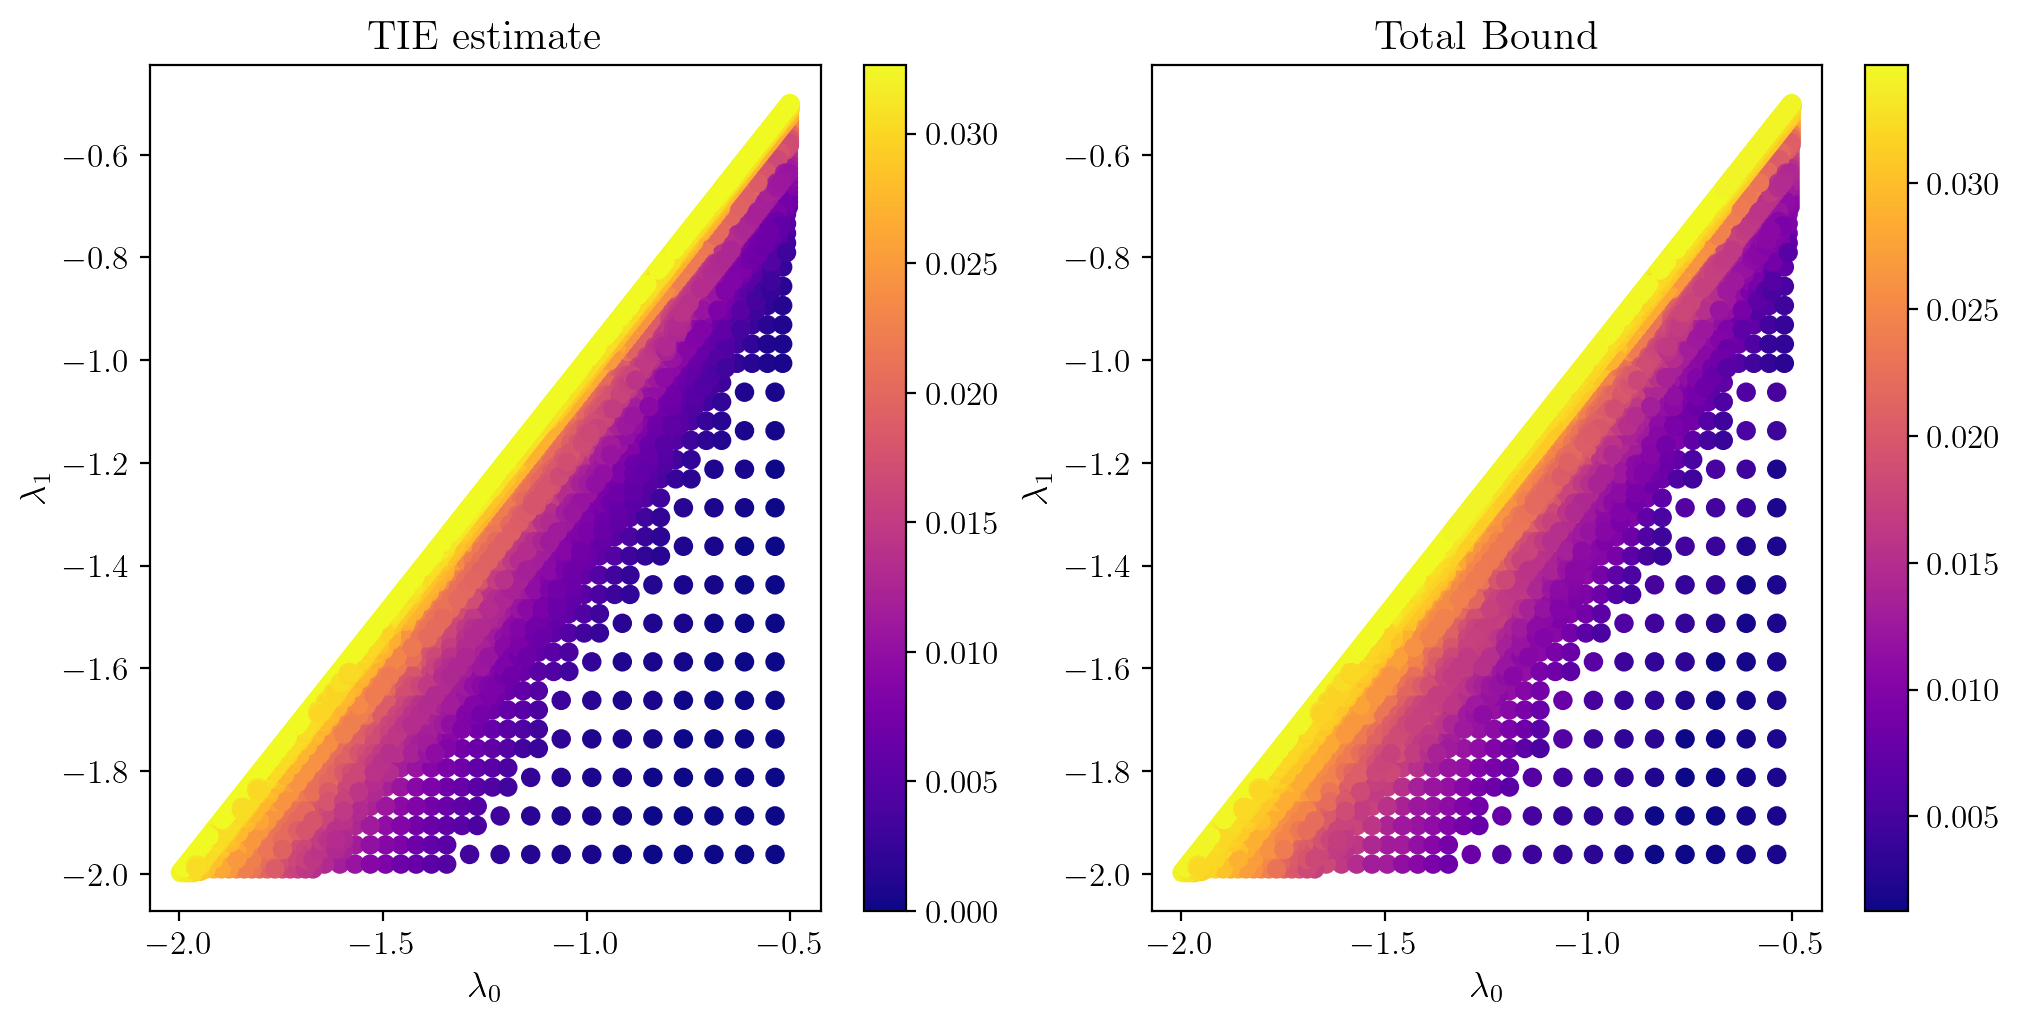

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5), constrained_layout=True)
plt.subplot(1,2,1)
plt.title('TIE estimate')
plt.scatter(df['theta0'], df['theta1'], c=df['tie_est'])
plt.xlabel('$\lambda_0$')
plt.ylabel('$\lambda_1$')
plt.colorbar()

plt.subplot(1,2,2)
plt.title('Total Bound')
plt.scatter(df['theta0'], df['theta1'], c=df['tie_bound'])
plt.xlabel('$\lambda_0$')
plt.ylabel('$\lambda_1$')
plt.colorbar()

plt.show()